##Graphs

In [51]:
import networkx as nx

def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.2, vert_loc=0,
                  xcenter=0.5, pos=None, parent=None):
    """
    계층형 트리 구조로 그래프 G를 배치하기 위한 좌표를 dict로 반환.
    - G: networkx DiGraph (또는 Graph)
    - root: 루트 노드 (없으면 임의로 하나 선택)
    - width: 전체 가로폭
    - vert_gap: 세로 간격
    - vert_loc: 루트의 y좌표
    - xcenter: 루트의 x좌표(가로 중앙 위치)
    - pos: 이미 배치된 노드 좌표(재귀적 호출용)
    - parent: 내부적으로 부모 노드를 추적하기 위함

    원본 참고: https://github.com/mdipierro/nx_templates (BSD 라이선스)
    """
    if pos is None:
        pos = {}
    if root is None:
        # 루트 노드를 자동 선택(진짜 트리라면 진입 차수가 0인 노드)
        root = next(iter(nx.topological_sort(G))) if isinstance(G, nx.DiGraph) else list(G.nodes)[0]

    # 자식 노드들
    neighbors = list(G.successors(root)) if isinstance(G, nx.DiGraph) else list(G.neighbors(root))
    if parent is not None and parent in neighbors:
        neighbors.remove(parent)

    # 리프이면 좌표 할당하고 리턴
    if len(neighbors) == 0:
        pos[root] = (xcenter, vert_loc)
        return pos

    # 자식이 있으면, 자식들의 가로 폭을 분배
    dx = width / len(neighbors)
    nextx = xcenter - width/2 - dx/2
    pos[root] = (xcenter, vert_loc)

    for child in neighbors:
        nextx += dx
        pos = hierarchy_pos(G, root=child, width=dx, vert_gap=vert_gap,
                            vert_loc=vert_loc - vert_gap, xcenter=nextx,
                            pos=pos, parent=root)
    return pos


In [52]:
import matplotlib.pyplot as plt

def draw_l1_tree_graph_hier(node, feature_names):
    """
    l1 CART 트리를 계층형 레이아웃으로 시각화
    node: l1 트리 루트 (Nodel1)
    feature_names: 변수 이름 리스트
    """
    import networkx as nx
    graph = nx.DiGraph()
    node_id_counter = [0]

    def add_nodes_edges(n, parent_id=None, is_left=None):
        node_id = node_id_counter[0]
        node_id_counter[0] += 1

        # 리프 노드이면 레이블에 l1 파라미터 표시
        if n.is_leaf:
            label = f"Leaf(L1)\nmedian={n.median_val:.2f}\nlogN(mu={n.lognorm_mu:.2f}, sig={n.lognorm_sigma:.2f})"
        else:
            split_name = feature_names[n.split_var]
            label = f"{split_name} <= {n.split_thr:.2f}\ngain={n.gain:.2f}"


        graph.add_node(node_id, label=label)

        if parent_id is not None:
            direction = "Yes" if is_left else "No"
            graph.add_edge(parent_id, node_id, label=direction)

        if not n.is_leaf:
            add_nodes_edges(n.left, node_id, True)
            add_nodes_edges(n.right, node_id, False)

        return node_id

    # 트리 전체를 순회하며 노드/엣지 구성
    root_id = add_nodes_edges(node)

    # 이제 hierarchy_pos를 이용해 계층형 좌표 생성
    pos = hierarchy_pos(graph, root=root_id)
    labels = nx.get_node_attributes(graph, 'label')
    edge_labels = nx.get_edge_attributes(graph, 'label')

    plt.figure(figsize=(18, 10))
    nx.draw(graph, pos, with_labels=True, labels=labels,
            node_size=2500, node_color="lightblue",
            font_size=10, font_weight="bold",
            edge_color="gray", linewidths=1, arrows=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels,
                                 font_color="red")
    plt.title("l1 CART Tree Visualization (Hierarchical Layout)")
    plt.axis("off")
    plt.show()


In [53]:
import matplotlib.pyplot as plt

def draw_gpd_tree_graph_hier(node, feature_names):
    """
    GPD CART 트리를 계층형 레이아웃으로 시각화
    node: GPD 트리 루트 (NodeGPD)
    feature_names: 변수 이름 리스트
    """
    import networkx as nx
    graph = nx.DiGraph()
    node_id_counter = [0]

    def add_nodes_edges(n, parent_id=None, is_left=None):
        node_id = node_id_counter[0]
        node_id_counter[0] += 1

        # 리프 노드이면 레이블에 GPD 파라미터 표시
        if n.is_leaf:
            sigma, gamma = n.gpd_params
            label = (f"Leaf(GPD)\n"
                     f"nll={n.nll:.1f}\n"
                     f"sigma={sigma:.2f}, gamma={gamma:.2f}")
        else:
            split_name = feature_names[n.split_var]
            label = (f"{split_name} ≤ {n.split_thr:.2f}\n"
                     f"gain={n.split_gain:.2f}")

        graph.add_node(node_id, label=label)

        if parent_id is not None:
            direction = "Yes" if is_left else "No"
            graph.add_edge(parent_id, node_id, label=direction)

        if not n.is_leaf:
            add_nodes_edges(n.left, node_id, True)
            add_nodes_edges(n.right, node_id, False)

        return node_id

    # 트리 전체를 순회하며 노드/엣지 구성
    root_id = add_nodes_edges(node)

    # 이제 hierarchy_pos를 이용해 계층형 좌표 생성
    pos = hierarchy_pos(graph, root=root_id)
    labels = nx.get_node_attributes(graph, 'label')
    edge_labels = nx.get_edge_attributes(graph, 'label')

    plt.figure(figsize=(18, 10))
    nx.draw(graph, pos, with_labels=True, labels=labels,
            node_size=2500, node_color="lightblue",
            font_size=10, font_weight="bold",
            edge_color="gray", linewidths=1, arrows=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels,
                                 font_color="red")
    plt.title("GPD CART Tree Visualization (Hierarchical Layout)")
    plt.axis("off")
    plt.show()


In [54]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from scipy.stats import ks_2samp, chi2
from scipy.optimize import minimize
import pandas as pd

# 전역: 영어 폰트 사용 및 음수 부호 깨짐 방지
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['axes.unicode_minus'] = False

# -------------------------
# 0. 도우미 함수 및 GP 로그우도 함수
# -------------------------
def neg_log_likelihood_gpd(params, y):
    sigma, gamma = params
    if sigma <= 0:
        return 1e15
    z = 1.0 + (gamma * y / sigma)
    if np.any(z <= 0):
        return 1e15
    ll = -np.log(sigma) - (1.0/gamma + 1.0)*np.log(z)
    return -np.sum(ll)

def gp_log_likelihood(params, y):
    """GP 분포의 log 우도"""
    return -neg_log_likelihood_gpd(params, y)

# 부트스트랩 신뢰구간 함수 (QQ Plot용)
def bootstrap_ci(y_leaf, ps, B=1000):
    """
    y_leaf: 리프 데이터 (1차원 array)
    ps: 분위수 비율 (예: np.linspace(0.01, 0.99, 50))
    B: 부트스트랩 반복 횟수
    """
    boot_samples = np.zeros((B, len(ps)))
    for b in range(B):
        sample = np.random.choice(y_leaf, size=len(y_leaf), replace=True)
        boot_samples[b, :] = np.percentile(sample, ps * 100)
    lo = np.percentile(boot_samples, 2.5, axis=0)
    hi = np.percentile(boot_samples, 97.5, axis=0)
    return lo, hi

# -------------------------
# 1. Hill Plot (영문, 로그 스케일, 안정구간 음영 표시)
# -------------------------
def plot_hill_plot(y, k_min=10, k_max=None, k_target=1000):
    y_desc = np.sort(y)[::-1]  # 내림차순 정렬
    n = len(y_desc)
    if k_max is None:
        k_max = min(n - 1, n // 2)

    k_values = np.arange(k_min, k_max)
    hill_estimates = [np.mean(np.log(y_desc[:k]) - np.log(y_desc[k])) for k in k_values]

    plt.figure(figsize=(8, 5))
    # 로그 스케일 x축 사용
    plt.semilogx(k_values, hill_estimates, marker='o', label="Hill Estimator")
    # 음영으로 안정 구간을 표시 (전체 추정치에 음영 처리)
    plt.fill_between(k_values, hill_estimates, alpha=0.15)
    plt.xlabel("k (number of top order statistics)")
    plt.ylabel("Hill estimator")
    plt.title("Hill Plot for Tail Index Selection")

    if k_target < n:
        # 인덱스를 일관적으로 수정: y_desc[k_target] 사용
        u_est = y_desc[k_target]
        plt.axvline(k_target, color='red', ls='--', label=f"k_target = {k_target}")
        est_target = np.mean(np.log(y_desc[:k_target]) - np.log(u_est))
        plt.axhline(est_target, color='red', ls='--', label=f"u ≈ {u_est:.0f}")
    plt.legend()
    plt.show()



# -------------------------
# 2. GP 트리 적합도 및 비교검정
# -------------------------

# (2-1) GP 트리 리프로 데이터를 할당하는 함수
def assign_data_to_leaves_gpd(gpd_tree, X, y):
    """
    gpd_tree: 학습된 GP 트리 (NodeGPD 구조)
    X: 극단치 데이터에 해당하는 feature 행렬 (각 행이 하나의 관측치)
    y: 대응하는 초과치 (y > 0)

    각 관측치를 gpd_tree를 따라 리프로 할당하여,
    {leaf_id: y_array} 형태의 딕셔너리를 반환합니다.
    """
    # 트리 내 모든 리프 노드 수집 (재귀적 탐색)
    leaves = []
    def traverse(node):
        if node.is_leaf:
            leaves.append(node)
        else:
            traverse(node.left)
            traverse(node.right)
    traverse(gpd_tree)

    leaf_data = {i: [] for i in range(len(leaves))}
    # 각 리프에 인덱스 매핑
    leaf_map = {leaf: i for i, leaf in enumerate(leaves)}

    # 각 관측치에 대해 해당 리프를 찾음 (find_leaf_gpd 함수 사용)
    for i in range(len(X)):
        leaf = find_leaf_gpd(gpd_tree, X[i])
        leaf_id = leaf_map[leaf]
        leaf_data[leaf_id].append(y[i])

    # 리스트를 numpy array로 변환
    for key in leaf_data:
        leaf_data[key] = np.array(leaf_data[key])
    return leaf_data, leaves

# (2-2) GP 트리 리프별 QQ 플롯 그리기 (로그 스케일, 부트스트랩 CI 추가)
def plot_gp_tree_qq(gpd_tree, X_high, y_high):
    leaf_data, leaves = assign_data_to_leaves_gpd(gpd_tree, X_high, y_high)
    ps = np.linspace(0.01, 0.99, 50)  # 분위수 비율

    for leaf_id, y_leaf in leaf_data.items():
        if len(y_leaf) < 10:
            print(f"Leaf {leaf_id}: too few points ({len(y_leaf)}). Skipped.")
            continue

        sigma, gamma = leaves[leaf_id].gpd_params
        # 이론적 분위수 계산 (GP 분포)
        theo_q = np.where(gamma != 0,
                          sigma/gamma * ((1-ps)**(-gamma) - 1),
                          -sigma * np.log(1-ps))
        # 표본 분위수 계산
        samp_q = np.percentile(y_leaf, ps * 100)
        # 부트스트랩 신뢰구간 계산 (표본 분위수에 대한 95% CI)
        lo, hi = bootstrap_ci(y_leaf, ps, B=1000)

        plt.figure(figsize=(6, 6))
        plt.fill_between(theo_q, lo, hi, color='lightgrey', alpha=0.5, label="95% bootstrap CI")
        plt.plot(theo_q, samp_q, 'o', label="Data")
        # 45도 기준선
        lims = [min(theo_q.min(), samp_q.min()), max(theo_q.max(), samp_q.max())]
        plt.plot(lims, lims, 'r--', label="45° line")
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Theoretical quantiles (log scale)")
        plt.ylabel("Sample quantiles (log scale)")
        plt.title(f"Leaf {leaf_id} (n={len(y_leaf)})\nσ = {sigma:.2f}, γ = {gamma:.2f}")
        plt.legend()
        plt.show()

# (2-3) 리프 간 KS 검정 수행 및 결과 테이블 출력 (p‑value 포맷 수정)
def compare_leaves_ks(leaf_data):
    res = []
    ids = list(leaf_data)
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            ks_stat, p = ks_2samp(leaf_data[ids[i]], leaf_data[ids[j]])
            res.append({"Leaf A": ids[i], "Leaf B": ids[j],
                        "KS‑stat": ks_stat, "p‑value": p})
    df = pd.DataFrame(res)
    # p‑value가 0인 경우 "<1e-323"로 표시, 나머지는 과학적 표기
    df["p‑value"] = df["p‑value"].apply(lambda x: "<1e-323" if x == 0 else f"{x:.1e}")
    print("Leaf 간 KS 검정 결과:")
    print(df)

# (2-4) Likelihood Ratio Test (LRT) 수행 (추가: AIC 계산 및 해석 문구 추가)
def gp_tree_lrt(gpd_tree, X_high, y_high):
    # 0 이하 값 제거
    y_high = y_high[y_high > 0]
    leaf_data, leaves = assign_data_to_leaves_gpd(gpd_tree, X_high, y_high)

    # GP 트리 로그우도 합 계산 (데이터가 있는 리프만 사용)
    ll_tree = 0.0
    n_leaves_used = 0
    for i, leaf in enumerate(leaves):
        if len(leaf_data[i]) > 0:
            ll_leaf = gp_log_likelihood(leaf.gpd_params, leaf_data[i])
            ll_tree += ll_leaf
            n_leaves_used += 1

    # 단일 GP 분포에 대해 MLE 수행 (전체 데이터)
    init = np.array([np.std(y_high), 0.1])
    bds  = [(1e-8, None), (None, None)]
    opt  = minimize(neg_log_likelihood_gpd, init, args=(y_high,),
                    method='L-BFGS-B', bounds=bds)
    ll_single = gp_log_likelihood(opt.x, y_high)

    lr = 2 * (ll_tree - ll_single)
    df_val = 2 * (n_leaves_used - 1)
    p = chi2.sf(lr, df_val)

    # AIC 계산
    k_tree = 2 * n_leaves_used  # 각 리프마다 2개의 파라미터
    k_single = 2
    aic_tree = 2 * k_tree - 2 * ll_tree
    aic_single = 2 * k_single - 2 * ll_single

    print("GP 트리 vs 단일 GP 적합 LRT 결과:")
    print(f"  GP 트리 로그우도 합: {ll_tree:.2f}")
    print(f"  단일 GP 로그우도: {ll_single:.2f}")
    print(f"  LRT statistic = {lr:.2f} (df = {df_val})")
    print(f"  p‑value = {p:.3e} -> {'reject' if p < 0.05 else 'fail to reject'} single GP model")
    print(f"  AIC (GP 트리) = {aic_tree:.2f}, AIC (단일 GP) = {aic_single:.2f}")

# -------------------------
# 3. 트리 관련 보조 함수
# -------------------------
def find_leaf_gpd(node, x_row):
    """
    재귀 대신 반복문 사용: 노드가 leaf가 될 때까지 split 변수와 임계값에 따라 이동.
    """
    while not node.is_leaf:
        if x_row[node.split_var] <= node.split_thr:
            node = node.left
        else:
            node = node.right
    return node




#Finance

In [55]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
from scipy.stats import genpareto
import copy

#############################################
# 1. 데이터 전처리
#############################################
# (1) 엑셀 파일 읽기 및 날짜 정리
# 실제 파일 경로로 수정하세요.
sasop_path = '/content/drive/MyDrive/sasop.xlsx'
# 손실 데이터 (미국 사건만 선택)
df1 = pd.read_excel(sasop_path)



In [56]:
df=df1.copy()

In [57]:
us_df = df[df['Country of Incident'] == 'United States']
loss_df = us_df[['First Year of Event','Industry Sector Code','Basel Business Line - Level 2','Event Risk Category','Current Value of Loss ($M)']].copy()
loss_df.rename(columns={'First Year of Event':'Date', 'Current Value of Loss ($M)':'Current Value of Loss'}, inplace=True)
loss_df['Date'] = pd.to_datetime(loss_df['Date']).dt.strftime('%Y')
loss_df.sort_values(by='Date', inplace=True)
loss_df = loss_df[loss_df['Date'] >= '1979']


In [58]:
loss_df_finance=loss_df[(loss_df['Industry Sector Code']==52)]

In [59]:
np.shape(loss_df_finance)

(11115, 5)

In [60]:
loss_df_finance.rename(columns={"Basel Business Line - Level 2":"Business"},inplace=True)

<ipython-input-60-99083bedbca1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_finance.rename(columns={"Basel Business Line - Level 2":"Business"},inplace=True)


In [61]:
loss_df_finance.head()

,Date,Industry Sector Code,Business,Event Risk Category,Current Value of Loss
1799,1979,52,Commercial Banking,"Clients, Products & Business Practices",8.844700
4667,1979,52,Professional Liability/Fidelity Coverage,"Clients, Products & Business Practices",4.219065
1282,1979,52,Retail Banking,Internal Fraud,2.304687
1654,1979,52,Commercial Banking,Internal Fraud,12.408634
1707,1979,52,Commercial Banking,"Clients, Products & Business Practices",6.328597


In [62]:
# loss_df_finance=loss_df_finance[['Date','Event Risk Category','Current Value of Loss']]

In [63]:
loss_df_finance.drop(columns=['Industry Sector Code'],inplace=True)

<ipython-input-63-825df21b5a50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_finance.drop(columns=['Industry Sector Code'],inplace=True)


In [64]:
loss_df_finance.head()

,Date,Business,Event Risk Category,Current Value of Loss
1799,1979,Commercial Banking,"Clients, Products & Business Practices",8.844700
4667,1979,Professional Liability/Fidelity Coverage,"Clients, Products & Business Practices",4.219065
1282,1979,Retail Banking,Internal Fraud,2.304687
1654,1979,Commercial Banking,Internal Fraud,12.408634
1707,1979,Commercial Banking,"Clients, Products & Business Practices",6.328597


In [65]:
# Encode 'Event Risk Category'
df_encoded_a = pd.get_dummies(loss_df_finance, columns=['Event Risk Category'], prefix='Category')



In [66]:
# Use the result of the first encoding as input for the second encoding
df_encoded_b = pd.get_dummies(df_encoded_a, columns=['Business'], prefix='Category')

# Final encoded DataFrame
loss_df_finance = df_encoded_b.copy()


In [67]:
loss_df_finance.head()

,Date,Current Value of Loss,Category_Business Disruption and System Failures,"Category_Clients, Products & Business Practices",Category_Damage to Physical Assets,Category_Employment Practices and Workplace Safety,"Category_Execution, Delivery & Process Management",Category_External Fraud,Category_Internal Fraud,Category_Advisory Services,...,Category_Others,Category_Private Banking,Category_Professional Liability/Fidelity Coverage,Category_Property and Casualty Insurance,Category_Proprietary Positions,Category_Reinsurance,Category_Retail Banking,Category_Retail Brokerage,Category_Sales,Category_Treasury
1799,1979,8.844700,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4667,1979,4.219065,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1282,1979,2.304687,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
1654,1979,12.408634,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1707,1979,6.328597,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
np.shape(loss_df_finance)

(11115, 35)

In [69]:
import pandas as pd
from functools import reduce

file_paths = {
    "us_cpi": "/content/drive/MyDrive/us_cpi.csv",
    "us_unemp": "/content/drive/MyDrive/us_unemp.csv",
    "us_vix": "/content/drive/MyDrive/us_vix.csv",
    "us_m1": "/content/drive/MyDrive/us_m1.csv",
    "us_home_price": "/content/drive/MyDrive/us_home price index.csv",
    "us_T10Y2Y": "/content/drive/MyDrive/us_T10Y2Y.csv",
    "sp500": "/content/drive/MyDrive/sp500_monthly.csv",
}

# Load
us_cpi = pd.read_csv(file_paths["us_cpi"])
us_unemp = pd.read_csv(file_paths["us_unemp"])
#us_vix = pd.read_csv(file_paths["us_vix"])
us_m1 = pd.read_csv(file_paths["us_m1"])
us_home_price = pd.read_csv(file_paths["us_home_price"])
us_T10Y2Y = pd.read_csv(file_paths["us_T10Y2Y"])
sp500 = pd.read_csv(file_paths["sp500"], skiprows=2)

# Rename columns for consistency
us_T10Y2Y.rename(columns={'T10Y2Y': '10_2'}, inplace=True)
us_home_price.rename(columns={'USSTHPI': 'House Price Index'}, inplace=True)
us_m1.rename(columns={'WM1NS': 'M1'}, inplace=True)
#us_vix.rename(columns={'VIXCLS': 'VIX'}, inplace=True)
us_cpi.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
us_unemp.rename(columns={'UNRATE': 'Unemployment Rate'}, inplace=True)
sp500.rename(columns={'Unnamed: 1': 'Close'}, inplace=True)
sp500=sp500.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5"])
# 1) Date 컬럼을 년(YYYY)으로만 변환
for df in [us_cpi, us_unemp, us_m1, us_home_price, us_T10Y2Y, sp500]:
    # 바깥에서 "Date" 컬럼 명으로 통일
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.year  # 년도로만 추출

# 2) 연 단위 집계: "마지막 값" or "평균" 등 선택
#   여기서는 예시로 평균값 사용
us_T10Y2Y = us_T10Y2Y.groupby("Date").mean().reset_index()
us_home_price = us_home_price.groupby("Date").mean().reset_index()
us_m1 = us_m1.groupby("Date").mean().reset_index()
#us_vix = us_vix.groupby("Date").mean().reset_index()
us_cpi = us_cpi.groupby("Date").mean().reset_index()
us_unemp = us_unemp.groupby("Date").mean().reset_index()
sp500 = sp500.groupby("Date").mean().reset_index()

us_cpi['CPI_diff']=np.log(us_cpi['CPI']).diff()
us_home_price['House Price Index_diff']=np.log(us_home_price['House Price Index']).diff()
sp500['Close_diff']=np.log(sp500['Close']).diff()
sp500.fillna(0.1635259493925565,inplace=True)

# 3) 머지
dfs = [us_T10Y2Y, us_home_price, us_m1,  us_cpi, us_unemp, sp500]
df_merged_macro = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)


df_merged_macro_lag=df_merged_macro.copy()
df_merged_macro_lag = df_merged_macro_lag[df_merged_macro_lag["Date"] >= 1980]
df_merged_macro_lag['Date']=df_merged_macro_lag['Date'].astype(str)

In [70]:
import pandas as pd
import numpy as np
from functools import reduce

file_paths = {
    "us_cpi": "/content/drive/MyDrive/us_cpi.csv",
    "us_unemp": "/content/drive/MyDrive/us_unemp.csv",
    "us_vix": "/content/drive/MyDrive/us_vix.csv",
    "us_m1": "/content/drive/MyDrive/us_m1.csv",
    "us_home_price": "/content/drive/MyDrive/us_home price index.csv",
    "us_T10Y2Y": "/content/drive/MyDrive/us_T10Y2Y.csv",
    "sp500": "/content/drive/MyDrive/sp500_monthly.csv",
}

# Load
us_cpi = pd.read_csv(file_paths["us_cpi"])
us_unemp = pd.read_csv(file_paths["us_unemp"])
us_m1 = pd.read_csv(file_paths["us_m1"])
us_home_price = pd.read_csv(file_paths["us_home_price"])
us_T10Y2Y = pd.read_csv(file_paths["us_T10Y2Y"])
sp500 = pd.read_csv(file_paths["sp500"], skiprows=2)

# Rename columns
us_T10Y2Y.rename(columns={'T10Y2Y': '10_2'}, inplace=True)
us_home_price.rename(columns={'USSTHPI': 'House Price Index'}, inplace=True)
us_m1.rename(columns={'WM1NS': 'M1'}, inplace=True)
us_cpi.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
us_unemp.rename(columns={'UNRATE': 'Unemployment Rate'}, inplace=True)
sp500.rename(columns={'Unnamed: 1': 'Close'}, inplace=True)
sp500 = sp500.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5"])

# Date 처리 및 연 단위 평균
for df in [us_cpi, us_unemp, us_m1, us_home_price, us_T10Y2Y, sp500]:
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.year

us_T10Y2Y = us_T10Y2Y.groupby("Date").mean().reset_index()
us_home_price = us_home_price.groupby("Date").mean().reset_index()
us_m1 = us_m1.groupby("Date").mean().reset_index()
us_cpi = us_cpi.groupby("Date").mean().reset_index()
us_unemp = us_unemp.groupby("Date").mean().reset_index()
sp500 = sp500.groupby("Date").mean().reset_index()

# log-diff 처리
macro_dfs = {
    'CPI_diff': (us_cpi, 'CPI'),
    'House Price Index_diff': (us_home_price, 'House Price Index'),
    'M1_diff': (us_m1, 'M1'),
    '10_2_diff': (us_T10Y2Y, '10_2'),
    'Unemployment Rate_diff': (us_unemp, 'Unemployment Rate'),
    'Close_diff': (sp500, 'Close'),
}

# diff 열 추가
for diff_col, (df, col) in macro_dfs.items():
    df[diff_col] = np.log(df[col]).diff()

# sp500의 첫 번째 NaN만 특정 값으로 채움
sp500['Close_diff'].fillna(0.1635259493925565, inplace=True)

# 병합
dfs = [us_T10Y2Y, us_home_price, us_m1, us_cpi, us_unemp, sp500]
df_merged_macro = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)

# 최종 lag 데이터
df_merged_macro_lag = df_merged_macro[df_merged_macro["Date"] >= 1980].copy()
df_merged_macro_lag['Date'] = df_merged_macro_lag['Date'].astype(str)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-70-b81c95cc248a>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sp500['Close_diff'].fillna(0.1635259493925565, inplace=True)


In [71]:
df_merged_macro_lag.head()

,Date,10_2,10_2_diff,House Price Index,House Price Index_diff,M1,M1_diff,CPI,CPI_diff,Unemployment Rate,Unemployment Rate_diff,Close,Close_diff
0,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.085960,107.600000,0.034671,7.191667,-0.043091,188.966668,0.163526
1,1986,0.812360,-0.509468,136.3500,0.066070,666.057692,0.126388,109.691667,0.019253,7.000000,-0.027013,238.920832,0.234562
2,1987,0.977040,0.184584,145.1750,0.062715,743.517308,0.110016,113.616667,0.035157,6.175000,-0.125401,285.991665,0.179830
3,1988,0.747600,-0.267660,152.9675,0.052286,774.346154,0.040627,118.275000,0.040182,5.491667,-0.117277,268.050835,-0.064786
4,1989,-0.078680,NaN,161.0375,0.051412,782.015385,0.009855,123.941667,0.046799,5.258333,-0.043418,326.314163,0.196684


In [72]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
from scipy.stats import genpareto
import copy
#1986부터 사용
#############################################
# 1. 데이터 전처리 (연 단위)
#############################################
# (1) 엑셀 파일 읽기 및 날짜 정리
# 실제 파일 경로로 수정하세요.

epu_kr_path = '/content/drive/MyDrive/Korea_Overall_EPU.xlsx'
epu_kr_cat_path = '/content/drive/MyDrive/Korea_Categorical_PU_Indices.xlsx'
epu_usa_path = '/content/drive/MyDrive/US_Policy_Uncertainty_Data.xlsx'
epu_usa_cat_path = '/content/drive/MyDrive/Categorical_EPU_Data.xlsx'


# 미국 EPU 데이터
epu_usa = pd.read_excel(epu_usa_path)
epu_usa_cat = pd.read_excel(epu_usa_cat_path)
# 연도만 추출 (datetime 변환 후 정수형으로)
epu_usa['Year'] = pd.to_datetime(epu_usa['Year'], format='%Y').dt.year.astype(int)
epu_usa_cat['Year'] = pd.to_datetime(epu_usa_cat['Year'], format='%Y').dt.year.astype(int)
# 연도 필터링 (1985~2022)
epu_usa_cl = epu_usa[(epu_usa['Year'] < 2023)].copy()
epu_usa_cat_cl = epu_usa_cat[ (epu_usa_cat['Year'] < 2023)].copy()
# 최종적으로 'Date' 컬럼에 연도만(문자형) 저장
epu_usa_cl['Date'] = epu_usa_cl['Year'].astype(str)
epu_usa_cat_cl['Date'] = epu_usa_cat_cl['Year'].astype(str)
epu_usa_cl_lag = epu_usa_cl.copy()
epu_usa_cat_cl_lag = epu_usa_cat_cl.copy()

# (2) 여러 DataFrame 병합 (Date 기준 inner merge)
dfs = [df_merged_macro_lag,epu_usa_cl,epu_usa_cat_cl, loss_df_finance]
df_merged = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)


# 불필요하게 많이 생긴 NaN forward fill 등 (선택)
df_merged.sort_values("Date", inplace=True)
df_merged.fillna(method='ffill', inplace=True)

# 2) 극단값 분석용 상위 90% 초과치
# tau = df_merged['Current Value of Loss'].quantile(0.90)
# df_merged = df_merged[df_merged['Current Value of Loss'] > tau].copy()
df_merged['Exceedance'] = df_merged['Current Value of Loss']


<ipython-input-72-d455ab0656e8>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True)


In [73]:
df_merged.head()

,Date,10_2,10_2_diff,House Price Index,House Price Index_diff,M1,M1_diff,CPI,CPI_diff,Unemployment Rate,...,Category_Private Banking,Category_Professional Liability/Fidelity Coverage,Category_Property and Casualty Insurance,Category_Proprietary Positions,Category_Reinsurance,Category_Retail Banking,Category_Retail Brokerage,Category_Sales,Category_Treasury,Exceedance
0,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,True,False,False,False,29.172714
9881,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,True,False,False,False,False,False,False,4.225260
9882,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,False,False,False,False,14.404295
9883,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,False,False,False,False,10.813796
9884,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,False,False,False,False,11.523436


In [75]:
# 1) 전체 EPU 연평균 집계
# ————————
# epu_usa_cl 은 Year, Month, Three_Component_Index, News_Based_Policy_Uncert_Index 컬럼 보유
epu_usa_cl['Date'] = epu_usa_cl['Year'].astype(str)

epu_overall = (
    epu_usa_cl
    .groupby('Date')[['Three_Component_Index','News_Based_Policy_Uncert_Index']]
    .mean()
    .reset_index()
)

# 2) 범주형 EPU 연평균 집계
# ————————
cat_cols = [
    '1. Economic Policy Uncertainty','2. Monetary policy',
    'Fiscal Policy (Taxes OR Spending)','3. Taxes',
    '4. Government spending','5. Health care',
    '6. National security','7. Entitlement programs',
    '8. Regulation','Financial Regulation',
    '9. Trade policy','10. Sovereign debt, currency crises'
]
epu_usa_cat_cl['Date'] = epu_usa_cat_cl['Year'].astype(str)

epu_cats = (
    epu_usa_cat_cl
    .groupby('Date')[cat_cols]
    .mean()
    .reset_index()
)

# 3) 매크로 + EPU(전체+범주) 병합
# ———————————————
df_macro_epu = (
    df_merged_macro_lag
    .merge(epu_overall, on='Date', how='inner')
    .merge(epu_cats,    on='Date', how='inner')
)

# 4) 최종: 이벤트 손실(≈433행)과 1:1 병합
# ——————————————————————
final_df = df_macro_epu.merge(loss_df_finance, on='Date', how='inner')

print(final_df.shape)  # → (≈433, 원하는 컬럼만)


(10698, 61)


In [76]:
final_df.columns

Index(['Date', '10_2', '10_2_diff', 'House Price Index',
       'House Price Index_diff', 'M1', 'M1_diff', 'CPI', 'CPI_diff',
       'Unemployment Rate', 'Unemployment Rate_diff', 'Close', 'Close_diff',
       'Three_Component_Index', 'News_Based_Policy_Uncert_Index',
       '1. Economic Policy Uncertainty', '2. Monetary policy',
       'Fiscal Policy (Taxes OR Spending)', '3. Taxes',
       '4. Government spending', '5. Health care', '6. National security',
       '7. Entitlement programs', '8. Regulation', 'Financial Regulation',
       '9. Trade policy', '10. Sovereign debt, currency crises',
       'Current Value of Loss',
       'Category_Business Disruption and System Failures',
       'Category_Clients, Products & Business Practices',
       'Category_Damage to Physical Assets',
       'Category_Employment Practices and Workplace Safety',
       'Category_Execution, Delivery & Process Management',
       'Category_External Fraud', 'Category_Internal Fraud',
       'Category_Advi

In [80]:
df_merged=final_df.copy()
df_merged['Exceedance']=df_merged['Current Value of Loss']

#hill plot

In [81]:
# thresholding.py ─────────────────────────────────────────────────
from dataclasses import dataclass
from typing import Tuple, Optional, Literal
import numpy as np
import logging
from scipy import stats

MIN_FLOAT = np.finfo(float).eps

@dataclass
class HillDiag:
    k_grid:     np.ndarray  # k 값 벡터
    gamma_hat:  np.ndarray  # smooth된 Hill 추정치
    grad_norm:  np.ndarray  # |∇γ| / |γ|
    var_rel:    np.ndarray  # var(γ) / γ²
    smooth_win: int         # 스무딩 윈도우 크기

def _auto_hill(y: np.ndarray,
               *,
               k_min: int = 50,
               k_max_prop: float = 0.1,
               window: int = 61,
               rel_grad_tol: float = 0.04,
               rel_var_tol: float = 0.03,
               gamma_min: float = 0.02,
               min_plateau_len: int = 10,
               plateau_strategy= 'longest',
               min_excess: Optional[int] = None,
               max_excess: Optional[int] = None
               ) -> Tuple[float, int, float, HillDiag]:
    """
    Hill estimator 기반 자동 임계값 탐색.
    plateau_strategy: 'first' | 'longest'
    min_excess, max_excess: None 이면 len(y)의 1%, 25%로 자동 설정
    """
    y = np.asarray(y, dtype=float)
    n = y.size
    if min_excess is None:
        min_excess = max(50, int(n*0.01))
    if max_excess is None:
        max_excess = int(n*0.25)

    # 내림차순 정렬
    y_desc = np.sort(y)[::-1]
    k_max = int(min(n*k_max_prop, n-1))
    ks = np.arange(k_min, k_max+1)
    # 양수만
    y_pos = y_desc[y_desc>0]
    ks = ks[ks < y_pos.size]

    # Hill γ(k)
    gamma_k = np.array([
        np.mean(np.log(y_pos[:k]) - np.log(y_pos[k]))
        for k in ks
    ])

    # 스무딩
    win = window if window<=gamma_k.size else max(3,(gamma_k.size//2)*2+1)
    pad = win//2
    g_pad = np.pad(gamma_k, (pad,pad), mode='edge')
    smooth = np.convolve(g_pad, np.ones(win)/win, mode='valid')

    # 진단량 계산
    grad_norm = np.abs(np.gradient(smooth)) / np.maximum(np.abs(smooth), MIN_FLOAT)
    g2_pad = np.pad(gamma_k**2, (pad,pad), mode='edge')
    mean2 = np.convolve(g2_pad, np.ones(win)/win, mode='valid')
    var_rel = np.maximum(mean2 - smooth**2, 0) / np.maximum(smooth**2, MIN_FLOAT)

    # 안정 구간 boolean mask
    stable = (grad_norm < rel_grad_tol) & (var_rel < rel_var_tol) & (smooth > gamma_min)

    # plateau 블록 탐색
    blocks, cur = [], []
    for i, ok in enumerate(stable):
        if ok:
            cur.append(i)
        else:
            if cur:
                blocks.append(cur.copy())
                cur.clear()
    if cur:
        blocks.append(cur.copy())

    # 블록 선택
    k_hat = None
    valid_blocks = [b for b in blocks if len(b) >= min_plateau_len]
    if valid_blocks:
        if plateau_strategy == 'first':
            blk = valid_blocks[0]
        else:  # 'longest'
            blk = max(valid_blocks, key=len)
        mid = blk[len(blk)//2]
        k_hat = ks[mid]
        logging.info(f"Plateau({plateau_strategy}) -> block indices {blk[:3]}... len={len(blk)} -> k={k_hat}")

    # fallback: KS 통계량 최소화
    if k_hat is None:
        logging.warning("No plateau found: fallback to KS-minimization")
        ks_stats = np.full(ks.shape, np.inf)
        for idx, k in enumerate(ks):
            if k < min_excess or k > max_excess:
                continue
            excess = y_pos[:k] - y_pos[k]
            # 충분한 샘플만
            if excess.size < min_excess:
                continue
            ξ, _, σ = stats.genpareto.fit(excess, floc=0)
            ks_stats[idx] = stats.kstest(excess, 'genpareto', args=(ξ,0,σ))[0]
        best = np.nanargmin(ks_stats)
        k_hat = ks[best]
        logging.info(f"KS-min D={ks_stats[best]:.4f} at k={k_hat}")

    # 경계 보정
    k_hat = int(np.clip(k_hat, min_excess, max_excess))
    k_hat = min(k_hat, y_pos.size-1)

    # 최종 u_hat, γ_hat
    u_hat = float(y_pos[k_hat])
    gamma_hat = np.mean(np.log(y_pos[:k_hat]) - np.log(y_pos[k_hat]))

    diag = HillDiag(
        k_grid=ks,
        gamma_hat=smooth,
        grad_norm=grad_norm,
        var_rel=var_rel,
        smooth_win=win
    )
    return u_hat, k_hat, gamma_hat, diag

def select_threshold(y: np.ndarray,
                     *,
                     u_override: Optional[float] = None,
                     return_diag: bool = False,
                     **hill_kw
                     ) -> Tuple[float,int,float] or Tuple[float,int,float,HillDiag]:
    """
    - u_override: override 기준 임계값을 직접 지정
    - hill_kw: _auto_hill에 넘겨줄 파라미터들
    """
    y = np.asarray(y, dtype=float)
    if y.ndim!=1 or y.size==0:
        raise ValueError("y must be 1-D non-empty array")

    u_auto, k_auto, g_auto, diag = _auto_hill(y, **hill_kw)

    if u_override is not None:
        u_hat = float(u_override)
        exceed = y[y>u_hat]
        k_hat = exceed.size
        if k_hat < 1:
            logging.warning("u_override > max(y): no exceedances")
            gamma_hat = 0.0
        else:
            exc_sorted = np.sort(exceed)[::-1]
            gamma_hat = np.mean(np.log(exc_sorted[:k_hat]) - np.log(exc_sorted[k_hat-1]))
    else:
        u_hat, k_hat, gamma_hat = u_auto, k_auto, g_auto

    if return_diag:
        return u_hat, k_hat, gamma_hat, diag
    return u_hat, k_hat, gamma_hat


In [82]:
u, k, g, diag = select_threshold(
    df_merged['Exceedance'],
    k_min=10, min_excess=10,
    return_diag=True
)

# # 사용자가 수동으로 3만을 쓰고 싶을 때
# u = 30_000
# u_manual, k_m, g_m = select_threshold(
#     y_all_data,
#     u_override=u
# )


In [83]:
u,k,g

(191.819728304947, 558, np.float64(1.1002278205711957))

In [84]:
import numpy as np

# y: 원래 쓰신 1-D numpy array (예: y_all_data)
y = np.asarray(df_merged['Exceedance'])
#u, k, g = 634.6707709518438, 23306, 1.0552616654163112

# 1) 단순 분위수 계산: u가 몇 분위수인지
q_empirical = np.mean(y <= u)
print(f"Empirical quantile of u = {q_empirical:.4f} → {q_empirical*100:.2f}%")

# 2) k를 이용한 계산: exceedance 개수 k = # {y > u}
#    그래서 quantile = 1 - k / n
n = y.size
q_from_k = 1 - k/n
print(f"From k: 1 - {k}/{n} = {q_from_k:.4f} → {q_from_k*100:.2f}%")


Empirical quantile of u = 0.9478 → 94.78%
From k: 1 - 558/10698 = 0.9478 → 94.78%


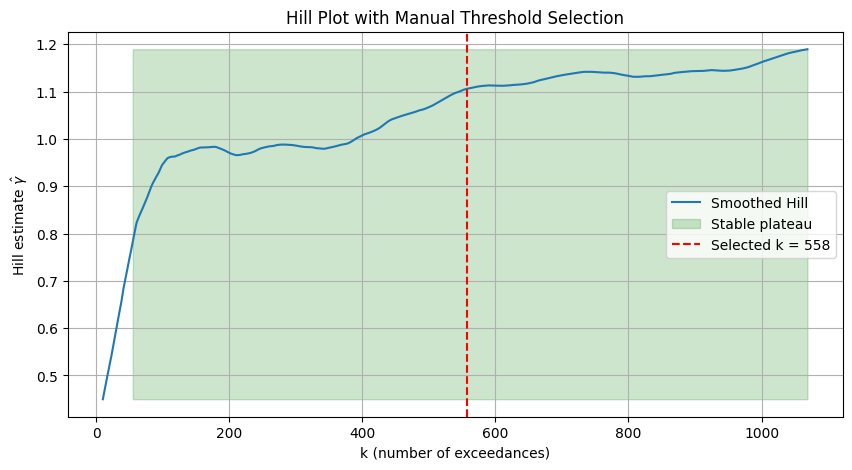

In [85]:
    # Plot Hill plot
    plt.figure(figsize=(10, 5))
    plt.plot(diag.k_grid, diag.gamma_hat, label='Smoothed Hill')
    plt.fill_between(diag.k_grid,
                     np.min(diag.gamma_hat),
                     np.max(diag.gamma_hat),
                     where=(diag.grad_norm < 5e-2) & (diag.var_rel < 2e-2),
                     color='green', alpha=0.2,
                     label='Stable plateau')
    plt.axvline(k, color='red', linestyle='--', label=f'Selected k = {k}')
    plt.xlabel('k (number of exceedances)')
    plt.ylabel(r'Hill estimate $\hat\gamma$')
    plt.title('Hill Plot with Manual Threshold Selection')
    plt.legend()
    plt.grid(True)
    plt.show()


#finance

In [92]:
"""
========================================================================
  EXTREME-VALUE CART TOOLBOX (Improved Version)
  · L1 CART (median) + Leaf-wise LogNormal
  · L2 CART (mean)   + Leaf-wise LogNormal
  · Hill-plot based threshold (u) auto-estimation (stabilized)
  · GPD CART + CV-pruning (node NLL recalculation, 1-pass)
  assign_lognorm_params
  selected_lags_dict
  _get_all_leaves
========================================================================
"""
import numpy as np
import pandas as pd
import logging
from scipy.optimize import minimize
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
from scipy import stats
import copy
from typing import Tuple, List, Optional, Dict, Any, Union
import math

# ---------------------------------------------------------------------#
# Logging Setup
# ---------------------------------------------------------------------#
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# ---------------------------------------------------------------------#
# Constants
# ---------------------------------------------------------------------#
# SEED = 42
# np.random.seed(SEED)
# MIN_FLOAT = 1e-9 # Small number to avoid division by zero etc.
# LARGE_FLOAT = 1e15 # Large number for infinite costs/NLL

FLT_INFO = np.finfo(float)

SEED        = 42
rng         = np.random.default_rng(SEED)     # 전역 RandomGenerator
MIN_FLOAT   = FLT_INFO.eps                    # ≈2.22e‑16
LARGE_FLOAT = 1e30

# ---------------------------------------------------------------------#
# 0. Utility Functions
# ---------------------------------------------------------------------#
def mse_loss(y: np.ndarray, mu: float) -> float:
    """Calculate Mean Squared Error."""
    if len(y) == 0:
        return 0.0
    return np.sum((y - mu) ** 2)

def mae_loss(y: np.ndarray, md: float) -> float:
    """Calculate Mean Absolute Error."""
    if len(y) == 0:
        return 0.0
    return np.sum(np.abs(y - md))

# ---------------------------------------------------------------------#
# Base Node Class and Specific Nodes
# ---------------------------------------------------------------------#
class NodeBase:
    """Base class for all nodes in the trees."""
    __slots__ = ("is_leaf", "split_var", "split_thr", "gain", "left", "right", "depth", "n_samples")

    def __init__(self):
        self.is_leaf: bool = True
        self.split_var: Optional[int] = None
        self.split_thr: Optional[float] = None
        self.gain: float = 0.0
        self.left: Optional['NodeBase'] = None
        self.right: Optional['NodeBase'] = None
        self.depth: int = 0
        self.n_samples: int = 0 # Keep track of samples in the node

class NodeL1(NodeBase):
    """Node for L1 CART (median-based)."""
    __slots__ = ("median_val", "lognorm_mu", "lognorm_sigma")

    def __init__(self):
        super().__init__()
        self.median_val: Optional[float] = None
        self.lognorm_mu: Optional[float] = None
        self.lognorm_sigma: Optional[float] = None

class NodeL2(NodeBase):
    """Node for L2 CART (mean-based)."""
    __slots__ = ("mean_val", "lognorm_mu", "lognorm_sigma")

    def __init__(self):
        super().__init__()
        self.mean_val: Optional[float] = None
        self.lognorm_mu: Optional[float] = None
        self.lognorm_sigma: Optional[float] = None

class NodeGPD(NodeBase):
    """Node for GPD CART."""
    __slots__ = ("gpd_params", "nll", "split_gain") # Inherits others via super().__init__()

    def __init__(self):
        super().__init__() # Initializes is_leaf, split_var, split_thr, left, right, depth, n_samples
        # Note: 'gain' from NodeBase is repurposed as 'split_gain' here for clarity in GPD context
        self.split_gain: float = 0.0 # Gain used for splitting decision (AIC penalized)
        self.gpd_params: Optional[Tuple[float, float]] = None # (sigma, gamma)
        self.nll: Optional[float] = None # Negative Log-Likelihood at this node



def _nll_lognormal(params: Tuple[float, float],
                   y: np.ndarray,
                   *, trunc_left: float = 0.0) -> float:
    """
    Negative Log‑Likelihood for (optionally *left‑truncated*) LogNormal.
    trunc_left = 0  → 일반 LogNormal
    trunc_left = u  → P(Y>u) 로 조건부화한 LogNormal
    """
    mu, sigma = params
    if sigma <= MIN_FLOAT:
        return LARGE_FLOAT

    y_pos = y[y > 0]
    if y_pos.size == 0:
        return LARGE_FLOAT

    log_y = np.log(y_pos)
    z     = (log_y - mu) / sigma
    base  = np.sum(np.log(sigma) + 0.5*np.log(2*np.pi) + 0.5*z**2 + log_y)

    if trunc_left > 0:
        # S = survival func  = P(Y>u) = 1 - Φ((ln u - μ)/σ)
        zc   = (np.log(trunc_left) - mu) / sigma
        surv = 1.0 - 0.5*(1 + math.erf(zc/np.sqrt(2)))
        if surv <= 0:
            return LARGE_FLOAT
        base -= y_pos.size * np.log(surv)

    return base if np.isfinite(base) else LARGE_FLOAT



def fit_lognormal_mle(y: np.ndarray, *, trunc_left: float = 0.0
                      ) -> Tuple[float, float]:
    """MLE for (optionally left‑truncated) LogNormal → (μ̂, σ̂)."""
    y_pos = y[y > 0]
    n_pos = y_pos.size
    if n_pos < 2:
        if n_pos == 1:
            return float(np.log(y_pos[0])), MIN_FLOAT*10
        return 0.0, 1.0

    log_y = np.log(y_pos)
    init   = [log_y.mean(), max(log_y.std(), MIN_FLOAT*10)]
    bounds = [(None, None), (MIN_FLOAT*10, None)]

    obj = lambda p: _nll_lognormal(p, y_pos, trunc_left=trunc_left)

    try:
        res = minimize(obj, init, method="L-BFGS-B", bounds=bounds)
        if res.success and np.all(np.isfinite(res.x)):
            μ, σ = res.x
            σ = max(σ, MIN_FLOAT*100)
            return float(μ), float(σ)
    except Exception as e:
        logging.debug(f"LogNormal MLE failed: {e}")

    return tuple(init)


# ---------------------------------------------------------------------#
# GPD MLE and Cost Function
# ---------------------------------------------------------------------#
def neg_loglik_gpd(theta: Tuple[float, float], y: np.ndarray) -> float:
    """
    Calculate negative log-likelihood for Generalized Pareto Distribution (GPD).
    Handles the case gamma -> 0 (Exponential distribution limit).
    """
    sigma, gamma = theta
    n = len(y)
    if n == 0:
        return 0.0
    if sigma <= MIN_FLOAT: # Sigma must be positive
        return LARGE_FLOAT

    # Handle Exponential distribution case (gamma ≈ 0)
    if abs(gamma) < 1e-6:
        if np.any(y < 0): # Exponential is for non-negative values
             return LARGE_FLOAT
        nll = n * np.log(sigma) + np.sum(y) / sigma
    else:
        # Standard GPD case
        z = 1 + gamma * y / sigma
        if np.any(z <= MIN_FLOAT): # Argument of log must be positive
            return LARGE_FLOAT
        # Correct GPD log-likelihood: sum(log(sigma) + (1/gamma + 1) * log(z))
        nll = n * np.log(sigma) + (1 / gamma + 1) * np.sum(np.log(z))

    # Check for non-finite results which can break optimization
    if not np.isfinite(nll):
        return LARGE_FLOAT
    return nll
def fit_gpd_mle(y: np.ndarray,
                *, gamma_bounds: Tuple[float, float] = (-0.5, 0.95)) -> np.ndarray:
    """
    Stabilized GPD MLE fitting.
    - Returns [sigma, gamma].
    - Uses PWM for initialization.
    - Applies boundary penalties.
    - Enforces sigma lower bound.
    - Handles small samples.
    """
    bounds = [(MIN_FLOAT*10, None), gamma_bounds]
    n = len(y)
    # 0) Handle very small samples
    if n < 30:
        # Fallback: Use median for scale, slightly negative shape
        # Ensure sigma is positive
        fallback_sigma = max(np.median(y), MIN_FLOAT * 10) if n > 0 else 1.0
        return np.array([fallback_sigma, -0.2])

    # 1) Probability-Weighted Moments (PWM) initial estimate
    y_sorted = np.sort(y)
    # Use unbiased PWM estimators if available, otherwise simple moments
    # For simplicity here, use sample mean and median heuristic
    y_bar = np.mean(y)
    y_med = np.median(y)
    # Heuristic initial gamma (can be unstable, hence clipping)
    gamma0_raw = (y_bar - 2.0 * y_med) / (y_bar - y_med + MIN_FLOAT)
    gamma0 = np.clip(gamma0_raw, -0.4, 0.9) # Clip to reasonable range
    # Initial sigma based on gamma0 and mean, ensuring positivity
    sigma0 = max(abs(gamma0) * y_bar if abs(gamma0) > 1e-4 else y_bar, MIN_FLOAT * 10) # Use y_bar if gamma near 0

    init_params = np.array([sigma0, gamma0])

    # 2) Optimization settings
    #bounds = [(MIN_FLOAT * 10, None), (-0.5, 0.95)] # Sigma > 0, Gamma constrained

    def objective_with_penalty(theta: np.ndarray, data: np.ndarray) -> float:
        """Objective function with boundary penalties for GPD NLL."""
        s, g = theta
        base_nll = neg_loglik_gpd(theta, data)
        penalty = 0.0
        # Penalize being too close to boundaries where optimization might struggle
        if abs(g) < 1e-4 or abs(g + 0.5) < 1e-3 or abs(g - 0.95) < 1e-3:
            penalty = 1e2 # Fixed penalty, could be adaptive

        # Penalize non-finite NLL heavily
        if not np.isfinite(base_nll):
             return LARGE_FLOAT

        return base_nll + penalty

    # 3) Run L-BFGS-B optimizer
    try:
        res = minimize(
            objective_with_penalty,
            x0=init_params,
            args=(y,),
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": 200, "ftol": 1e-9, "eps": 1e-7}, # Added eps for numerical differentiation
        )

        # 4) Check success and enforce sigma lower bound
        if res.success and np.isfinite(res.fun):
            s_opt, g_opt = res.x
            # Ensure sigma meets the minimum requirement
            final_sigma = max(s_opt, MIN_FLOAT * 10)
            return np.array([final_sigma, g_opt])
        else:
             logging.debug(f"GPD MLE optimization failed (Status: {res.status}, Msg: {res.message}). Returning PWM init.")
             # Fallback to initial estimate if optimization failed
             return init_params

    except (ValueError, RuntimeWarning, Exception) as e:
        logging.debug(f"GPD MLE failed with error: {e}. Returning PWM init: {init_params}")
        # Fallback to initial estimate on any exception
        return init_params

def node_cost_gpd(y: np.ndarray) -> Tuple[float, np.ndarray]:
    """
    Calculate node cost (NLL) and parameters for GPD.
    Returns (cost, [sigma, gamma]). Handles failures gracefully.
    """
    if len(y) == 0:
        return 0.0, np.array([1.0, 0.0]) # Default params for empty node

    try:
        theta = fit_gpd_mle(y)
        cost = neg_loglik_gpd(theta, y)

        # If cost is non-finite, return a large cost and the estimated (possibly bad) theta
        if not np.isfinite(cost):
            logging.debug(f"Non-finite GPD cost ({cost}) for theta={theta}. Returning large cost.")
            return LARGE_FLOAT, theta
        return cost, theta
    except Exception as e:
        # Broad exception catch during cost calculation (should be rare if fit_gpd_mle is robust)
        logging.warning(f"Error during node_cost_gpd: {e}. Returning large cost.")
        # Provide default parameters in case of complete failure
        fallback_sigma = max(np.median(y), MIN_FLOAT * 10) if len(y) > 0 else 1.0
        fallback_theta = np.array([fallback_sigma, -0.2])
        return LARGE_FLOAT, fallback_theta




# ---------------------------------------------------------------------#
# 2. CART Splitting Functions
# ---------------------------------------------------------------------#
def _best_split_l1(x: np.ndarray, y: np.ndarray, min_leaf: int = 1
                   ) -> Tuple[float, Optional[float]]:
    """Find the best split point for a node in L1 CART (median-based)."""
    n = len(y)
    if n < 2 * min_leaf: # Cannot split if not enough samples
        return 0.0, None

    # Sort data by the feature x
    idx = np.argsort(x)
    xs, ys = x[idx], y[idx]

    parent_median = np.median(ys)
    parent_loss = mae_loss(ys, parent_median)
    best_gain, best_thr = 0.0, None

    # Iterate through possible split points
    # A split occurs between i-1 and i
    for i in range(min_leaf, n - min_leaf ):
        # Only consider splits where x value changes
        if xs[i] == xs[i - 1]:
            continue

        # Calculate loss for left and right children
        left_y, right_y = ys[:i], ys[i:]
        median_l = np.median(left_y)
        median_r = np.median(right_y)
        child_loss = mae_loss(left_y, median_l) + mae_loss(right_y, median_r)

        # Calculate gain
        gain = parent_loss - child_loss

        # Update best split if current gain is higher
        if gain > best_gain:
            best_gain = gain
            # Threshold is midpoint between the two x values
            best_thr = 0.5 * (xs[i] + xs[i - 1])

    # Avoid negligible gains
    if best_gain < MIN_FLOAT:
        return 0.0, None

    return best_gain, best_thr

def _best_split_l2(x: np.ndarray, y: np.ndarray, min_leaf: int = 1
                   ) -> Tuple[float, Optional[float]]:
    """Find the best split point for a node in L2 CART (mean-based) efficiently."""
    n = len(y)
    if n < 2 * min_leaf:
        return 0.0, None

    # Sort data by the feature x
    idx = np.argsort(x)
    xs, ys = x[idx], y[idx]

    # Calculate parent loss (variance * n)
    parent_mean = np.mean(ys)
    parent_loss = mse_loss(ys, parent_mean) # Equivalent to np.sum((ys - parent_mean)**2)

    # Precompute cumulative sums for efficiency
    csum = np.cumsum(ys)
    csq = np.cumsum(ys ** 2)
    total_sum, total_sq = csum[-1], csq[-1]

    best_gain, best_thr = 0.0, None

    # Iterate through possible split points (between i-1 and i)
    for i in range(min_leaf, n - min_leaf): # Ensure children have at least min_leaf samples
        if xs[i] == xs[i - 1]: # Skip if x value hasn't changed
            continue

        # Left child calculations
        sum_l = csum[i - 1]
        sum_sq_l = csq[i - 1]
        cnt_l = i
        mean_l = sum_l / cnt_l
        # Loss_l = sum(y_l^2) - n_l * mean_l^2 (more stable form of sum((y_l-mean_l)^2))
        loss_l = sum_sq_l - cnt_l * (mean_l ** 2)

        # Right child calculations
        sum_r = total_sum - sum_l
        sum_sq_r = total_sq - sum_sq_l
        cnt_r = n - cnt_l
        mean_r = sum_r / cnt_r
        loss_r = sum_sq_r - cnt_r * (mean_r ** 2)

        # Total loss of children
        child_loss = loss_l + loss_r

        # Gain is reduction in impurity (sum of squares)
        gain = parent_loss - child_loss

        # Update best split
        if gain > best_gain:
            best_gain = gain
            best_thr = 0.5 * (xs[i] + xs[i - 1])

    # Avoid negligible gains
    if best_gain < MIN_FLOAT:
         return 0.0, None

    return best_gain, best_thr

def _best_split_gpd(x: np.ndarray, y: np.ndarray, min_leaf: int = 30,
                    penalty: float = 2.0) -> Tuple[float, Optional[float]]:
    """
    Finds the best split point for a node in GPD-CART using NLL reduction.
    - Uses AIC-like penalty for complexity.
    - Returns (penalized_gain, threshold).
    """
    n = len(y)
    if n < 2 * min_leaf: # Cannot split
        return 0.0, None

    # Sort by feature x
    idx = np.argsort(x)
    xs, ys = x[idx], y[idx]

    # Calculate parent node NLL (cost)
    parent_nll, _ = node_cost_gpd(ys)
    if not np.isfinite(parent_nll): # Cannot split if parent cost is invalid
         logging.warning("Parent GPD NLL is not finite. Cannot split.")
         return 0.0, None

    best_gain, best_thr = -LARGE_FLOAT, None # Initialize gain to very small value

    # Iterate through potential split points
    for i in range(min_leaf, n - min_leaf): # Ensure children meet min_leaf size
        if xs[i] == xs[i - 1]: # Skip if x value is the same
            continue

        left_y, right_y = ys[:i], ys[i:]

        # Calculate NLL for potential children
        l_nll, _ = node_cost_gpd(left_y)
        r_nll, _ = node_cost_gpd(right_y)

        # Check if child NLLs are valid
        if not (np.isfinite(l_nll) and np.isfinite(r_nll)):
            continue # Skip split if children fitting failed

        # Calculate AIC-penalized gain: Gain = ParentNLL - ChildNLL_Sum - Penalty
        # Higher gain is better (means larger reduction in NLL relative to penalty)
        gain = parent_nll - (l_nll + r_nll) - penalty*4

        if gain > best_gain:
            best_gain = gain
            best_thr = 0.5 * (xs[i] + xs[i - 1])

    # Only return a split if the penalized gain is positive
    if best_gain <= 0: # Changed from < MIN_FLOAT to <= 0 for AIC penalty logic
        return 0.0, None

    return best_gain, best_thr


# ---------------------------------------------------------------------#
# 3. Tree Growing Functions
# ---------------------------------------------------------------------#
def grow_tree_l1(X: np.ndarray, y: np.ndarray, feature_names: List[str],
                 min_leaf: int = 20, max_depth: int = 3, depth: int = 0) -> NodeL1:
    """Grows an L1 CART (median-based) recursively."""
    n_samples, n_features = X.shape
    node = NodeL1()
    node.depth = depth
    node.n_samples = n_samples
    node.median_val = np.median(y) if n_samples > 0 else 0.0

    # Stopping conditions
    if n_samples < 2 * min_leaf or depth >= max_depth or n_samples == 0:
        return node # Return leaf node

    best_gain, best_var, best_thr = -1.0, None, None # Initialize gain to negative

    # Find the best split across all features
    for j in range(n_features):
        gain, thr = _best_split_l1(X[:, j], y, min_leaf)
        if thr is not None and gain > best_gain:
            best_gain = gain
            best_var = j
            best_thr = thr

    # If no beneficial split is found (gain <= 0 or no threshold)
    if best_thr is None or best_gain <= MIN_FLOAT:
        return node # Return leaf node

    # Ensure the split actually divides the data and meets min_leaf requirement
    mask_left = X[:, best_var] <= best_thr
    n_left = np.sum(mask_left)
    n_right = n_samples - n_left

    if n_left < min_leaf or n_right < min_leaf:
        return node # Split doesn't meet min_leaf criteria, make it a leaf

    # Create internal node
    node.is_leaf = False
    node.split_var = best_var
    node.split_thr = best_thr
    node.gain = best_gain

    # Recursively grow children
    logging.debug(f"Depth {depth}: Splitting on '{feature_names[best_var]}' <= {best_thr:.3g}, Gain={best_gain:.3f}, N={n_samples}->({n_left}, {n_right})")
    node.left = grow_tree_l1(X[mask_left], y[mask_left], feature_names, min_leaf, max_depth, depth + 1)
    node.right = grow_tree_l1(X[~mask_left], y[~mask_left], feature_names, min_leaf, max_depth, depth + 1)

    return node

def grow_tree_l2(X: np.ndarray, y: np.ndarray, feature_names: List[str],
                 min_leaf: int = 30, max_depth: int = 4, depth: int = 0) -> NodeL2:
    """Grows an L2 CART (mean-based) recursively."""
    n_samples, n_features = X.shape
    node = NodeL2()
    node.depth = depth
    node.n_samples = n_samples
    node.mean_val = np.mean(y) if n_samples > 0 else 0.0

    # Stopping conditions
    if n_samples < 2 * min_leaf or depth >= max_depth or n_samples == 0:
        return node

    best_gain, best_var, best_thr = -1.0, None, None

    # Find best split
    for j in range(n_features):
        gain, thr = _best_split_l2(X[:, j], y, min_leaf)
        if thr is not None and gain > best_gain:
            best_gain = gain
            best_var = j
            best_thr = thr

    # Check if a valid split was found
    if best_thr is None or best_gain <= MIN_FLOAT:
        return node

    # Verify min_leaf constraint for children
    mask_left = X[:, best_var] <= best_thr
    n_left = np.sum(mask_left)
    n_right = n_samples - n_left

    if n_left < min_leaf or n_right < min_leaf:
        return node

    # Create internal node
    node.is_leaf = False
    node.split_var = best_var
    node.split_thr = best_thr
    node.gain = best_gain

    # Recursive calls
    logging.debug(f"Depth {depth}: Splitting on '{feature_names[best_var]}' <= {best_thr:.3g}, Gain={best_gain:.3f}, N={n_samples}->({n_left}, {n_right})")
    node.left = grow_tree_l2(X[mask_left], y[mask_left], feature_names, min_leaf, max_depth, depth + 1)
    node.right = grow_tree_l2(X[~mask_left], y[~mask_left], feature_names, min_leaf, max_depth, depth + 1)

    return node

def grow_tree_gpd(X: np.ndarray, y: np.ndarray, feature_names: List[str],
                  min_leaf: int = 100, max_depth: int = 3, depth: int = 0) -> NodeGPD:
    """Grows a GPD CART recursively."""
    n_samples, n_features = X.shape
    node = NodeGPD()
    node.depth = depth
    node.n_samples = n_samples

    # Calculate GPD parameters and NLL for the current node
    node.nll, node.gpd_params = node_cost_gpd(y)

    # Stopping conditions
    if n_samples < 2 * min_leaf or depth >= max_depth or n_samples == 0:
         if node.gpd_params is None: # Ensure params exist even for small leaves
              node.nll, node.gpd_params = node_cost_gpd(y) # Try one last time
         logging.debug(f"Depth {depth}: Leaf created (Stop condition). N={n_samples}, NLL={node.nll:.2f}")
         return node

    if node.gpd_params is None or not np.isfinite(node.nll):
         logging.warning(f"Depth {depth}: Leaf created (GPD fit failed). N={n_samples}")
         return node # Cannot split if current node fit failed

    best_gain, best_var, best_thr = -LARGE_FLOAT, None, None

    # Find best split based on penalized NLL reduction
    for j in range(n_features):
        # Using default penalty=2.0 from _best_split_gpd definition
        gain, thr = _best_split_gpd(X[:, j], y, min_leaf)
        if thr is not None and gain > best_gain:
            best_gain = gain
            best_var = j
            best_thr = thr

    # If no split provides positive penalized gain
    if best_thr is None or best_gain <= 0: # Use <= 0 for penalized gain
        logging.debug(f"Depth {depth}: Leaf created (No positive gain split). N={n_samples}, NLL={node.nll:.2f}")
        return node

    # Verify min_leaf constraint for the chosen split
    mask_left = X[:, best_var] <= best_thr
    n_left = np.sum(mask_left)
    n_right = n_samples - n_left

    if n_left < min_leaf or n_right < min_leaf:
        logging.debug(f"Depth {depth}: Leaf created (Split violates min_leaf). N={n_samples}, NLL={node.nll:.2f}")
        return node

    # Create internal node
    node.is_leaf = False
    node.split_var = best_var
    node.split_thr = best_thr
    node.split_gain = best_gain # Store the penalized gain

    # Recursive calls
    logging.debug(f"Depth {depth}: Splitting on '{feature_names[best_var]}' <= {best_thr:.3g}, Penalized Gain={best_gain:.3f}, N={n_samples}->({n_left}, {n_right})")
    node.left = grow_tree_gpd(X[mask_left], y[mask_left], feature_names, min_leaf, max_depth, depth + 1)
    node.right = grow_tree_gpd(X[~mask_left], y[~mask_left], feature_names, min_leaf, max_depth, depth + 1)

    return node

# ---------------------------------------------------------------------#
# 4. Leaf Finding and Parameter Assignment
# ---------------------------------------------------------------------#
def find_leaf(node: Union[NodeL1, NodeL2, NodeGPD], x: np.ndarray) -> Union[NodeL1, NodeL2, NodeGPD]:
    """Finds the leaf node corresponding to a single data point x."""
    current_node = node
    while not current_node.is_leaf:
        if x[current_node.split_var] <= current_node.split_thr:
            current_node = current_node.left
        else:
            current_node = current_node.right
    return current_node

def _get_all_leaves(node: Union[NodeL1, NodeL2, NodeGPD]) -> List[Union[NodeL1, NodeL2, NodeGPD]]:
    """Helper to recursively collect all leaf nodes."""
    leaves = []
    if node.is_leaf:
        leaves.append(node)
    else:
        if node.left:
            leaves.extend(_get_all_leaves(node.left))
        if node.right:
            leaves.extend(_get_all_leaves(node.right))
    return leaves
def assign_lognorm_params(root: Union[NodeL1, NodeL2],
                          X: np.ndarray, y: np.ndarray,
                          *, trunc_left: float = 0.0) -> None:
    """Fit LN(μ,σ) per leaf; supports left truncation."""
    if root is None:
        return

    leaves = _get_all_leaves(root)
    leaf_id = {id(l): i for i, l in enumerate(leaves)}
    leaf_idx = np.array([leaf_id[id(find_leaf(root, x))] for x in X])

    for i, lf in enumerate(leaves):
        y_leaf = y[leaf_idx == i]
        lf.n_samples = y_leaf.size
        if y_leaf.size:
            μ, σ = fit_lognormal_mle(y_leaf, trunc_left=trunc_left)
            lf.lognorm_mu, lf.lognorm_sigma = μ, σ
        else:       # 빈 leaf 방어
            lf.lognorm_mu, lf.lognorm_sigma = 0.0, 1.0
            if isinstance(lf, NodeL1): lf.median_val = 0.0
            if isinstance(lf, NodeL2): lf.mean_val   = 0.0


# Note: assign_lognorm_l1 and assign_lognorm_l2 are now covered by assign_lognorm_params

# ---------------------------------------------------------------------#
# 5. GPD Tree Pruning (Cost-Complexity Pruning with CV)
# ---------------------------------------------------------------------#

def get_subtree_nll(node: NodeGPD, X: np.ndarray, y: np.ndarray) -> float:
    """Calculates the total NLL of data (X, y) evaluated on a GPD subtree."""
    total_nll = 0.0
    n_errors = 0
    if len(X) == 0:
        return 0.0

    for i in range(len(X)):
        xi, yi = X[i], y[i]
        leaf_node = find_leaf(node, xi)

        if leaf_node.gpd_params is None:
            # This shouldn't happen if tree was built correctly, but handle defensively
            total_nll += LARGE_FLOAT
            n_errors += 1
            continue

        sigma, gamma = leaf_node.gpd_params

        # Calculate NLL contribution for this point using the leaf's parameters
        # Re-use neg_loglik_gpd but for a single point (pass y as array of size 1)
        point_nll = neg_loglik_gpd((sigma, gamma), np.array([yi]))

        if not np.isfinite(point_nll):
            total_nll += LARGE_FLOAT # Penalize if point is outside support of fitted GPD
            n_errors += 1
        else:
            total_nll += point_nll

    if n_errors > 0:
         logging.debug(f"Encountered {n_errors}/{len(X)} errors (e.g., y outside GPD support) during NLL calculation.")

    return total_nll

def _get_pruning_sequence(node: NodeGPD) -> List[Tuple[float, NodeGPD]]:
    """Generates potential alpha values and weakest links for pruning."""
    # This computes the g(t) = (R(t) - R(Tt)) / (|Tt| - 1) term for each internal node t
    # R(t) is the NLL at node t, R(Tt) is the sum of NLLs of its descendant leaves
    # |Tt| is the number of leaves in the subtree rooted at t
    sequence = []

    def cost_and_leaves(n: NodeGPD):
        if n.is_leaf:
            return n.nll, 1
        else:
            left_nll_sum, left_leaves = cost_and_leaves(n.left)
            right_nll_sum, right_leaves = cost_and_leaves(n.right)
            total_leaf_nll = left_nll_sum + right_nll_sum
            total_leaves = left_leaves + right_leaves

            # Calculate alpha for this node
            # Avoid division by zero if subtree has only 1 leaf (shouldn't happen for internal)
            if total_leaves > 1 and np.isfinite(n.nll) and np.isfinite(total_leaf_nll):
                 alpha = (n.nll - total_leaf_nll) / (total_leaves - 1)
                 # Only consider non-negative alphas where pruning might improve cost-complexity
                 if alpha >= -MIN_FLOAT: # Allow alpha=0
                      sequence.append((alpha, n)) # Store alpha and the node itself
            else:
                 # If NLLs are invalid or only 1 leaf, assign very large alpha to prevent pruning here
                 sequence.append((LARGE_FLOAT, n))


            return total_leaf_nll, total_leaves

    if not node.is_leaf:
        cost_and_leaves(node)
        # Sort sequence by alpha (weakest links first)
        sequence.sort(key=lambda item: item[0])

    return sequence


def prune_gpd_single_alpha(root: NodeGPD,
                           alpha: float,
                           X: np.ndarray,
                           y: np.ndarray) -> NodeGPD:
    pruned = copy.deepcopy(root)
    def prune_node(node, X_sub, y_sub):
        if node.is_leaf:
            return node
        mask_left = X_sub[:, node.split_var] <= node.split_thr
        node.left  = prune_node(node.left,  X_sub[mask_left],  y_sub[mask_left])
        node.right = prune_node(node.right, X_sub[~mask_left], y_sub[~mask_left])
        if node.left.is_leaf and node.right.is_leaf:
            cost_int = node.left.nll + node.right.nll + alpha
            cost_leaf, theta_leaf = node_cost_gpd(y_sub)
            if cost_leaf <= cost_int:
                node.is_leaf = True
                node.left = node.right = None
                node.split_var = node.split_thr = None
                node.split_gain = 0.0
                node.nll, node.gpd_params = cost_leaf, theta_leaf
        return node
    return prune_node(pruned, X, y)



def prune_gpd_with_cv(root: NodeGPD, X: np.ndarray, y: np.ndarray,
                      n_folds: int = 5, random_state: int = SEED
                      ) -> Tuple[NodeGPD, float]:
    """
    Prunes the GPD tree using cost-complexity pruning with cross-validation
    to find the optimal alpha. Returns the pruned tree and the best alpha.
    (Simplified 1-pass CV approach).
    """
    n_samples = len(y)
    if n_samples < n_folds * 2 or n_samples < 30: # Need enough data for CV
        logging.warning("Dataset too small for reliable CV pruning. Returning unpruned tree.")
        return root, 0.0 # Return original tree with alpha=0

    # 1. Generate sequence of alphas from the full tree
    pruning_sequence = _get_pruning_sequence(root)
    alphas = sorted(list(set([alpha for alpha, node in pruning_sequence if alpha < LARGE_FLOAT])))
    # Include 0 alpha (unpruned tree relative to calculated alphas) and add a slightly larger value
    candidate_alphas = [0.0] + alphas
    if alphas:
         candidate_alphas.append(alphas[-1] * 1.1 + MIN_FLOAT) # Test alpha slightly larger than max found

    logging.info(f"Generated {len(candidate_alphas)} candidate alphas for CV pruning.")

    # 2. Prepare for Cross-Validation
    # Stratification might be useful if y distribution is highly skewed
    # Simple stratification based on median for demonstration
    try:
        y_stratify = (y > np.median(y)).astype(int)
        kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
        folds = list(kf.split(X, y_stratify))
    except ValueError: # Handle cases where stratification fails (e.g., < 2 members in a class)
         logging.warning("Stratified KFold failed, using standard KFold.")
         kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
         folds = list(kf.split(X))


    # 3. Evaluate each alpha using CV
    cv_scores = {alpha: [] for alpha in candidate_alphas}

    for fold_idx, (train_indices, test_indices) in enumerate(folds):
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        if len(y_train) < 20 or len(y_test) == 0: # Skip fold if sets are too small
            logging.warning(f"Skipping CV fold {fold_idx+1} due to small train/test size.")
            continue

        # Build a tree on the training fold *This part is complex if we rebuild for each fold*
        # SIMPLIFICATION for 1-pass: Use the original full tree structure, but prune based on training data NLLs?
        # Or: Prune the original tree and evaluate on test set. Let's use the latter (more common).

        # For each candidate alpha, prune the *original* full tree
        for alpha in candidate_alphas:
            # Prune the original tree using this alpha
            # Need a function that prunes based on the NLL values already in the tree
            pruned_for_alpha = prune_gpd_single_alpha(root, alpha, X_train, y_train)

            # Evaluate this pruned tree on the test set of this fold
            test_nll = get_subtree_nll(pruned_for_alpha, X_test, y_test)
            if np.isfinite(test_nll):
                 cv_scores[alpha].append(test_nll / len(y_test)) # Store average NLL per sample
            else:
                 cv_scores[alpha].append(LARGE_FLOAT) # Penalize failures


    # 4. Select the best alpha
    mean_cv_scores = {alpha: np.mean(scores) for alpha, scores in cv_scores.items() if scores}

    if not mean_cv_scores: # Handle case where all folds failed
         logging.error("CV pruning failed for all alphas. Returning unpruned tree.")
         return root, 0.0

    # Find alpha with the minimum average NLL across folds
    best_alpha = min(mean_cv_scores, key=mean_cv_scores.get)
    min_score = mean_cv_scores[best_alpha]

    logging.info(f"CV Results: Best alpha = {best_alpha:.4g} with mean NLL = {min_score:.4f}")

    # 5. Prune the original tree using the best alpha found
    final_pruned_tree = prune_gpd_single_alpha(root, best_alpha, X, y)

    return final_pruned_tree, best_alpha

# prune_with_cv_once -> Renamed to prune_gpd_with_cv, implementation improved

# ---------------------------------------------------------------------#
# 6. Tree Visualization and Evaluation
# ---------------------------------------------------------------------#
def print_tree_structure(node: Union[NodeL1, NodeL2, NodeGPD],
                         feat_names: List[str], indent: str = ""):
    """모든 지원되는 트리 타입의 구조를 출력합니다."""
    if not hasattr(node, 'is_leaf'):
         print(f"{indent}오류: 유효하지 않은 노드 객체입니다.")
         return

    if node.is_leaf:
        # n_samples 속성이 있는지 확인 (NodeBase에 추가됨)
        n_samples_str = f"N={node.n_samples}" if hasattr(node, 'n_samples') else "N=?"
        prefix = f"{indent}Leaf: {n_samples_str}"

        if isinstance(node, NodeL1):
            # None 값 처리 추가
            median_str = f"{node.median_val:.2f}" if node.median_val is not None else "N/A"
            mu_str = f"{node.lognorm_mu:.2f}" if node.lognorm_mu is not None else "N/A"
            sigma_str = f"{node.lognorm_sigma:.2f}" if node.lognorm_sigma is not None else "N/A"
            print(f"{prefix}, median={median_str}, LN(mu={mu_str}, sigma={sigma_str})")
        elif isinstance(node, NodeL2):
            # None 값 처리 및 sigma 형식화 개선
            mean_str = f"{node.mean_val:.2f}" if node.mean_val is not None else "N/A"
            mu_str = f"{node.lognorm_mu:.2f}" if node.lognorm_mu is not None else "N/A"
            sigma_val = node.lognorm_sigma
            if sigma_val is not None:
                sigma_str = f"{sigma_val:.2f}" if sigma_val > 1e-3 else f"{sigma_val:.2e}"
            else:
                sigma_str = "N/A"
            print(f"{prefix}, mean={mean_str}, LN(mu={mu_str}, sigma={sigma_str})")
        elif isinstance(node, NodeGPD):
             # 수정된 부분: node.gpd_params가 None이 아닌지 확인
             nll_str = f"{node.nll:.1f}" if node.nll is not None and np.isfinite(node.nll) else "N/A"
             if node.gpd_params is not None and isinstance(node.gpd_params, np.ndarray) and node.gpd_params.shape == (2,):
                 s, g = node.gpd_params
                 # sigma가 0에 가까울 때 과학적 표기법 사용
                 s_str = f"{s:.3f}" if abs(s) > 1e-4 else f"{s:.3e}"
                 g_str = f"{g:.3f}"
                 print(f"{prefix}, GPD(σ={s_str}, γ={g_str}), NLL={nll_str}")
             else:
                 # gpd_params가 None이거나 유효하지 않은 형식일 경우
                 param_status = "None" if node.gpd_params is None else "Invalid Format"
                 print(f"{prefix}, GPD(params={param_status}), NLL={nll_str}")
        else:
            print(f"{prefix}, Unknown Node Type")
    else: # 내부 노드
        # 내부 노드에도 n_samples 추가 (NodeBase에 추가됨)
        n_samples_str = f"N={node.n_samples}" if hasattr(node, 'n_samples') else "N=?"

        # split_var 유효성 검사 추가
        if node.split_var is None or node.split_thr is None:
             print(f"{indent}오류: 내부 노드에 분할 정보가 없습니다. {n_samples_str}")
             return

        feat = feat_names[node.split_var] if feat_names and 0 <= node.split_var < len(feat_names) else f"X{node.split_var}"
        thr = node.split_thr
        gain_info = ""
        # gain 값 형식화 개선 및 None/NaN 처리
        if hasattr(node, 'gain') and node.gain is not None and np.isfinite(node.gain) and node.gain > 0: # L1/L2
             gain_info = f"(Gain={node.gain:.3f})"
        elif hasattr(node, 'split_gain') and node.split_gain is not None and np.isfinite(node.split_gain) and node.split_gain > -float('inf'): # GPD (penalized gain은 음수일 수 있음)
             gain_info = f"(PenalizedGain={node.split_gain:.3f})"

        print(f"{indent}[{feat} ≤ {thr:.4g}] {gain_info} {n_samples_str}")

        # 자식 노드 존재 여부 확인
        if node.left:
            print_tree_structure(node.left, feat_names, indent + "  ")
        else:
             # 자식 노드가 없으면 명시적으로 표시 (오류 상황일 수 있음)
             print(f"{indent}  (Left child missing or pruned)")
        if node.right:
            print_tree_structure(node.right, feat_names, indent + "  ")
        else:
             print(f"{indent}  (Right child missing or pruned)")

# Obsolete print functions replaced by the unified print_tree_structure
# def print_tree_structure_l1(...)
# def print_tree_structure_l2(...)
# def print_tree_structure_gpd(...)


def validate_tree_structure(tree: NodeBase, min_samples_leaf: int = 1) -> bool:
    """Basic validation of tree structure."""
    valid = True
    nodes_to_visit = [tree]
    while nodes_to_visit:
        node = nodes_to_visit.pop(0)
        if node is None: # Should not happen
             logging.error("Validation Error: Encountered None node in tree.")
             return False

        if not hasattr(node, 'is_leaf'):
             logging.error(f"Validation Error: Node missing 'is_leaf' attribute: {node}")
             return False

        if node.is_leaf:
            if not hasattr(node, 'n_samples'):
                logging.warning(f"Validation Warning: Leaf node missing 'n_samples'.")
            elif node.n_samples < min_samples_leaf and node.n_samples > 0: # Allow 0 samples if split failed higher up
                logging.warning(f"Validation Warning: Leaf node has {node.n_samples} samples, less than min {min_samples_leaf}.")
                # valid = False # Optional: make this an error
            if isinstance(node, NodeGPD) and node.gpd_params is None:
                 logging.warning(f"Validation Warning: GPD Leaf node (N={node.n_samples}) has no GPD parameters.")
                 # valid = False # Optional: make this an error

        else: # Internal node
            if node.left is None or node.right is None:
                logging.error(f"Validation Error: Internal node at depth {node.depth} missing children.")
                return False
            if node.split_var is None or node.split_thr is None:
                logging.error(f"Validation Error: Internal node at depth {node.depth} missing split info.")
                return False
            nodes_to_visit.append(node.left)
            nodes_to_visit.append(node.right)

            # Check child samples add up (optional, requires n_samples on internal nodes too)
            # if hasattr(node, 'n_samples') and hasattr(node.left, 'n_samples') and hasattr(node.right, 'n_samples'):
            #     if node.n_samples != node.left.n_samples + node.right.n_samples:
            #          logging.warning(f"Sample count mismatch at node depth {node.depth}: {node.n_samples} != {node.left.n_samples} + {node.right.n_samples}")


    return valid


# ---------------------------------------------------------------------#
# 7. Data Preprocessing Utility
# ---------------------------------------------------------------------#
def create_lagged_features(df: pd.DataFrame,
                           target_col: str,
                           lag_config: Dict[str, List[int]],
                           date_col: str = "Date",
                           start_year: Optional[int] = None,
                           additional_features: Optional[List[str]] = None
                           ) -> Tuple[pd.DataFrame, List[str]]:
    """
    Creates lagged features based on the config dictionary.

    Args:
        df: Input DataFrame with time series data and a date column.
        target_col: Name of the target variable column.
        lag_config: Dictionary {feature_name: [lag1, lag2, ...]}
        date_col: Name of the column containing dates/years.
        start_year: Optional minimum year to keep data from.
        additional_features: List of other non-lagged features to keep.

    Returns:
        Tuple: (DataFrame with target and features, list of feature names used)
    """
    df_proc = df.copy()

    # Ensure date column is usable for sorting/filtering
    if pd.api.types.is_datetime64_any_dtype(df_proc[date_col]):
        df_proc['_year_'] = df_proc[date_col].dt.year
    elif pd.api.types.is_numeric_dtype(df_proc[date_col]): # Assume it's already year if numeric
         df_proc['_year_'] = df_proc[date_col]
    else: # Try converting to datetime then extract year
        try:
            df_proc[date_col] = pd.to_datetime(df_proc[date_col], errors='coerce')
            df_proc['_year_'] = df_proc[date_col].dt.year
            if df_proc['_year_'].isnull().any():
                 raise ValueError("Date conversion resulted in NaNs.")
        except Exception as e:
            raise ValueError(f"Could not interpret date column '{date_col}'. Error: {e}")

    df_proc = df_proc.sort_values(by='_year_')

    lagged_feature_names = []
    all_features_to_keep = [target_col]

    # Create lagged features
    for var, lags in lag_config.items():
        if var not in df_proc.columns:
            logging.warning(f"Column '{var}' for lagging not found in DataFrame. Skipping.")
            continue
        for lag in lags:
            if lag <= 0:
                 logging.warning(f"Skipping non-positive lag {lag} for variable '{var}'.")
                 continue
            lagged_col_name = f"{var}_lag{lag}"
            df_proc[lagged_col_name] = df_proc[var].shift(lag)
            lagged_feature_names.append(lagged_col_name)

    all_features_to_keep.extend(lagged_feature_names)

    # Add other specified features
    if additional_features:
        for add_col in additional_features:
            if add_col not in df_proc.columns:
                logging.warning(f"Additional feature '{add_col}' not found. Skipping.")
            elif add_col not in all_features_to_keep: # Avoid duplicates
                 all_features_to_keep.append(add_col)


    # Filter by start year if specified
    if start_year is not None:
        df_proc = df_proc[df_proc['_year_'] >= start_year].copy()

    # Select final columns and drop rows with NaNs introduced by lagging/filtering
    final_df = df_proc[all_features_to_keep].dropna().copy()

    # Clean up temporary year column if it wasn't an original feature
    if '_year_' in final_df.columns and '_year_' != date_col:
        final_df = final_df.drop(columns=['_year_'])

    # Identify final feature names (excluding the target)
    feature_names_used = [col for col in final_df.columns if col != target_col]

    logging.info(f"Created dataset with {len(final_df)} samples and {len(feature_names_used)} features after lagging and filtering.")

    return final_df, feature_names_used

# create_lagged_df_for_selected_vars -> Renamed to create_lagged_features

# ---------------------------------------------------------------------#
# 8. Main Execution Example
# ---------------------------------------------------------------------#
if __name__ == "__main__":

    # --- Configuration ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN = "Date"
    START_YEAR = 1985

    # Granger Test based lags (example)
    selected_lags_dict = {
        'Three_Component_Index': [1],
        'News_Based_Policy_Uncert_Index': [1],
        "1. Economic Policy Uncertainty": [1],
        '2. Monetary policy': [2],
        "Fiscal Policy (Taxes OR Spending)": [1],
        "3. Taxes": [1],
        "5. Health care": [1],
        "6. National security": [1],
        "7. Entitlement programs": [1],
        "8. Regulation": [1],
        "Financial Regulation": [1],
        "9. Trade policy": [2],
        "10. Sovereign debt, currency crises": [3],
        "House Price Index_diff": [2],
        "CPI_diff": [2],
        "Close_diff": [2]
    }

    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud',
        'Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking'
    ]

    # --- Data Loading and Preparation ---
    # Placeholder: Load your actual data into 'df_merged' pandas DataFrame
    # Example: df_merged = pd.read_csv("your_data.csv")
    # For demonstration, we'll use placeholder random data if 'df_merged' isn't found.

    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # Create synthetic data matching the structure expected
        n_years = 40
        dates = pd.date_range(start=f'{1980}-01-01', periods=n_years, freq='YS')
        data = {'Date': dates}
        # Add columns from lag config and categoricals
        all_needed_cols = list(selected_lags_dict.keys()) + categorical_cols_list + [TARGET_VARIABLE]
        for col in all_needed_cols:
             if col == TARGET_VARIABLE: # Make target positive, Pareto-like
                  data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
             elif col.startswith("Category_"): # Binary categorical
                  data[col] = np.random.randint(0, 2, size=n_years)
             else: # Other predictors (random walk like)
                  data[col] = np.random.randn(n_years).cumsum() + 100

        df_merged = pd.DataFrame(data)


    # Create the dataset with lagged features
    try:
        df_model_ready, feature_names_list = create_lagged_features(
            df=df_merged,
            target_col=TARGET_VARIABLE,
            lag_config=selected_lags_dict,
            date_col=DATE_COLUMN,
            start_year=START_YEAR,
            additional_features=categorical_cols_list
        )
    except Exception as e:
        logging.error(f"Error creating lagged features: {e}")
        # Handle error, maybe exit or use fallback data
        raise # Re-raise the exception to stop execution

    if df_model_ready.empty:
        logging.error("Resulting DataFrame is empty after processing. Check input data and parameters.")
    else:
        X_all_data = df_model_ready[feature_names_list].values
        y_all_data = df_model_ready[TARGET_VARIABLE].values


        u_threshold=191
        #3500
        mask_bulk = y_all_data <= u_threshold
        mask_tail = ~mask_bulk

        X_bulk, y_bulk = X_all_data[mask_bulk], y_all_data[mask_bulk]
        # For GPD, fit excesses: y_tail = y_observed - u
        X_tail, y_tail = X_all_data[mask_tail], y_all_data[mask_tail] - u_threshold

        logging.info(f"Data split: Bulk = {len(y_bulk)} samples, Tail (Excesses) = {len(y_tail)} samples.")

        # Check if tail data is sufficient
        MIN_TAIL_SAMPLES = 50 # Minimum samples needed to reliably fit GPD tree
        if len(y_tail) < MIN_TAIL_SAMPLES:
             logging.warning(f"Tail dataset size ({len(y_tail)}) is small. GPD results may be unreliable.")
             # Consider alternative: Don't fit GPD tree, maybe use LogNormal for tail too, or simpler model.
             # For now, we proceed but with caution.

        # --- Model Fitting ---


        # 1) L1 CART (Median) + LogNormal for Bulk
        logging.info("Fitting L1 CART (Median) for Bulk Data...")
        l1_bulk_tree = grow_tree_l1(X_bulk, y_bulk, feature_names_list, min_leaf=20, max_depth=3)
        assign_lognorm_params(l1_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)

        print("\n===== L1 CART (Bulk, Median-based) =====")
        print_tree_structure(l1_bulk_tree, feature_names_list)
        validate_tree_structure(l1_bulk_tree)


        # 2) L2 CART (Mean) + LogNormal for Bulk
        logging.info("Fitting L2 CART (Mean) for Bulk Data...")
        l2_bulk_tree = grow_tree_l2(X_bulk, y_bulk, feature_names_list, min_leaf=30, max_depth=4)
        assign_lognorm_params(l2_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)
        print("\n===== L2 CART (Bulk, Mean-based) =====")
        print_tree_structure(l2_bulk_tree, feature_names_list)
        validate_tree_structure(l2_bulk_tree)

        # 3) GPD CART for Tail (Excesses)
        gpd_tail_tree_pruned = None
        if len(y_tail) >= MIN_TAIL_SAMPLES: # Only fit if enough tail data
            logging.info("Fitting GPD CART for Tail Data (Excesses)...")
            # Grow initial large tree
            gpd_tail_tree_raw = grow_tree_gpd(X_tail, y_tail, feature_names_list, min_leaf=15, max_depth=4) # Grow deeper initially

            print("\n===== Raw GPD CART (Tail, Excesses) =====")
            print_tree_structure(gpd_tail_tree_raw, feature_names_list)

            # Prune using CV
            logging.info("Pruning GPD CART using Cross-Validation...")
            try:
                # Adjust n_folds based on tail data size
                cv_folds = min(5, max(2, len(y_tail) // 10))
                gpd_tail_tree_pruned, best_alpha_gpd = prune_gpd_with_cv(gpd_tail_tree_raw, X_tail, y_tail, n_folds=cv_folds)
                logging.info(f"GPD CART Pruning complete. Best alpha = {best_alpha_gpd:.4g}")

                print("\n===== Pruned GPD CART (Tail, Excesses) =====")
                print_tree_structure(gpd_tail_tree_pruned, feature_names_list)
                validate_tree_structure(gpd_tail_tree_pruned, min_samples_leaf=10) # Check pruned tree
            except Exception as e:
                 logging.error(f"GPD Tree Pruning failed: {e}. Using raw tree.")
                 gpd_tail_tree_pruned = gpd_tail_tree_raw # Fallback to raw tree

        else:
            logging.warning("Skipping GPD CART fitting due to insufficient tail data.")

        logging.info("Script finished.")



===== L1 CART (Bulk, Median-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=3466.325) N=10136
  [9. Trade policy_lag2 ≤ 77.88] (Gain=694.990) N=5181
    [Category_Commercial Banking ≤ 0.5] (Gain=297.159) N=4051
      Leaf: N=3388, median=1.02, LN(mu=4.59, sigma=4.95)
      Leaf: N=663, median=3.05, LN(mu=4.78, sigma=4.09)
    [6. National security_lag1 ≤ 80.47] (Gain=136.964) N=1130
      Leaf: N=567, median=2.72, LN(mu=4.77, sigma=4.30)
      Leaf: N=563, median=5.53, LN(mu=4.91, sigma=3.59)
  [News_Based_Policy_Uncert_Index_lag1 ≤ 121.7] (Gain=1084.499) N=4955
    [6. National security_lag1 ≤ 49.52] (Gain=350.657) N=3018
      Leaf: N=762, median=5.62, LN(mu=4.99, sigma=3.84)
      Leaf: N=2256, median=10.37, LN(mu=5.04, sigma=3.34)
    [2. Monetary policy_lag2 ≤ 122.4] (Gain=191.472) N=1937
      Leaf: N=1350, median=2.95, LN(mu=4.86, sigma=4.39)
      Leaf: N=587, median=6.48, LN(mu=5.02, sigma=3.89)

===== L2 CART (Bulk, Mean-based) =====
[Category_Clie

In [93]:
gp_tree_lrt(gpd_tail_tree_pruned, X_tail, y_tail)

GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -4169.94
  단일 GP 로그우도: -4160.56
  LRT statistic = -18.76 (df = 4)
  p‑value = 1.000e+00 -> fail to reject single GP model
  AIC (GP 트리) = 8351.87, AIC (단일 GP) = 8325.11


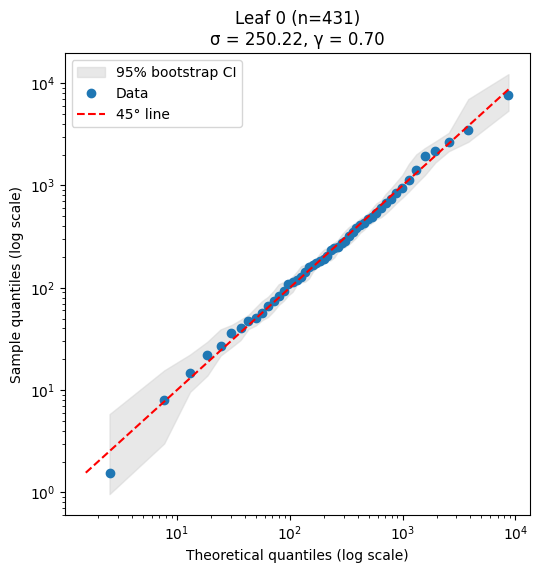

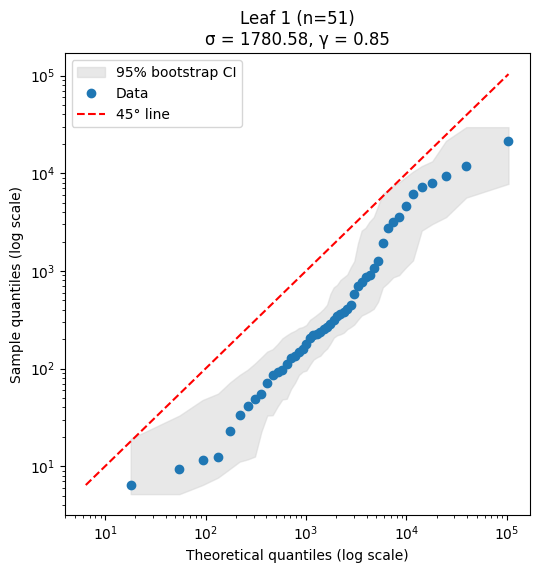

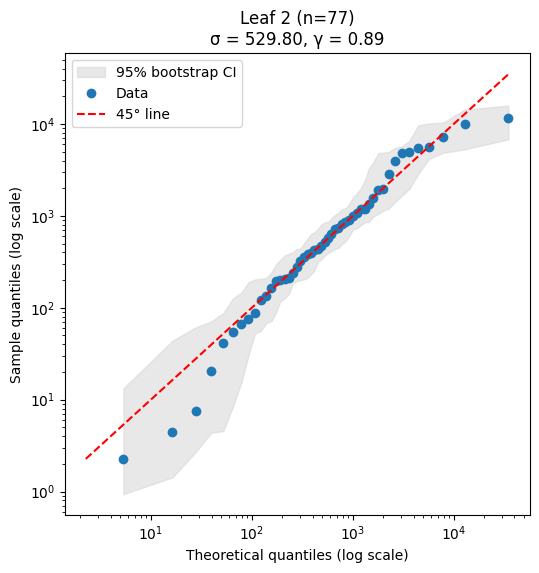

In [94]:
plot_gp_tree_qq(gpd_tail_tree_pruned, X_tail, y_tail)


##pruned

In [ ]:
feature_names=['Three_Component_Index_lag1',
       'News_Based_Policy_Uncert_Index_lag1',
       '1. Economic Policy Uncertainty_lag1', '2. Monetary policy_lag2',
       'Fiscal Policy (Taxes OR Spending)_lag1', '3. Taxes_lag1',
       '5. Health care_lag1', '6. National security_lag1',
       '7. Entitlement programs_lag1', '8. Regulation_lag1',
       'Financial Regulation_lag1', '9. Trade policy_lag2',
       '10. Sovereign debt, currency crises_lag3',
       'House Price Index_diff_lag2', 'CPI_diff_lag2', 'Close_diff_lag2',
       'Category_Business Disruption and System Failures',
       'Category_Clients, Products & Business Practices',
       'Category_Damage to Physical Assets',
       'Category_Employment Practices and Workplace Safety',
       'Category_Execution, Delivery & Process Management',
       'Category_External Fraud', 'Category_Internal Fraud',
       'Category_Commercial Banking', 'Category_Corporate Finance',
       'Category_Health Insurance',
       'Category_Life Insurance and Benefit Plans',
       'Category_Merchant Banking', 'Category_Municipal/Government Finance',
       'Category_Private Banking', 'Category_Property and Casualty Insurance',
       'Category_Reinsurance', 'Category_Retail Banking']

In [ ]:
def merge_small_leaves_gpd(root: NodeGPD,
                           X: np.ndarray,
                           y: np.ndarray,
                           merge_threshold: int = 100) -> NodeGPD:
    """
    Bottom-up 방식으로 작은 리프를 부모 노드로 병합합니다.
      - root: prune_gpd_with_cv 등으로 미리 pruning 된 트리
      - X, y: Tail (초과치) 데이터
      - merge_threshold: 최소 샘플 수 기준
    """
    n = len(y)

    # 1) 모든 샘플을 현재 리프에 할당
    leaves = _get_all_leaves(root)  # 기존 함수 활용
    leaf_of = np.empty(n, dtype=int)
    for i in range(n):
        leaf = find_leaf(root, X[i])  # find_leaf_gpd 대신 범용 find_leaf 사용
        leaf_of[i] = leaves.index(leaf)
    leaf_idx_map = {i: np.where(leaf_of == i)[0] for i in range(len(leaves))}

    # 2) internal nodes (leaf가 아닌 노드만)
    internal_nodes = []
    def collect_internals(node):
        if not node.is_leaf:
            internal_nodes.append(node)
            if node.left:  collect_internals(node.left)
            if node.right: collect_internals(node.right)
    collect_internals(root)

    # 3) bottom-up 병합
    merged = True
    while merged:
        merged = False
        for node in internal_nodes:
            # Left/Right 가 둘 다 존재하고, 둘 다 leaf 여야 병합 가능
            if node.left is None or node.right is None:
                continue
            if not (node.left.is_leaf and node.right.is_leaf):
                continue

            # 각 자식 leaf_id
            left_id  = leaves.index(node.left)
            right_id = leaves.index(node.right)
            idx_l = leaf_idx_map.get(left_id, [])
            idx_r = leaf_idx_map.get(right_id, [])

            # 병합 기준 미만이면 병합
            if min(len(idx_l), len(idx_r)) < merge_threshold:
                combined_idx = np.concatenate([idx_l, idx_r])
                # 파라미터 재적합
                theta = fit_gpd_mle(y[combined_idx])
                nll   = neg_loglik_gpd((theta[0], theta[1]), y[combined_idx])

                # 부모 노드를 leaf로 전환
                node.is_leaf    = True
                node.split_var  = None
                node.split_thr  = None
                node.left       = None
                node.right      = None
                node.gpd_params = theta
                node.nll        = nll

                # leaf 리스트/맵 갱신
                # 기존 child leaf entries 삭제
                leaf_idx_map.pop(left_id, None)
                leaf_idx_map.pop(right_id, None)
                # 새로운 leaf id 추가
                new_id = max(leaf_idx_map.keys(), default=-1) + 1
                leaves.append(node)
                leaf_idx_map[new_id] = combined_idx

                merged = True
                break

    return root


In [ ]:
# (1) GPD 트리 생성 및 CV-prune
raw_gpd = grow_tree_gpd(X_tail, y_tail, feature_names, min_leaf=50, max_depth=3)
pruned_gpd, best_alpha = prune_gpd_with_cv(raw_gpd, X_tail, y_tail, n_folds=3)

# (2) 작은 리프 병합
merged_gpd = merge_small_leaves_gpd(pruned_gpd, X_tail, y_tail, merge_threshold=1000)

# (3) 결과 확인
print_tree_structure(merged_gpd, feature_names)
validate_tree_structure(merged_gpd)


[House Price Index_diff_lag2 ≤ 0.08087] (PenalizedGain=1509.181) N=77472
  [1. Economic Policy Uncertainty_lag1 ≤ 221.1] (PenalizedGain=669.082) N=67103
    [CPI_diff_lag2 ≤ 0.01495] (PenalizedGain=342.498) N=65213
      Leaf: N=4399, GPD(σ=126.572, γ=0.950), NLL=30582.9
      Leaf: N=60814, GPD(σ=262.581, γ=0.727), NLL=443798.0
    Leaf: N=1890, GPD(σ=1949.619, γ=0.659), NLL=16917.3
  [House Price Index_diff_lag2 ≤ 0.09859] (PenalizedGain=149.559) N=10369
    Leaf: N=3168, GPD(σ=468.839, γ=0.662), NLL=24748.6
    Leaf: N=7201, GPD(σ=803.361, γ=0.756), NLL=60812.9


True

In [ ]:
gp_tree_lrt(merged_gpd, X_tail, y_tail)


GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -576859.72
  단일 GP 로그우도: -634390.19
  LRT statistic = 115060.94 (df = 8)
  p‑value = 0.000e+00 -> reject single GP model
  AIC (GP 트리) = 1153739.43, AIC (단일 GP) = 1268784.38


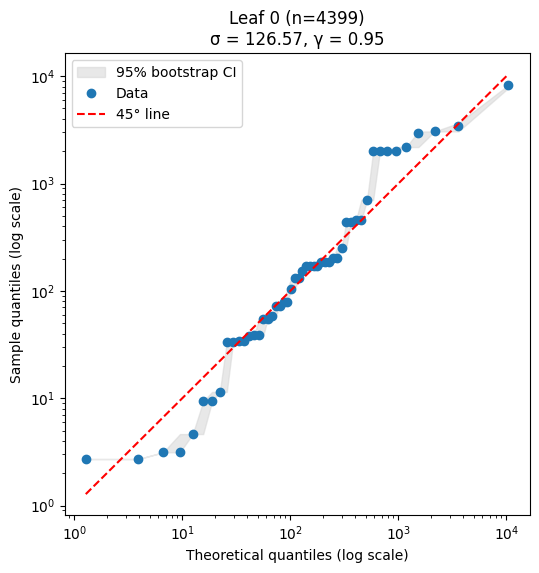

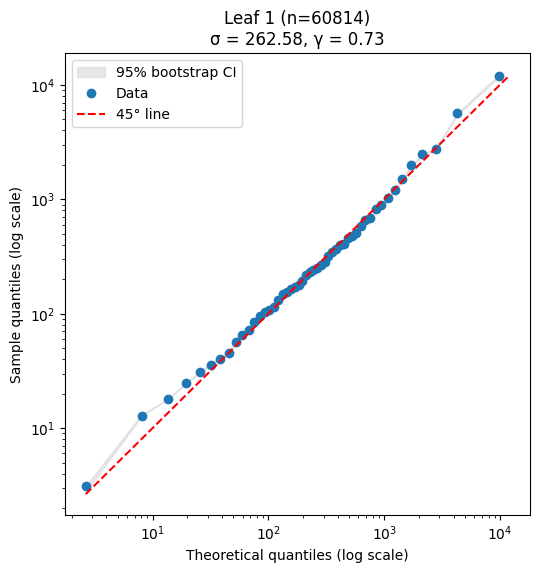

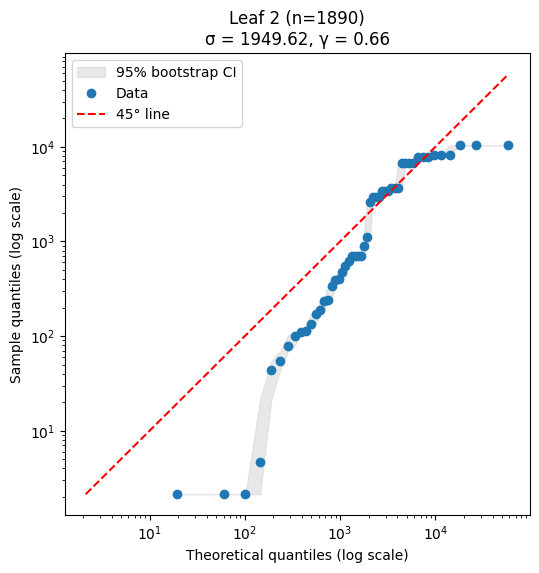

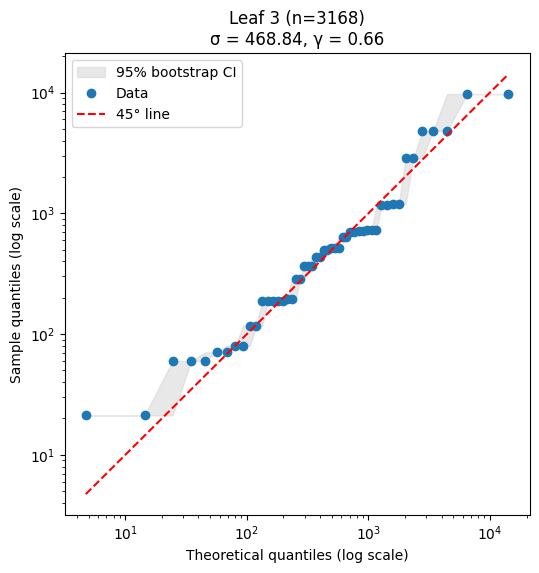

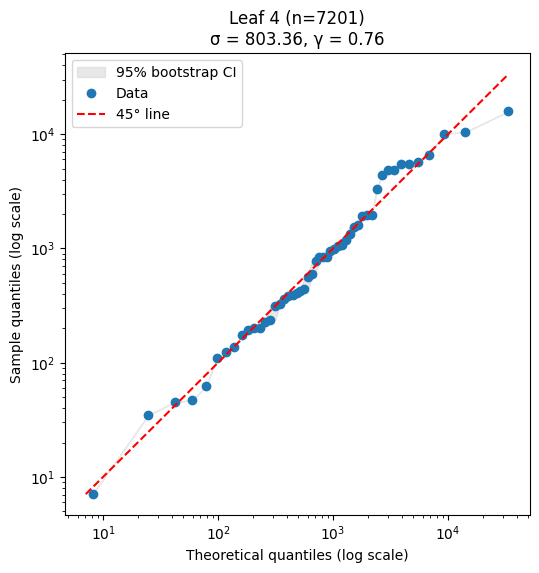

In [ ]:
plot_gp_tree_qq(merged_gpd, X_tail, y_tail)


In [ ]:
import pickle

# --- __main__ 블록 마지막에 추가 ---
save_path = '/content/drive/MyDrive/Operational_risk/'
# 1) 저장할 객체들 모으기
output = {
    # Bulk 트리
    'l1_bulk_tree' : l1_bulk_tree,
    'l2_bulk_tree' : l2_bulk_tree,
    # Tail 트리
    'gpd_raw_tree' : gpd_tail_tree_raw,
    'gpd_pruned_tree' : gpd_tail_tree_pruned,
    'merged_gpd ' : merged_gpd,
    # 데이터
    'X_bulk'       : X_bulk,
    'y_bulk'       : y_bulk,
    'X_tail'       : X_tail,
    'y_tail'       : y_tail,
    'X_all_data'   : X_all_data,
    'y_all_data'   : y_all_data,
    'df_model_ready':df_model_ready,
    # (선택) 피처 이름
    'feature_names': feature_names_list,
    # (선택) 임계값
    'u_threshold'  : u_threshold
}

# 2) 피클 파일로 저장
with open(save_path + 'risk_1985_2021_fixed.pkl', 'wb') as f:
    pickle.dump(output, f)

logging.info("Models and data have been saved to 'risk_1985_2021_fixed.pkl'")


In [ ]:
import pickle

with open(save_path +'risk_1985_2021.pkl', 'rb') as f:
    loaded = pickle.load(f)

# 꺼내쓰기
l1_tree = loaded['l1_bulk_tree']
X_bulk  = loaded['X_bulk']
y_bulk  = loaded['y_bulk']
X_all_data= loaded['X_all_data']
y_all_data= loaded['y_all_data']
feature_names_list= loaded['feature_names']
u_threshold= loaded['u_threshold']
# … 기타 등등


In [ ]:
# import joblib

# with open(save_path +'ev_cart_models_and_data.pkl', 'rb') as f:
#     data = pickle.load(f)

# joblib.dump(data, 'ev_cart_models_and_data_new.joblib')  # safer format


['ev_cart_models_and_data_new.joblib']

In [ ]:
# # 예: tree 객체 대신, 순수한 리스트/딕트 구조로 변환
# serializable = {
#     'bulk_tree_leaves': [leaf.__dict__ for leaf in _get_all_leaves(l1_bulk_tree)],
#     'tail_tree_leaves': [leaf.__dict__ for leaf in _get_all_leaves(gpd_tail_tree_pruned)],
#     'X_all': X_all_data,
#     'y_all': y_all_data,
# }
# joblib.dump(serializable, 'safe_data.joblib')


['safe_data.joblib']

#forecast

In [ ]:
# # time_based_train_test.py

# import numpy as np
# import pandas as pd
# import logging
# from typing import Dict, List, Optional, Tuple, Union

# # (이하 필요한 extreme‐value CART 함수들: grow_tree_l1, grow_tree_gpd,
# #  assign_lognorm_params, prune_gpd_with_cv, find_leaf, truncated_lognormal_mean 등
# #  은 미리 정의되어 있다고 가정합니다.)

# # ────────────────────────────────────────
# # 1) Lag 함수: _year_ 컬럼을 최종 DF에 포함
# # ────────────────────────────────────────
# def create_lagged_features(
#     df: pd.DataFrame,
#     target_col: str,
#     lag_config: Dict[str, List[int]],
#     date_col: str = "Date",
#     start_year: Optional[int] = None,
#     additional_features: Optional[List[str]] = None
# ) -> Tuple[pd.DataFrame, List[str]]:
#     df_proc = df.copy()

#     # 1. 연도 추출
#     if pd.api.types.is_datetime64_any_dtype(df_proc[date_col]):
#         df_proc["_year_"] = df_proc[date_col].dt.year
#     else:
#         df_proc["_year_"] = pd.to_datetime(df_proc[date_col], errors="coerce").dt.year
#     # 시작 연도 필터
#     if start_year is not None:
#         df_proc = df_proc[df_proc["_year_"] >= start_year]

#     # 2. lagged features 생성
#     lagged_feature_names = []
#     for var, lags in lag_config.items():
#         if var not in df_proc.columns:
#             logging.warning(f"'{var}' not in DataFrame columns, skipping lag.")
#             continue
#         for lag in lags:
#             if lag <= 0:
#                 logging.warning(f"Non-positive lag {lag} for '{var}', skipping.")
#                 continue
#             new_col = f"{var}_lag{lag}"
#             df_proc[new_col] = df_proc[var].shift(lag)
#             lagged_feature_names.append(new_col)

#     # 3. 최종에 포함할 컬럼
#     final_cols = ["_year_", target_col] + lagged_feature_names
#     if additional_features:
#         for col in additional_features:
#             if col in df_proc.columns:
#                 final_cols.append(col)
#             else:
#                 logging.warning(f"Additional feature '{col}' not found, skipping.")

#     # 4. NA 제거 및 반환
#     final_df = df_proc[final_cols].dropna().copy()
#     feature_names = [c for c in final_df.columns if c not in [target_col, "_year_"]]
#     logging.info(f"Lagged dataset: {final_df.shape[0]} rows, {len(feature_names)} features.")
#     return final_df, feature_names

# # ────────────────────────────────────────
# # 2) Main: train/test by year, 모델 학습 → 2020 예측 평가
# # ────────────────────────────────────────
# if __name__ == "__main__":
#     logging.basicConfig(level=logging.INFO)

#     # --- 설정 부분 ---
#     TARGET_VARIABLE = "Exceedance"
#     DATE_COLUMN     = "Date"
#     START_YEAR      = 1985
#     U_THRESHOLD     = 2200.0

#     # Granger‐based lag 설정 예시
#     selected_lags = {
#         'Three_Component_Index': [1],
#         'News_Based_Policy_Uncert_Index': [1],
#         "1. Economic Policy Uncertainty": [1],
#         '2. Monetary policy': [2],
#         "Fiscal Policy (Taxes OR Spending)": [1],
#         "3. Taxes": [1],
#         "5. Health care": [1],
#         "6. National security": [1],
#         "7. Entitlement programs": [1],
#         "8. Regulation": [1],
#         "Financial Regulation": [1],
#         "9. Trade policy": [2],
#         "10. Sovereign debt, currency crises": [3],
#         "House Price Index_diff": [2],
#         "CPI_diff": [2],
#         "Close_diff": [2]
#     }

#     # Categorical features (assumed to be 0/1 dummy encoded)
#     categorical_cols = [
#         'Category_Business Disruption and System Failures',
#         'Category_Clients, Products & Business Practices',
#         'Category_Damage to Physical Assets',
#         'Category_Employment Practices and Workplace Safety',
#         'Category_Execution, Delivery & Process Management',
#         'Category_External Fraud', 'Category_Internal Fraud',
#         'Category_Commercial Banking', 'Category_Corporate Finance',
#         'Category_Health Insurance',
#         'Category_Life Insurance and Benefit Plans',
#         'Category_Merchant Banking', 'Category_Municipal/Government Finance',
#         'Category_Private Banking', 'Category_Property and Casualty Insurance',
#         'Category_Reinsurance', 'Category_Retail Banking'
#     ]

#     # --- 데이터 로드 또는 생성 ---
#     try:
#         df_merged = df_merged
#     except:
#         logging.warning("df_merged not found, generating synthetic data.")
#         n_years = 42
#         dates = pd.date_range(start="1980-01-01", periods=n_years, freq="YS")
#         data = {"Date": dates}
#         all_cols = list(selected_lags.keys()) + categorical_cols + [TARGET_VARIABLE]
#         for col in all_cols:
#             if col == TARGET_VARIABLE:
#                 data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
#             elif col.startswith("Category_"):
#                 data[col] = np.random.randint(0, 2, size=n_years)
#             else:
#                 data[col] = np.random.randn(n_years).cumsum() + 100
#         df_merged = pd.DataFrame(data)

#     # --- Lagged features 생성 ---
#     df_ready, feature_names = create_lagged_features(
#         df=df_merged,
#         target_col=TARGET_VARIABLE,
#         lag_config=selected_lags,
#         date_col=DATE_COLUMN,
#         start_year=START_YEAR,
#         additional_features=categorical_cols
#     )

#     # --- Train/Test 분리 (연도 기준) ---
#     df_train = df_ready[df_ready["_year_"] <= 2019].copy()
#     df_test  = df_ready[df_ready["_year_"] == 2020].copy()

#     X_train = df_train[feature_names].values
#     y_train = df_train[TARGET_VARIABLE].values
#     X_test  = df_test[feature_names].values
#     y_test  = df_test[TARGET_VARIABLE].values

#     logging.info(f"Train years ≤2019: {len(y_train)} samples, Test 2020: {len(y_test)} samples.")

#     # --- Bulk/Tail 분리 (Train) ---
#     mask_bulk = y_train <= U_THRESHOLD
#     Xb_tr, yb_tr = X_train[mask_bulk], y_train[mask_bulk]
#     Xt_tr, yt_tr = X_train[~mask_bulk], y_train[~mask_bulk] - U_THRESHOLD

#     # -- 1) Bulk 모델 학습 (L1 CART + LogNormal) ---
#     logging.info("Training L1 CART (Bulk)...")
#     l1_tree = grow_tree_l1(Xb_tr, yb_tr, feature_names, min_leaf=20, max_depth=3)
#     assign_lognorm_params(l1_tree, Xb_tr, yb_tr, trunc_left=U_THRESHOLD)

#     # -- 2) Tail 모델 학습 (GPD CART + Pruning) ---
#     logging.info("Training GPD CART (Tail)...")
#     raw_gpd = grow_tree_gpd(Xt_tr, yt_tr, feature_names, min_leaf=15, max_depth=4)
#     gpd_tree, best_alpha = prune_gpd_with_cv(raw_gpd, Xt_tr, yt_tr, n_folds=5)
#     logging.info(f"Pruned GPD alpha = {best_alpha:.4g}")

#     # --- 3) 2020년 예측 ---
#     def predict_severity(x_vec: np.ndarray, y_obs: float) -> float:
#         if y_obs <= U_THRESHOLD:
#             leaf = find_leaf(l1_tree, x_vec)
#             return truncated_lognormal_mean(
#                 leaf.lognorm_mu, leaf.lognorm_sigma, U_THRESHOLD
#             )
#         else:
#             leaf = find_leaf(gpd_tree, x_vec)
#             σ, γ = leaf.gpd_params
#             return U_THRESHOLD + σ / (1 - γ)

#     y_pred = np.array([
#         predict_severity(x, y)
#         for x, y in zip(X_test, y_test)
#     ])

#     # --- 4) 평가 지표 ---
#     mae  = np.mean(np.abs(y_pred - y_test))
#     mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100

#     print(f"2020년 예측 → MAE: {mae:.2f}, MAPE: {mape:.2f}%")


2020년 예측 → MAE: 3675.08, MAPE: 104.39%


#Non-epu

In [95]:
"""
========================================================================
  EXTREME-VALUE CART TOOLBOX (Improved Version)
  · L1 CART (median) + Leaf-wise LogNormal
  · L2 CART (mean)   + Leaf-wise LogNormal
  · Hill-plot based threshold (u) auto-estimation (stabilized)
  · GPD CART + CV-pruning (node NLL recalculation, 1-pass)
  assign_lognorm_params
========================================================================
"""
import numpy as np
import pandas as pd
import logging
from scipy.optimize import minimize
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
from scipy import stats
import copy
from typing import Tuple, List, Optional, Dict, Any, Union
import math

# ---------------------------------------------------------------------#
# Logging Setup
# ---------------------------------------------------------------------#
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# ---------------------------------------------------------------------#
# Constants
# ---------------------------------------------------------------------#
# SEED = 42
# np.random.seed(SEED)
# MIN_FLOAT = 1e-9 # Small number to avoid division by zero etc.
# LARGE_FLOAT = 1e15 # Large number for infinite costs/NLL

FLT_INFO = np.finfo(float)

SEED        = 42
rng         = np.random.default_rng(SEED)     # 전역 RandomGenerator
MIN_FLOAT   = FLT_INFO.eps                    # ≈2.22e‑16
LARGE_FLOAT = 1e30

# ---------------------------------------------------------------------#
# 0. Utility Functions
# ---------------------------------------------------------------------#
def mse_loss(y: np.ndarray, mu: float) -> float:
    """Calculate Mean Squared Error."""
    if len(y) == 0:
        return 0.0
    return np.sum((y - mu) ** 2)

def mae_loss(y: np.ndarray, md: float) -> float:
    """Calculate Mean Absolute Error."""
    if len(y) == 0:
        return 0.0
    return np.sum(np.abs(y - md))

# ---------------------------------------------------------------------#
# Base Node Class and Specific Nodes
# ---------------------------------------------------------------------#
class NodeBase:
    """Base class for all nodes in the trees."""
    __slots__ = ("is_leaf", "split_var", "split_thr", "gain", "left", "right", "depth", "n_samples")

    def __init__(self):
        self.is_leaf: bool = True
        self.split_var: Optional[int] = None
        self.split_thr: Optional[float] = None
        self.gain: float = 0.0
        self.left: Optional['NodeBase'] = None
        self.right: Optional['NodeBase'] = None
        self.depth: int = 0
        self.n_samples: int = 0 # Keep track of samples in the node

class NodeL1(NodeBase):
    """Node for L1 CART (median-based)."""
    __slots__ = ("median_val", "lognorm_mu", "lognorm_sigma")

    def __init__(self):
        super().__init__()
        self.median_val: Optional[float] = None
        self.lognorm_mu: Optional[float] = None
        self.lognorm_sigma: Optional[float] = None

class NodeL2(NodeBase):
    """Node for L2 CART (mean-based)."""
    __slots__ = ("mean_val", "lognorm_mu", "lognorm_sigma")

    def __init__(self):
        super().__init__()
        self.mean_val: Optional[float] = None
        self.lognorm_mu: Optional[float] = None
        self.lognorm_sigma: Optional[float] = None

class NodeGPD(NodeBase):
    """Node for GPD CART."""
    __slots__ = ("gpd_params", "nll", "split_gain") # Inherits others via super().__init__()

    def __init__(self):
        super().__init__() # Initializes is_leaf, split_var, split_thr, left, right, depth, n_samples
        # Note: 'gain' from NodeBase is repurposed as 'split_gain' here for clarity in GPD context
        self.split_gain: float = 0.0 # Gain used for splitting decision (AIC penalized)
        self.gpd_params: Optional[Tuple[float, float]] = None # (sigma, gamma)
        self.nll: Optional[float] = None # Negative Log-Likelihood at this node



def _nll_lognormal(params: Tuple[float, float],
                   y: np.ndarray,
                   *, trunc_left: float = 0.0) -> float:
    """
    Negative Log‑Likelihood for (optionally *left‑truncated*) LogNormal.
    trunc_left = 0  → 일반 LogNormal
    trunc_left = u  → P(Y>u) 로 조건부화한 LogNormal
    """
    mu, sigma = params
    if sigma <= MIN_FLOAT:
        return LARGE_FLOAT

    y_pos = y[y > 0]
    if y_pos.size == 0:
        return LARGE_FLOAT

    log_y = np.log(y_pos)
    z     = (log_y - mu) / sigma
    base  = np.sum(np.log(sigma) + 0.5*np.log(2*np.pi) + 0.5*z**2 + log_y)

    if trunc_left > 0:
        # S = survival func  = P(Y>u) = 1 - Φ((ln u - μ)/σ)
        zc   = (np.log(trunc_left) - mu) / sigma
        surv = 1.0 - 0.5*(1 + math.erf(zc/np.sqrt(2)))
        if surv <= 0:
            return LARGE_FLOAT
        base -= y_pos.size * np.log(surv)

    return base if np.isfinite(base) else LARGE_FLOAT



def fit_lognormal_mle(y: np.ndarray, *, trunc_left: float = 0.0
                      ) -> Tuple[float, float]:
    """MLE for (optionally left‑truncated) LogNormal → (μ̂, σ̂)."""
    y_pos = y[y > 0]
    n_pos = y_pos.size
    if n_pos < 2:
        if n_pos == 1:
            return float(np.log(y_pos[0])), MIN_FLOAT*10
        return 0.0, 1.0

    log_y = np.log(y_pos)
    init   = [log_y.mean(), max(log_y.std(), MIN_FLOAT*10)]
    bounds = [(None, None), (MIN_FLOAT*10, None)]

    obj = lambda p: _nll_lognormal(p, y_pos, trunc_left=trunc_left)

    try:
        res = minimize(obj, init, method="L-BFGS-B", bounds=bounds)
        if res.success and np.all(np.isfinite(res.x)):
            μ, σ = res.x
            σ = max(σ, MIN_FLOAT*100)
            return float(μ), float(σ)
    except Exception as e:
        logging.debug(f"LogNormal MLE failed: {e}")

    return tuple(init)


# ---------------------------------------------------------------------#
# GPD MLE and Cost Function
# ---------------------------------------------------------------------#
def neg_loglik_gpd(theta: Tuple[float, float], y: np.ndarray) -> float:
    """
    Calculate negative log-likelihood for Generalized Pareto Distribution (GPD).
    Handles the case gamma -> 0 (Exponential distribution limit).
    """
    sigma, gamma = theta
    n = len(y)
    if n == 0:
        return 0.0
    if sigma <= MIN_FLOAT: # Sigma must be positive
        return LARGE_FLOAT

    # Handle Exponential distribution case (gamma ≈ 0)
    if abs(gamma) < 1e-6:
        if np.any(y < 0): # Exponential is for non-negative values
             return LARGE_FLOAT
        nll = n * np.log(sigma) + np.sum(y) / sigma
    else:
        # Standard GPD case
        z = 1 + gamma * y / sigma
        if np.any(z <= MIN_FLOAT): # Argument of log must be positive
            return LARGE_FLOAT
        # Correct GPD log-likelihood: sum(log(sigma) + (1/gamma + 1) * log(z))
        nll = n * np.log(sigma) + (1 / gamma + 1) * np.sum(np.log(z))

    # Check for non-finite results which can break optimization
    if not np.isfinite(nll):
        return LARGE_FLOAT
    return nll
def fit_gpd_mle(y: np.ndarray,
                *, gamma_bounds: Tuple[float, float] = (-0.5, 0.95)) -> np.ndarray:
    """
    Stabilized GPD MLE fitting.
    - Returns [sigma, gamma].
    - Uses PWM for initialization.
    - Applies boundary penalties.
    - Enforces sigma lower bound.
    - Handles small samples.
    """
    bounds = [(MIN_FLOAT*10, None), gamma_bounds]
    n = len(y)
    # 0) Handle very small samples
    if n < 30:
        # Fallback: Use median for scale, slightly negative shape
        # Ensure sigma is positive
        fallback_sigma = max(np.median(y), MIN_FLOAT * 10) if n > 0 else 1.0
        return np.array([fallback_sigma, -0.2])

    # 1) Probability-Weighted Moments (PWM) initial estimate
    y_sorted = np.sort(y)
    # Use unbiased PWM estimators if available, otherwise simple moments
    # For simplicity here, use sample mean and median heuristic
    y_bar = np.mean(y)
    y_med = np.median(y)
    # Heuristic initial gamma (can be unstable, hence clipping)
    gamma0_raw = (y_bar - 2.0 * y_med) / (y_bar - y_med + MIN_FLOAT)
    gamma0 = np.clip(gamma0_raw, -0.4, 0.9) # Clip to reasonable range
    # Initial sigma based on gamma0 and mean, ensuring positivity
    sigma0 = max(abs(gamma0) * y_bar if abs(gamma0) > 1e-4 else y_bar, MIN_FLOAT * 10) # Use y_bar if gamma near 0

    init_params = np.array([sigma0, gamma0])

    # 2) Optimization settings
    #bounds = [(MIN_FLOAT * 10, None), (-0.5, 0.95)] # Sigma > 0, Gamma constrained

    def objective_with_penalty(theta: np.ndarray, data: np.ndarray) -> float:
        """Objective function with boundary penalties for GPD NLL."""
        s, g = theta
        base_nll = neg_loglik_gpd(theta, data)
        penalty = 0.0
        # Penalize being too close to boundaries where optimization might struggle
        if abs(g) < 1e-4 or abs(g + 0.5) < 1e-3 or abs(g - 0.95) < 1e-3:
            penalty = 1e2 # Fixed penalty, could be adaptive

        # Penalize non-finite NLL heavily
        if not np.isfinite(base_nll):
             return LARGE_FLOAT

        return base_nll + penalty

    # 3) Run L-BFGS-B optimizer
    try:
        res = minimize(
            objective_with_penalty,
            x0=init_params,
            args=(y,),
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": 200, "ftol": 1e-9, "eps": 1e-7}, # Added eps for numerical differentiation
        )

        # 4) Check success and enforce sigma lower bound
        if res.success and np.isfinite(res.fun):
            s_opt, g_opt = res.x
            # Ensure sigma meets the minimum requirement
            final_sigma = max(s_opt, MIN_FLOAT * 10)
            return np.array([final_sigma, g_opt])
        else:
             logging.debug(f"GPD MLE optimization failed (Status: {res.status}, Msg: {res.message}). Returning PWM init.")
             # Fallback to initial estimate if optimization failed
             return init_params

    except (ValueError, RuntimeWarning, Exception) as e:
        logging.debug(f"GPD MLE failed with error: {e}. Returning PWM init: {init_params}")
        # Fallback to initial estimate on any exception
        return init_params

def node_cost_gpd(y: np.ndarray) -> Tuple[float, np.ndarray]:
    """
    Calculate node cost (NLL) and parameters for GPD.
    Returns (cost, [sigma, gamma]). Handles failures gracefully.
    """
    if len(y) == 0:
        return 0.0, np.array([1.0, 0.0]) # Default params for empty node

    try:
        theta = fit_gpd_mle(y)
        cost = neg_loglik_gpd(theta, y)

        # If cost is non-finite, return a large cost and the estimated (possibly bad) theta
        if not np.isfinite(cost):
            logging.debug(f"Non-finite GPD cost ({cost}) for theta={theta}. Returning large cost.")
            return LARGE_FLOAT, theta
        return cost, theta
    except Exception as e:
        # Broad exception catch during cost calculation (should be rare if fit_gpd_mle is robust)
        logging.warning(f"Error during node_cost_gpd: {e}. Returning large cost.")
        # Provide default parameters in case of complete failure
        fallback_sigma = max(np.median(y), MIN_FLOAT * 10) if len(y) > 0 else 1.0
        fallback_theta = np.array([fallback_sigma, -0.2])
        return LARGE_FLOAT, fallback_theta




# ---------------------------------------------------------------------#
# 2. CART Splitting Functions
# ---------------------------------------------------------------------#
def _best_split_l1(x: np.ndarray, y: np.ndarray, min_leaf: int = 1
                   ) -> Tuple[float, Optional[float]]:
    """Find the best split point for a node in L1 CART (median-based)."""
    n = len(y)
    if n < 2 * min_leaf: # Cannot split if not enough samples
        return 0.0, None

    # Sort data by the feature x
    idx = np.argsort(x)
    xs, ys = x[idx], y[idx]

    parent_median = np.median(ys)
    parent_loss = mae_loss(ys, parent_median)
    best_gain, best_thr = 0.0, None

    # Iterate through possible split points
    # A split occurs between i-1 and i
    for i in range(min_leaf, n - min_leaf ):
        # Only consider splits where x value changes
        if xs[i] == xs[i - 1]:
            continue

        # Calculate loss for left and right children
        left_y, right_y = ys[:i], ys[i:]
        median_l = np.median(left_y)
        median_r = np.median(right_y)
        child_loss = mae_loss(left_y, median_l) + mae_loss(right_y, median_r)

        # Calculate gain
        gain = parent_loss - child_loss

        # Update best split if current gain is higher
        if gain > best_gain:
            best_gain = gain
            # Threshold is midpoint between the two x values
            best_thr = 0.5 * (xs[i] + xs[i - 1])

    # Avoid negligible gains
    if best_gain < MIN_FLOAT:
        return 0.0, None

    return best_gain, best_thr

def _best_split_l2(x: np.ndarray, y: np.ndarray, min_leaf: int = 1
                   ) -> Tuple[float, Optional[float]]:
    """Find the best split point for a node in L2 CART (mean-based) efficiently."""
    n = len(y)
    if n < 2 * min_leaf:
        return 0.0, None

    # Sort data by the feature x
    idx = np.argsort(x)
    xs, ys = x[idx], y[idx]

    # Calculate parent loss (variance * n)
    parent_mean = np.mean(ys)
    parent_loss = mse_loss(ys, parent_mean) # Equivalent to np.sum((ys - parent_mean)**2)

    # Precompute cumulative sums for efficiency
    csum = np.cumsum(ys)
    csq = np.cumsum(ys ** 2)
    total_sum, total_sq = csum[-1], csq[-1]

    best_gain, best_thr = 0.0, None

    # Iterate through possible split points (between i-1 and i)
    for i in range(min_leaf, n - min_leaf): # Ensure children have at least min_leaf samples
        if xs[i] == xs[i - 1]: # Skip if x value hasn't changed
            continue

        # Left child calculations
        sum_l = csum[i - 1]
        sum_sq_l = csq[i - 1]
        cnt_l = i
        mean_l = sum_l / cnt_l
        # Loss_l = sum(y_l^2) - n_l * mean_l^2 (more stable form of sum((y_l-mean_l)^2))
        loss_l = sum_sq_l - cnt_l * (mean_l ** 2)

        # Right child calculations
        sum_r = total_sum - sum_l
        sum_sq_r = total_sq - sum_sq_l
        cnt_r = n - cnt_l
        mean_r = sum_r / cnt_r
        loss_r = sum_sq_r - cnt_r * (mean_r ** 2)

        # Total loss of children
        child_loss = loss_l + loss_r

        # Gain is reduction in impurity (sum of squares)
        gain = parent_loss - child_loss

        # Update best split
        if gain > best_gain:
            best_gain = gain
            best_thr = 0.5 * (xs[i] + xs[i - 1])

    # Avoid negligible gains
    if best_gain < MIN_FLOAT:
         return 0.0, None

    return best_gain, best_thr

def _best_split_gpd(x: np.ndarray, y: np.ndarray, min_leaf: int = 30,
                    penalty: float = 2.0) -> Tuple[float, Optional[float]]:
    """
    Finds the best split point for a node in GPD-CART using NLL reduction.
    - Uses AIC-like penalty for complexity.
    - Returns (penalized_gain, threshold).
    """
    n = len(y)
    if n < 2 * min_leaf: # Cannot split
        return 0.0, None

    # Sort by feature x
    idx = np.argsort(x)
    xs, ys = x[idx], y[idx]

    # Calculate parent node NLL (cost)
    parent_nll, _ = node_cost_gpd(ys)
    if not np.isfinite(parent_nll): # Cannot split if parent cost is invalid
         logging.warning("Parent GPD NLL is not finite. Cannot split.")
         return 0.0, None

    best_gain, best_thr = -LARGE_FLOAT, None # Initialize gain to very small value

    # Iterate through potential split points
    for i in range(min_leaf, n - min_leaf): # Ensure children meet min_leaf size
        if xs[i] == xs[i - 1]: # Skip if x value is the same
            continue

        left_y, right_y = ys[:i], ys[i:]

        # Calculate NLL for potential children
        l_nll, _ = node_cost_gpd(left_y)
        r_nll, _ = node_cost_gpd(right_y)

        # Check if child NLLs are valid
        if not (np.isfinite(l_nll) and np.isfinite(r_nll)):
            continue # Skip split if children fitting failed

        # Calculate AIC-penalized gain: Gain = ParentNLL - ChildNLL_Sum - Penalty
        # Higher gain is better (means larger reduction in NLL relative to penalty)
        gain = parent_nll - (l_nll + r_nll) - penalty*4

        if gain > best_gain:
            best_gain = gain
            best_thr = 0.5 * (xs[i] + xs[i - 1])

    # Only return a split if the penalized gain is positive
    if best_gain <= 0: # Changed from < MIN_FLOAT to <= 0 for AIC penalty logic
        return 0.0, None

    return best_gain, best_thr


# ---------------------------------------------------------------------#
# 3. Tree Growing Functions
# ---------------------------------------------------------------------#
def grow_tree_l1(X: np.ndarray, y: np.ndarray, feature_names: List[str],
                 min_leaf: int = 20, max_depth: int = 3, depth: int = 0) -> NodeL1:
    """Grows an L1 CART (median-based) recursively."""
    n_samples, n_features = X.shape
    node = NodeL1()
    node.depth = depth
    node.n_samples = n_samples
    node.median_val = np.median(y) if n_samples > 0 else 0.0

    # Stopping conditions
    if n_samples < 2 * min_leaf or depth >= max_depth or n_samples == 0:
        return node # Return leaf node

    best_gain, best_var, best_thr = -1.0, None, None # Initialize gain to negative

    # Find the best split across all features
    for j in range(n_features):
        gain, thr = _best_split_l1(X[:, j], y, min_leaf)
        if thr is not None and gain > best_gain:
            best_gain = gain
            best_var = j
            best_thr = thr

    # If no beneficial split is found (gain <= 0 or no threshold)
    if best_thr is None or best_gain <= MIN_FLOAT:
        return node # Return leaf node

    # Ensure the split actually divides the data and meets min_leaf requirement
    mask_left = X[:, best_var] <= best_thr
    n_left = np.sum(mask_left)
    n_right = n_samples - n_left

    if n_left < min_leaf or n_right < min_leaf:
        return node # Split doesn't meet min_leaf criteria, make it a leaf

    # Create internal node
    node.is_leaf = False
    node.split_var = best_var
    node.split_thr = best_thr
    node.gain = best_gain

    # Recursively grow children
    logging.debug(f"Depth {depth}: Splitting on '{feature_names[best_var]}' <= {best_thr:.3g}, Gain={best_gain:.3f}, N={n_samples}->({n_left}, {n_right})")
    node.left = grow_tree_l1(X[mask_left], y[mask_left], feature_names, min_leaf, max_depth, depth + 1)
    node.right = grow_tree_l1(X[~mask_left], y[~mask_left], feature_names, min_leaf, max_depth, depth + 1)

    return node

def grow_tree_l2(X: np.ndarray, y: np.ndarray, feature_names: List[str],
                 min_leaf: int = 30, max_depth: int = 4, depth: int = 0) -> NodeL2:
    """Grows an L2 CART (mean-based) recursively."""
    n_samples, n_features = X.shape
    node = NodeL2()
    node.depth = depth
    node.n_samples = n_samples
    node.mean_val = np.mean(y) if n_samples > 0 else 0.0

    # Stopping conditions
    if n_samples < 2 * min_leaf or depth >= max_depth or n_samples == 0:
        return node

    best_gain, best_var, best_thr = -1.0, None, None

    # Find best split
    for j in range(n_features):
        gain, thr = _best_split_l2(X[:, j], y, min_leaf)
        if thr is not None and gain > best_gain:
            best_gain = gain
            best_var = j
            best_thr = thr

    # Check if a valid split was found
    if best_thr is None or best_gain <= MIN_FLOAT:
        return node

    # Verify min_leaf constraint for children
    mask_left = X[:, best_var] <= best_thr
    n_left = np.sum(mask_left)
    n_right = n_samples - n_left

    if n_left < min_leaf or n_right < min_leaf:
        return node

    # Create internal node
    node.is_leaf = False
    node.split_var = best_var
    node.split_thr = best_thr
    node.gain = best_gain

    # Recursive calls
    logging.debug(f"Depth {depth}: Splitting on '{feature_names[best_var]}' <= {best_thr:.3g}, Gain={best_gain:.3f}, N={n_samples}->({n_left}, {n_right})")
    node.left = grow_tree_l2(X[mask_left], y[mask_left], feature_names, min_leaf, max_depth, depth + 1)
    node.right = grow_tree_l2(X[~mask_left], y[~mask_left], feature_names, min_leaf, max_depth, depth + 1)

    return node

def grow_tree_gpd(X: np.ndarray, y: np.ndarray, feature_names: List[str],
                  min_leaf: int = 100, max_depth: int = 3, depth: int = 0) -> NodeGPD:
    """Grows a GPD CART recursively."""
    n_samples, n_features = X.shape
    node = NodeGPD()
    node.depth = depth
    node.n_samples = n_samples

    # Calculate GPD parameters and NLL for the current node
    node.nll, node.gpd_params = node_cost_gpd(y)

    # Stopping conditions
    if n_samples < 2 * min_leaf or depth >= max_depth or n_samples == 0:
         if node.gpd_params is None: # Ensure params exist even for small leaves
              node.nll, node.gpd_params = node_cost_gpd(y) # Try one last time
         logging.debug(f"Depth {depth}: Leaf created (Stop condition). N={n_samples}, NLL={node.nll:.2f}")
         return node

    if node.gpd_params is None or not np.isfinite(node.nll):
         logging.warning(f"Depth {depth}: Leaf created (GPD fit failed). N={n_samples}")
         return node # Cannot split if current node fit failed

    best_gain, best_var, best_thr = -LARGE_FLOAT, None, None

    # Find best split based on penalized NLL reduction
    for j in range(n_features):
        # Using default penalty=2.0 from _best_split_gpd definition
        gain, thr = _best_split_gpd(X[:, j], y, min_leaf)
        if thr is not None and gain > best_gain:
            best_gain = gain
            best_var = j
            best_thr = thr

    # If no split provides positive penalized gain
    if best_thr is None or best_gain <= 0: # Use <= 0 for penalized gain
        logging.debug(f"Depth {depth}: Leaf created (No positive gain split). N={n_samples}, NLL={node.nll:.2f}")
        return node

    # Verify min_leaf constraint for the chosen split
    mask_left = X[:, best_var] <= best_thr
    n_left = np.sum(mask_left)
    n_right = n_samples - n_left

    if n_left < min_leaf or n_right < min_leaf:
        logging.debug(f"Depth {depth}: Leaf created (Split violates min_leaf). N={n_samples}, NLL={node.nll:.2f}")
        return node

    # Create internal node
    node.is_leaf = False
    node.split_var = best_var
    node.split_thr = best_thr
    node.split_gain = best_gain # Store the penalized gain

    # Recursive calls
    logging.debug(f"Depth {depth}: Splitting on '{feature_names[best_var]}' <= {best_thr:.3g}, Penalized Gain={best_gain:.3f}, N={n_samples}->({n_left}, {n_right})")
    node.left = grow_tree_gpd(X[mask_left], y[mask_left], feature_names, min_leaf, max_depth, depth + 1)
    node.right = grow_tree_gpd(X[~mask_left], y[~mask_left], feature_names, min_leaf, max_depth, depth + 1)

    return node

# ---------------------------------------------------------------------#
# 4. Leaf Finding and Parameter Assignment
# ---------------------------------------------------------------------#
def find_leaf(node: Union[NodeL1, NodeL2, NodeGPD], x: np.ndarray) -> Union[NodeL1, NodeL2, NodeGPD]:
    """Finds the leaf node corresponding to a single data point x."""
    current_node = node
    while not current_node.is_leaf:
        if x[current_node.split_var] <= current_node.split_thr:
            current_node = current_node.left
        else:
            current_node = current_node.right
    return current_node

def _get_all_leaves(node: Union[NodeL1, NodeL2, NodeGPD]) -> List[Union[NodeL1, NodeL2, NodeGPD]]:
    """Helper to recursively collect all leaf nodes."""
    leaves = []
    if node.is_leaf:
        leaves.append(node)
    else:
        if node.left:
            leaves.extend(_get_all_leaves(node.left))
        if node.right:
            leaves.extend(_get_all_leaves(node.right))
    return leaves
def assign_lognorm_params(root: Union[NodeL1, NodeL2],
                          X: np.ndarray, y: np.ndarray,
                          *, trunc_left: float = 0.0) -> None:
    """Fit LN(μ,σ) per leaf; supports left truncation."""
    if root is None:
        return

    leaves = _get_all_leaves(root)
    leaf_id = {id(l): i for i, l in enumerate(leaves)}
    leaf_idx = np.array([leaf_id[id(find_leaf(root, x))] for x in X])

    for i, lf in enumerate(leaves):
        y_leaf = y[leaf_idx == i]
        lf.n_samples = y_leaf.size
        if y_leaf.size:
            μ, σ = fit_lognormal_mle(y_leaf, trunc_left=trunc_left)
            lf.lognorm_mu, lf.lognorm_sigma = μ, σ
        else:       # 빈 leaf 방어
            lf.lognorm_mu, lf.lognorm_sigma = 0.0, 1.0
            if isinstance(lf, NodeL1): lf.median_val = 0.0
            if isinstance(lf, NodeL2): lf.mean_val   = 0.0


# Note: assign_lognorm_l1 and assign_lognorm_l2 are now covered by assign_lognorm_params

# ---------------------------------------------------------------------#
# 5. GPD Tree Pruning (Cost-Complexity Pruning with CV)
# ---------------------------------------------------------------------#

def get_subtree_nll(node: NodeGPD, X: np.ndarray, y: np.ndarray) -> float:
    """Calculates the total NLL of data (X, y) evaluated on a GPD subtree."""
    total_nll = 0.0
    n_errors = 0
    if len(X) == 0:
        return 0.0

    for i in range(len(X)):
        xi, yi = X[i], y[i]
        leaf_node = find_leaf(node, xi)

        if leaf_node.gpd_params is None:
            # This shouldn't happen if tree was built correctly, but handle defensively
            total_nll += LARGE_FLOAT
            n_errors += 1
            continue

        sigma, gamma = leaf_node.gpd_params

        # Calculate NLL contribution for this point using the leaf's parameters
        # Re-use neg_loglik_gpd but for a single point (pass y as array of size 1)
        point_nll = neg_loglik_gpd((sigma, gamma), np.array([yi]))

        if not np.isfinite(point_nll):
            total_nll += LARGE_FLOAT # Penalize if point is outside support of fitted GPD
            n_errors += 1
        else:
            total_nll += point_nll

    if n_errors > 0:
         logging.debug(f"Encountered {n_errors}/{len(X)} errors (e.g., y outside GPD support) during NLL calculation.")

    return total_nll

def _get_pruning_sequence(node: NodeGPD) -> List[Tuple[float, NodeGPD]]:
    """Generates potential alpha values and weakest links for pruning."""
    # This computes the g(t) = (R(t) - R(Tt)) / (|Tt| - 1) term for each internal node t
    # R(t) is the NLL at node t, R(Tt) is the sum of NLLs of its descendant leaves
    # |Tt| is the number of leaves in the subtree rooted at t
    sequence = []

    def cost_and_leaves(n: NodeGPD):
        if n.is_leaf:
            return n.nll, 1
        else:
            left_nll_sum, left_leaves = cost_and_leaves(n.left)
            right_nll_sum, right_leaves = cost_and_leaves(n.right)
            total_leaf_nll = left_nll_sum + right_nll_sum
            total_leaves = left_leaves + right_leaves

            # Calculate alpha for this node
            # Avoid division by zero if subtree has only 1 leaf (shouldn't happen for internal)
            if total_leaves > 1 and np.isfinite(n.nll) and np.isfinite(total_leaf_nll):
                 alpha = (n.nll - total_leaf_nll) / (total_leaves - 1)
                 # Only consider non-negative alphas where pruning might improve cost-complexity
                 if alpha >= -MIN_FLOAT: # Allow alpha=0
                      sequence.append((alpha, n)) # Store alpha and the node itself
            else:
                 # If NLLs are invalid or only 1 leaf, assign very large alpha to prevent pruning here
                 sequence.append((LARGE_FLOAT, n))


            return total_leaf_nll, total_leaves

    if not node.is_leaf:
        cost_and_leaves(node)
        # Sort sequence by alpha (weakest links first)
        sequence.sort(key=lambda item: item[0])

    return sequence


def prune_gpd_single_alpha(root: NodeGPD,
                           alpha: float,
                           X: np.ndarray,
                           y: np.ndarray) -> NodeGPD:
    pruned = copy.deepcopy(root)
    def prune_node(node, X_sub, y_sub):
        if node.is_leaf:
            return node
        mask_left = X_sub[:, node.split_var] <= node.split_thr
        node.left  = prune_node(node.left,  X_sub[mask_left],  y_sub[mask_left])
        node.right = prune_node(node.right, X_sub[~mask_left], y_sub[~mask_left])
        if node.left.is_leaf and node.right.is_leaf:
            cost_int = node.left.nll + node.right.nll + alpha
            cost_leaf, theta_leaf = node_cost_gpd(y_sub)
            if cost_leaf <= cost_int:
                node.is_leaf = True
                node.left = node.right = None
                node.split_var = node.split_thr = None
                node.split_gain = 0.0
                node.nll, node.gpd_params = cost_leaf, theta_leaf
        return node
    return prune_node(pruned, X, y)



def prune_gpd_with_cv(root: NodeGPD, X: np.ndarray, y: np.ndarray,
                      n_folds: int = 5, random_state: int = SEED
                      ) -> Tuple[NodeGPD, float]:
    """
    Prunes the GPD tree using cost-complexity pruning with cross-validation
    to find the optimal alpha. Returns the pruned tree and the best alpha.
    (Simplified 1-pass CV approach).
    """
    n_samples = len(y)
    if n_samples < n_folds * 2 or n_samples < 30: # Need enough data for CV
        logging.warning("Dataset too small for reliable CV pruning. Returning unpruned tree.")
        return root, 0.0 # Return original tree with alpha=0

    # 1. Generate sequence of alphas from the full tree
    pruning_sequence = _get_pruning_sequence(root)
    alphas = sorted(list(set([alpha for alpha, node in pruning_sequence if alpha < LARGE_FLOAT])))
    # Include 0 alpha (unpruned tree relative to calculated alphas) and add a slightly larger value
    candidate_alphas = [0.0] + alphas
    if alphas:
         candidate_alphas.append(alphas[-1] * 1.1 + MIN_FLOAT) # Test alpha slightly larger than max found

    logging.info(f"Generated {len(candidate_alphas)} candidate alphas for CV pruning.")

    # 2. Prepare for Cross-Validation
    # Stratification might be useful if y distribution is highly skewed
    # Simple stratification based on median for demonstration
    try:
        y_stratify = (y > np.median(y)).astype(int)
        kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
        folds = list(kf.split(X, y_stratify))
    except ValueError: # Handle cases where stratification fails (e.g., < 2 members in a class)
         logging.warning("Stratified KFold failed, using standard KFold.")
         kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
         folds = list(kf.split(X))


    # 3. Evaluate each alpha using CV
    cv_scores = {alpha: [] for alpha in candidate_alphas}

    for fold_idx, (train_indices, test_indices) in enumerate(folds):
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        if len(y_train) < 20 or len(y_test) == 0: # Skip fold if sets are too small
            logging.warning(f"Skipping CV fold {fold_idx+1} due to small train/test size.")
            continue

        # Build a tree on the training fold *This part is complex if we rebuild for each fold*
        # SIMPLIFICATION for 1-pass: Use the original full tree structure, but prune based on training data NLLs?
        # Or: Prune the original tree and evaluate on test set. Let's use the latter (more common).

        # For each candidate alpha, prune the *original* full tree
        for alpha in candidate_alphas:
            # Prune the original tree using this alpha
            # Need a function that prunes based on the NLL values already in the tree
            pruned_for_alpha = prune_gpd_single_alpha(root, alpha, X_train, y_train)

            # Evaluate this pruned tree on the test set of this fold
            test_nll = get_subtree_nll(pruned_for_alpha, X_test, y_test)
            if np.isfinite(test_nll):
                 cv_scores[alpha].append(test_nll / len(y_test)) # Store average NLL per sample
            else:
                 cv_scores[alpha].append(LARGE_FLOAT) # Penalize failures


    # 4. Select the best alpha
    mean_cv_scores = {alpha: np.mean(scores) for alpha, scores in cv_scores.items() if scores}

    if not mean_cv_scores: # Handle case where all folds failed
         logging.error("CV pruning failed for all alphas. Returning unpruned tree.")
         return root, 0.0

    # Find alpha with the minimum average NLL across folds
    best_alpha = min(mean_cv_scores, key=mean_cv_scores.get)
    min_score = mean_cv_scores[best_alpha]

    logging.info(f"CV Results: Best alpha = {best_alpha:.4g} with mean NLL = {min_score:.4f}")

    # 5. Prune the original tree using the best alpha found
    final_pruned_tree = prune_gpd_single_alpha(root, best_alpha, X, y)

    return final_pruned_tree, best_alpha

# prune_with_cv_once -> Renamed to prune_gpd_with_cv, implementation improved

# ---------------------------------------------------------------------#
# 6. Tree Visualization and Evaluation
# ---------------------------------------------------------------------#
def print_tree_structure(node: Union[NodeL1, NodeL2, NodeGPD],
                         feat_names: List[str], indent: str = ""):
    """모든 지원되는 트리 타입의 구조를 출력합니다."""
    if not hasattr(node, 'is_leaf'):
         print(f"{indent}오류: 유효하지 않은 노드 객체입니다.")
         return

    if node.is_leaf:
        # n_samples 속성이 있는지 확인 (NodeBase에 추가됨)
        n_samples_str = f"N={node.n_samples}" if hasattr(node, 'n_samples') else "N=?"
        prefix = f"{indent}Leaf: {n_samples_str}"

        if isinstance(node, NodeL1):
            # None 값 처리 추가
            median_str = f"{node.median_val:.2f}" if node.median_val is not None else "N/A"
            mu_str = f"{node.lognorm_mu:.2f}" if node.lognorm_mu is not None else "N/A"
            sigma_str = f"{node.lognorm_sigma:.2f}" if node.lognorm_sigma is not None else "N/A"
            print(f"{prefix}, median={median_str}, LN(mu={mu_str}, sigma={sigma_str})")
        elif isinstance(node, NodeL2):
            # None 값 처리 및 sigma 형식화 개선
            mean_str = f"{node.mean_val:.2f}" if node.mean_val is not None else "N/A"
            mu_str = f"{node.lognorm_mu:.2f}" if node.lognorm_mu is not None else "N/A"
            sigma_val = node.lognorm_sigma
            if sigma_val is not None:
                sigma_str = f"{sigma_val:.2f}" if sigma_val > 1e-3 else f"{sigma_val:.2e}"
            else:
                sigma_str = "N/A"
            print(f"{prefix}, mean={mean_str}, LN(mu={mu_str}, sigma={sigma_str})")
        elif isinstance(node, NodeGPD):
             # 수정된 부분: node.gpd_params가 None이 아닌지 확인
             nll_str = f"{node.nll:.1f}" if node.nll is not None and np.isfinite(node.nll) else "N/A"
             if node.gpd_params is not None and isinstance(node.gpd_params, np.ndarray) and node.gpd_params.shape == (2,):
                 s, g = node.gpd_params
                 # sigma가 0에 가까울 때 과학적 표기법 사용
                 s_str = f"{s:.3f}" if abs(s) > 1e-4 else f"{s:.3e}"
                 g_str = f"{g:.3f}"
                 print(f"{prefix}, GPD(σ={s_str}, γ={g_str}), NLL={nll_str}")
             else:
                 # gpd_params가 None이거나 유효하지 않은 형식일 경우
                 param_status = "None" if node.gpd_params is None else "Invalid Format"
                 print(f"{prefix}, GPD(params={param_status}), NLL={nll_str}")
        else:
            print(f"{prefix}, Unknown Node Type")
    else: # 내부 노드
        # 내부 노드에도 n_samples 추가 (NodeBase에 추가됨)
        n_samples_str = f"N={node.n_samples}" if hasattr(node, 'n_samples') else "N=?"

        # split_var 유효성 검사 추가
        if node.split_var is None or node.split_thr is None:
             print(f"{indent}오류: 내부 노드에 분할 정보가 없습니다. {n_samples_str}")
             return

        feat = feat_names[node.split_var] if feat_names and 0 <= node.split_var < len(feat_names) else f"X{node.split_var}"
        thr = node.split_thr
        gain_info = ""
        # gain 값 형식화 개선 및 None/NaN 처리
        if hasattr(node, 'gain') and node.gain is not None and np.isfinite(node.gain) and node.gain > 0: # L1/L2
             gain_info = f"(Gain={node.gain:.3f})"
        elif hasattr(node, 'split_gain') and node.split_gain is not None and np.isfinite(node.split_gain) and node.split_gain > -float('inf'): # GPD (penalized gain은 음수일 수 있음)
             gain_info = f"(PenalizedGain={node.split_gain:.3f})"

        print(f"{indent}[{feat} ≤ {thr:.4g}] {gain_info} {n_samples_str}")

        # 자식 노드 존재 여부 확인
        if node.left:
            print_tree_structure(node.left, feat_names, indent + "  ")
        else:
             # 자식 노드가 없으면 명시적으로 표시 (오류 상황일 수 있음)
             print(f"{indent}  (Left child missing or pruned)")
        if node.right:
            print_tree_structure(node.right, feat_names, indent + "  ")
        else:
             print(f"{indent}  (Right child missing or pruned)")

# Obsolete print functions replaced by the unified print_tree_structure
# def print_tree_structure_l1(...)
# def print_tree_structure_l2(...)
# def print_tree_structure_gpd(...)


def validate_tree_structure(tree: NodeBase, min_samples_leaf: int = 1) -> bool:
    """Basic validation of tree structure."""
    valid = True
    nodes_to_visit = [tree]
    while nodes_to_visit:
        node = nodes_to_visit.pop(0)
        if node is None: # Should not happen
             logging.error("Validation Error: Encountered None node in tree.")
             return False

        if not hasattr(node, 'is_leaf'):
             logging.error(f"Validation Error: Node missing 'is_leaf' attribute: {node}")
             return False

        if node.is_leaf:
            if not hasattr(node, 'n_samples'):
                logging.warning(f"Validation Warning: Leaf node missing 'n_samples'.")
            elif node.n_samples < min_samples_leaf and node.n_samples > 0: # Allow 0 samples if split failed higher up
                logging.warning(f"Validation Warning: Leaf node has {node.n_samples} samples, less than min {min_samples_leaf}.")
                # valid = False # Optional: make this an error
            if isinstance(node, NodeGPD) and node.gpd_params is None:
                 logging.warning(f"Validation Warning: GPD Leaf node (N={node.n_samples}) has no GPD parameters.")
                 # valid = False # Optional: make this an error

        else: # Internal node
            if node.left is None or node.right is None:
                logging.error(f"Validation Error: Internal node at depth {node.depth} missing children.")
                return False
            if node.split_var is None or node.split_thr is None:
                logging.error(f"Validation Error: Internal node at depth {node.depth} missing split info.")
                return False
            nodes_to_visit.append(node.left)
            nodes_to_visit.append(node.right)

            # Check child samples add up (optional, requires n_samples on internal nodes too)
            # if hasattr(node, 'n_samples') and hasattr(node.left, 'n_samples') and hasattr(node.right, 'n_samples'):
            #     if node.n_samples != node.left.n_samples + node.right.n_samples:
            #          logging.warning(f"Sample count mismatch at node depth {node.depth}: {node.n_samples} != {node.left.n_samples} + {node.right.n_samples}")


    return valid


# ---------------------------------------------------------------------#
# 7. Data Preprocessing Utility
# ---------------------------------------------------------------------#
def create_lagged_features(df: pd.DataFrame,
                           target_col: str,
                           lag_config: Dict[str, List[int]],
                           date_col: str = "Date",
                           start_year: Optional[int] = None,
                           additional_features: Optional[List[str]] = None
                           ) -> Tuple[pd.DataFrame, List[str]]:
    """
    Creates lagged features based on the config dictionary.

    Args:
        df: Input DataFrame with time series data and a date column.
        target_col: Name of the target variable column.
        lag_config: Dictionary {feature_name: [lag1, lag2, ...]}
        date_col: Name of the column containing dates/years.
        start_year: Optional minimum year to keep data from.
        additional_features: List of other non-lagged features to keep.

    Returns:
        Tuple: (DataFrame with target and features, list of feature names used)
    """
    df_proc = df.copy()

    # Ensure date column is usable for sorting/filtering
    if pd.api.types.is_datetime64_any_dtype(df_proc[date_col]):
        df_proc['_year_'] = df_proc[date_col].dt.year
    elif pd.api.types.is_numeric_dtype(df_proc[date_col]): # Assume it's already year if numeric
         df_proc['_year_'] = df_proc[date_col]
    else: # Try converting to datetime then extract year
        try:
            df_proc[date_col] = pd.to_datetime(df_proc[date_col], errors='coerce')
            df_proc['_year_'] = df_proc[date_col].dt.year
            if df_proc['_year_'].isnull().any():
                 raise ValueError("Date conversion resulted in NaNs.")
        except Exception as e:
            raise ValueError(f"Could not interpret date column '{date_col}'. Error: {e}")

    df_proc = df_proc.sort_values(by='_year_')

    lagged_feature_names = []
    all_features_to_keep = [target_col]

    # Create lagged features
    for var, lags in lag_config.items():
        if var not in df_proc.columns:
            logging.warning(f"Column '{var}' for lagging not found in DataFrame. Skipping.")
            continue
        for lag in lags:
            if lag <= 0:
                 logging.warning(f"Skipping non-positive lag {lag} for variable '{var}'.")
                 continue
            lagged_col_name = f"{var}_lag{lag}"
            df_proc[lagged_col_name] = df_proc[var].shift(lag)
            lagged_feature_names.append(lagged_col_name)

    all_features_to_keep.extend(lagged_feature_names)

    # Add other specified features
    if additional_features:
        for add_col in additional_features:
            if add_col not in df_proc.columns:
                logging.warning(f"Additional feature '{add_col}' not found. Skipping.")
            elif add_col not in all_features_to_keep: # Avoid duplicates
                 all_features_to_keep.append(add_col)


    # Filter by start year if specified
    if start_year is not None:
        df_proc = df_proc[df_proc['_year_'] >= start_year].copy()

    # Select final columns and drop rows with NaNs introduced by lagging/filtering
    final_df = df_proc[all_features_to_keep].dropna().copy()

    # Clean up temporary year column if it wasn't an original feature
    if '_year_' in final_df.columns and '_year_' != date_col:
        final_df = final_df.drop(columns=['_year_'])

    # Identify final feature names (excluding the target)
    feature_names_used = [col for col in final_df.columns if col != target_col]

    logging.info(f"Created dataset with {len(final_df)} samples and {len(feature_names_used)} features after lagging and filtering.")

    return final_df, feature_names_used

# create_lagged_df_for_selected_vars -> Renamed to create_lagged_features

# ---------------------------------------------------------------------#
# 8. Main Execution Example
# ---------------------------------------------------------------------#
if __name__ == "__main__":

    # --- Configuration ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN = "Date"
    START_YEAR = 1985

    # Granger Test based lags (example)
    selected_lags_dict = {
        # 'Three_Component_Index': [1],
        # 'News_Based_Policy_Uncert_Index': [1],
        # "1. Economic Policy Uncertainty": [1],
        # '2. Monetary policy': [2],
        # "Fiscal Policy (Taxes OR Spending)": [1],
        # "3. Taxes": [1],
        # "5. Health care": [1],
        # "6. National security": [1],
        # "7. Entitlement programs": [1],
        # "8. Regulation": [1],
        # "Financial Regulation": [1],
        # "9. Trade policy": [2],
        # "10. Sovereign debt, currency crises": [3],
        "House Price Index_diff": [2],
        "CPI_diff": [2],
        "Close_diff": [2]
    }

    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud',
        'Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking'
    ]

    # --- Data Loading and Preparation ---
    # Placeholder: Load your actual data into 'df_merged' pandas DataFrame
    # Example: df_merged = pd.read_csv("your_data.csv")
    # For demonstration, we'll use placeholder random data if 'df_merged' isn't found.

    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # Create synthetic data matching the structure expected
        n_years = 40
        dates = pd.date_range(start=f'{1980}-01-01', periods=n_years, freq='YS')
        data = {'Date': dates}
        # Add columns from lag config and categoricals
        all_needed_cols = list(selected_lags_dict.keys()) + categorical_cols_list + [TARGET_VARIABLE]
        for col in all_needed_cols:
             if col == TARGET_VARIABLE: # Make target positive, Pareto-like
                  data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
             elif col.startswith("Category_"): # Binary categorical
                  data[col] = np.random.randint(0, 2, size=n_years)
             else: # Other predictors (random walk like)
                  data[col] = np.random.randn(n_years).cumsum() + 100

        df_merged = pd.DataFrame(data)


    # Create the dataset with lagged features
    try:
        df_model_ready, feature_names_list = create_lagged_features(
            df=df_merged,
            target_col=TARGET_VARIABLE,
            lag_config=selected_lags_dict,
            date_col=DATE_COLUMN,
            start_year=START_YEAR,
            additional_features=categorical_cols_list
        )
    except Exception as e:
        logging.error(f"Error creating lagged features: {e}")
        # Handle error, maybe exit or use fallback data
        raise # Re-raise the exception to stop execution

    if df_model_ready.empty:
        logging.error("Resulting DataFrame is empty after processing. Check input data and parameters.")
    else:
        X_all_data = df_model_ready[feature_names_list].values
        y_all_data = df_model_ready[TARGET_VARIABLE].values


        u_threshold=191
        #3500
        mask_bulk = y_all_data <= u_threshold
        mask_tail = ~mask_bulk

        X_bulk, y_bulk = X_all_data[mask_bulk], y_all_data[mask_bulk]
        # For GPD, fit excesses: y_tail = y_observed - u
        X_tail, y_tail = X_all_data[mask_tail], y_all_data[mask_tail] - u_threshold

        logging.info(f"Data split: Bulk = {len(y_bulk)} samples, Tail (Excesses) = {len(y_tail)} samples.")

        # Check if tail data is sufficient
        MIN_TAIL_SAMPLES = 50 # Minimum samples needed to reliably fit GPD tree
        if len(y_tail) < MIN_TAIL_SAMPLES:
             logging.warning(f"Tail dataset size ({len(y_tail)}) is small. GPD results may be unreliable.")
             # Consider alternative: Don't fit GPD tree, maybe use LogNormal for tail too, or simpler model.
             # For now, we proceed but with caution.

        # --- Model Fitting ---


        # 1) L1 CART (Median) + LogNormal for Bulk
        logging.info("Fitting L1 CART (Median) for Bulk Data...")
        l1_bulk_tree = grow_tree_l1(X_bulk, y_bulk, feature_names_list, min_leaf=20, max_depth=3)
        assign_lognorm_params(l1_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)

        print("\n===== L1 CART (Bulk, Median-based) =====")
        print_tree_structure(l1_bulk_tree, feature_names_list)
        validate_tree_structure(l1_bulk_tree)


        # 2) L2 CART (Mean) + LogNormal for Bulk
        logging.info("Fitting L2 CART (Mean) for Bulk Data...")
        l2_bulk_tree = grow_tree_l2(X_bulk, y_bulk, feature_names_list, min_leaf=30, max_depth=4)
        assign_lognorm_params(l2_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)
        print("\n===== L2 CART (Bulk, Mean-based) =====")
        print_tree_structure(l2_bulk_tree, feature_names_list)
        validate_tree_structure(l2_bulk_tree)

        # 3) GPD CART for Tail (Excesses)
        gpd_tail_tree_pruned = None
        if len(y_tail) >= MIN_TAIL_SAMPLES: # Only fit if enough tail data
            logging.info("Fitting GPD CART for Tail Data (Excesses)...")
            # Grow initial large tree
            gpd_tail_tree_raw = grow_tree_gpd(X_tail, y_tail, feature_names_list, min_leaf=15, max_depth=4) # Grow deeper initially

            print("\n===== Raw GPD CART (Tail, Excesses) =====")
            print_tree_structure(gpd_tail_tree_raw, feature_names_list)

            # Prune using CV
            logging.info("Pruning GPD CART using Cross-Validation...")
            try:
                # Adjust n_folds based on tail data size
                cv_folds = min(5, max(2, len(y_tail) // 10))
                gpd_tail_tree_pruned, best_alpha_gpd = prune_gpd_with_cv(gpd_tail_tree_raw, X_tail, y_tail, n_folds=cv_folds)
                logging.info(f"GPD CART Pruning complete. Best alpha = {best_alpha_gpd:.4g}")

                print("\n===== Pruned GPD CART (Tail, Excesses) =====")
                print_tree_structure(gpd_tail_tree_pruned, feature_names_list)
                validate_tree_structure(gpd_tail_tree_pruned, min_samples_leaf=10) # Check pruned tree
            except Exception as e:
                 logging.error(f"GPD Tree Pruning failed: {e}. Using raw tree.")
                 gpd_tail_tree_pruned = gpd_tail_tree_raw # Fallback to raw tree

        else:
            logging.warning("Skipping GPD CART fitting due to insufficient tail data.")

        logging.info("Script finished.")




===== L1 CART (Bulk, Median-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=3469.906) N=10137
  [Category_Commercial Banking ≤ 0.5] (Gain=482.159) N=5181
    [Category_Employment Practices and Workplace Safety ≤ 0.5] (Gain=392.254) N=4290
      Leaf: N=3985, median=1.17, LN(mu=4.63, sigma=4.87)
      Leaf: N=305, median=4.95, LN(mu=4.89, sigma=3.61)
    [House Price Index_diff_lag2 ≤ 0.01497] (Gain=73.628) N=891
      Leaf: N=263, median=2.19, LN(mu=4.74, sigma=4.29)
      Leaf: N=628, median=4.57, LN(mu=4.85, sigma=3.75)
  [CPI_diff_lag2 ≤ 0.02862] (Gain=750.894) N=4956
    [Close_diff_lag2 ≤ 0.1885] (Gain=391.219) N=2932
      Leaf: N=2369, median=4.15, LN(mu=4.92, sigma=4.15)
      Leaf: N=563, median=9.52, LN(mu=5.03, sigma=3.28)
    [House Price Index_diff_lag2 ≤ 0.02917] (Gain=243.455) N=2024
      Leaf: N=697, median=6.65, LN(mu=5.01, sigma=3.73)
      Leaf: N=1327, median=11.62, LN(mu=5.06, sigma=3.33)

===== L2 CART (Bulk, Mean-based) =====
[Categor

In [96]:
gp_tree_lrt(gpd_tail_tree_pruned, X_tail, y_tail)


GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -4186.33
  단일 GP 로그우도: -4160.56
  LRT statistic = -51.55 (df = 4)
  p‑value = 1.000e+00 -> fail to reject single GP model
  AIC (GP 트리) = 8384.66, AIC (단일 GP) = 8325.11


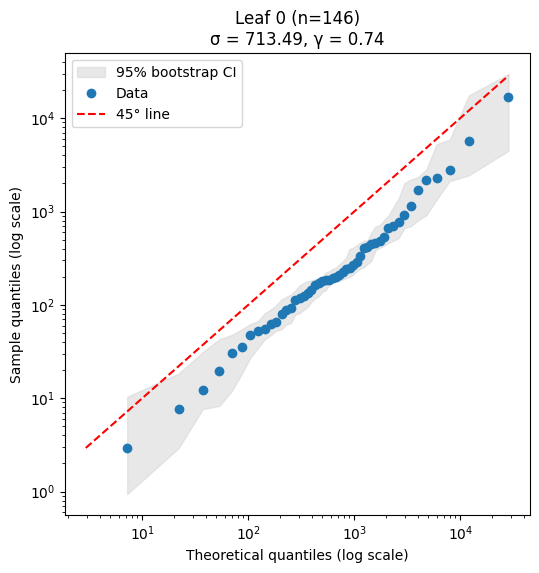

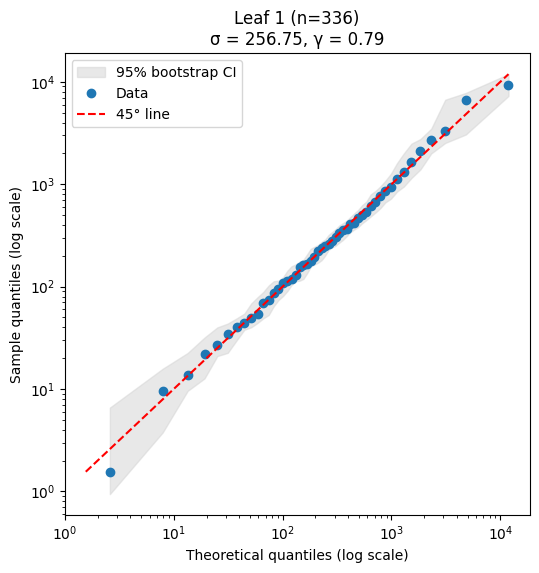

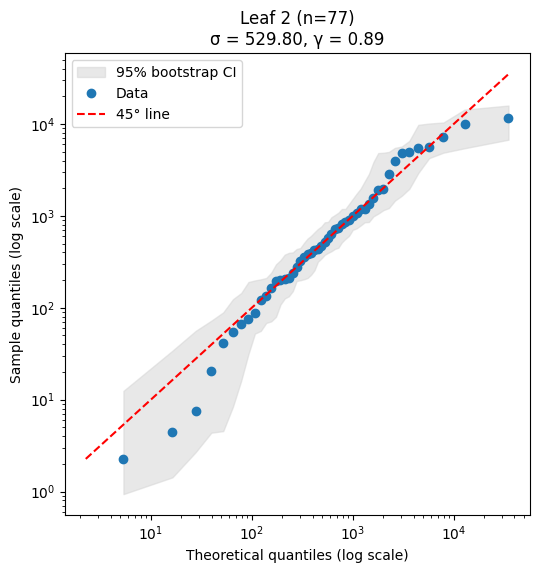

In [97]:
plot_gp_tree_qq(gpd_tail_tree_pruned, X_tail, y_tail)


In [ ]:
feature_names=[
       'House Price Index_diff_lag2', 'CPI_diff_lag2', 'Close_diff_lag2',
       'Category_Business Disruption and System Failures',
       'Category_Clients, Products & Business Practices',
       'Category_Damage to Physical Assets',
       'Category_Employment Practices and Workplace Safety',
       'Category_Execution, Delivery & Process Management',
       'Category_External Fraud', 'Category_Internal Fraud',
       'Category_Commercial Banking', 'Category_Corporate Finance',
       'Category_Health Insurance',
       'Category_Life Insurance and Benefit Plans',
       'Category_Merchant Banking', 'Category_Municipal/Government Finance',
       'Category_Private Banking', 'Category_Property and Casualty Insurance',
       'Category_Reinsurance', 'Category_Retail Banking']

In [ ]:
def merge_small_leaves_gpd(root: NodeGPD,
                           X: np.ndarray,
                           y: np.ndarray,
                           merge_threshold: int = 100) -> NodeGPD:
    """
    Bottom-up 방식으로 작은 리프를 부모 노드로 병합합니다.
      - root: prune_gpd_with_cv 등으로 미리 pruning 된 트리
      - X, y: Tail (초과치) 데이터
      - merge_threshold: 최소 샘플 수 기준
    """
    n = len(y)

    # 1) 모든 샘플을 현재 리프에 할당
    leaves = _get_all_leaves(root)  # 기존 함수 활용
    leaf_of = np.empty(n, dtype=int)
    for i in range(n):
        leaf = find_leaf(root, X[i])  # find_leaf_gpd 대신 범용 find_leaf 사용
        leaf_of[i] = leaves.index(leaf)
    leaf_idx_map = {i: np.where(leaf_of == i)[0] for i in range(len(leaves))}

    # 2) internal nodes (leaf가 아닌 노드만)
    internal_nodes = []
    def collect_internals(node):
        if not node.is_leaf:
            internal_nodes.append(node)
            if node.left:  collect_internals(node.left)
            if node.right: collect_internals(node.right)
    collect_internals(root)

    # 3) bottom-up 병합
    merged = True
    while merged:
        merged = False
        for node in internal_nodes:
            # Left/Right 가 둘 다 존재하고, 둘 다 leaf 여야 병합 가능
            if node.left is None or node.right is None:
                continue
            if not (node.left.is_leaf and node.right.is_leaf):
                continue

            # 각 자식 leaf_id
            left_id  = leaves.index(node.left)
            right_id = leaves.index(node.right)
            idx_l = leaf_idx_map.get(left_id, [])
            idx_r = leaf_idx_map.get(right_id, [])

            # 병합 기준 미만이면 병합
            if min(len(idx_l), len(idx_r)) < merge_threshold:
                combined_idx = np.concatenate([idx_l, idx_r])
                # 파라미터 재적합
                theta = fit_gpd_mle(y[combined_idx])
                nll   = neg_loglik_gpd((theta[0], theta[1]), y[combined_idx])

                # 부모 노드를 leaf로 전환
                node.is_leaf    = True
                node.split_var  = None
                node.split_thr  = None
                node.left       = None
                node.right      = None
                node.gpd_params = theta
                node.nll        = nll

                # leaf 리스트/맵 갱신
                # 기존 child leaf entries 삭제
                leaf_idx_map.pop(left_id, None)
                leaf_idx_map.pop(right_id, None)
                # 새로운 leaf id 추가
                new_id = max(leaf_idx_map.keys(), default=-1) + 1
                leaves.append(node)
                leaf_idx_map[new_id] = combined_idx

                merged = True
                break

    return root


In [ ]:
# (1) GPD 트리 생성 및 CV-prune
raw_gpd = grow_tree_gpd(X_tail, y_tail, feature_names, min_leaf=50, max_depth=3)
pruned_gpd, best_alpha = prune_gpd_with_cv(raw_gpd, X_tail, y_tail, n_folds=3)

# (2) 작은 리프 병합
merged_gpd = merge_small_leaves_gpd(pruned_gpd, X_tail, y_tail, merge_threshold=1000)

# (3) 결과 확인
print_tree_structure(merged_gpd, feature_names)
validate_tree_structure(merged_gpd)


[House Price Index_diff_lag2 ≤ 0.08087] (PenalizedGain=1509.181) N=77472
  [House Price Index_diff_lag2 ≤ 0.05021] (PenalizedGain=420.014) N=67103
    [CPI_diff_lag2 ≤ 0.01495] (PenalizedGain=327.691) N=40753
      Leaf: N=4032, GPD(σ=251.867, γ=0.550), NLL=27654.2
      Leaf: N=36721, GPD(σ=279.243, γ=0.596), NLL=265404.7
    [Close_diff_lag2 ≤ -0.04295] (PenalizedGain=7697.215) N=26350
      Leaf: N=8928, GPD(σ=243.692, γ=0.547), NLL=62879.6
      Leaf: N=17422, GPD(σ=302.456, γ=0.950), NLL=135503.4
  [House Price Index_diff_lag2 ≤ 0.09859] (PenalizedGain=149.559) N=10369
    Leaf: N=3168, GPD(σ=468.839, γ=0.662), NLL=24748.6
    Leaf: N=7201, GPD(σ=803.361, γ=0.756), NLL=60812.9


True

In [ ]:
gp_tree_lrt(merged_gpd, X_tail, y_tail)


GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -577003.41
  단일 GP 로그우도: -634390.19
  LRT statistic = 114773.55 (df = 10)
  p‑value = 0.000e+00 -> reject single GP model
  AIC (GP 트리) = 1154030.83, AIC (단일 GP) = 1268784.38


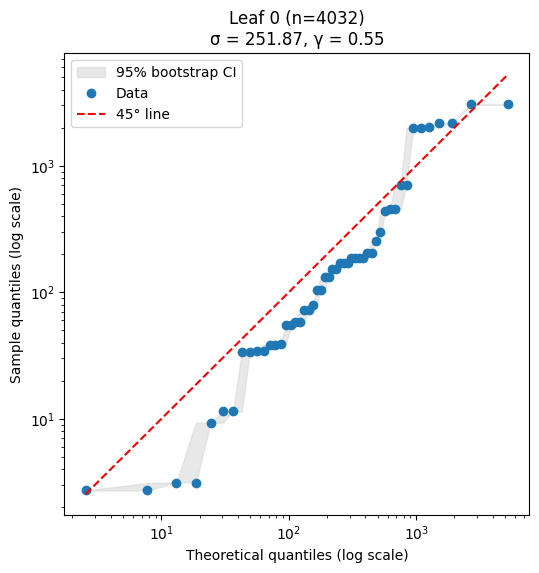

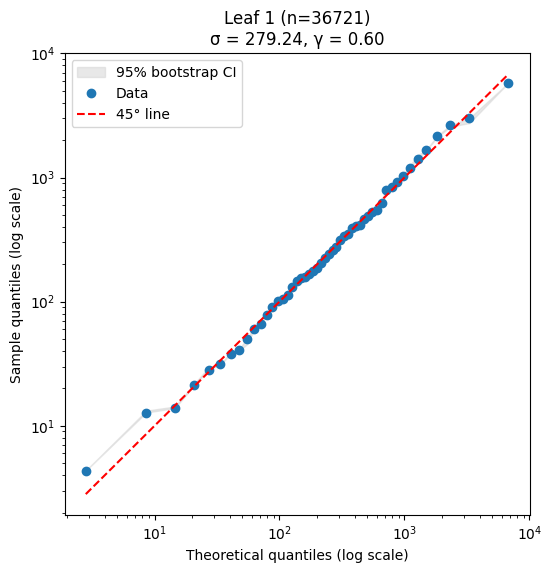

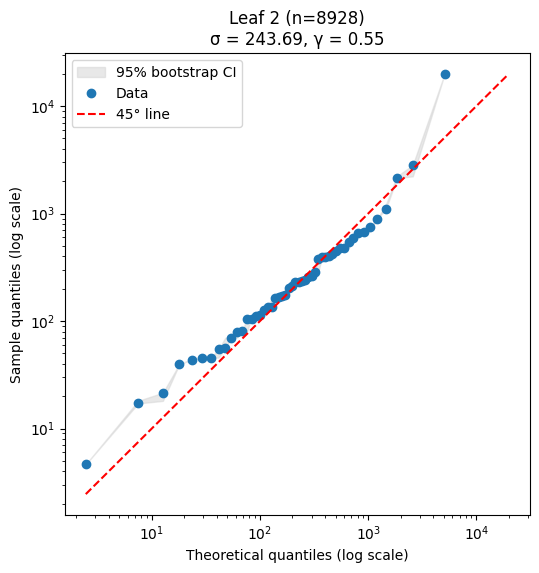

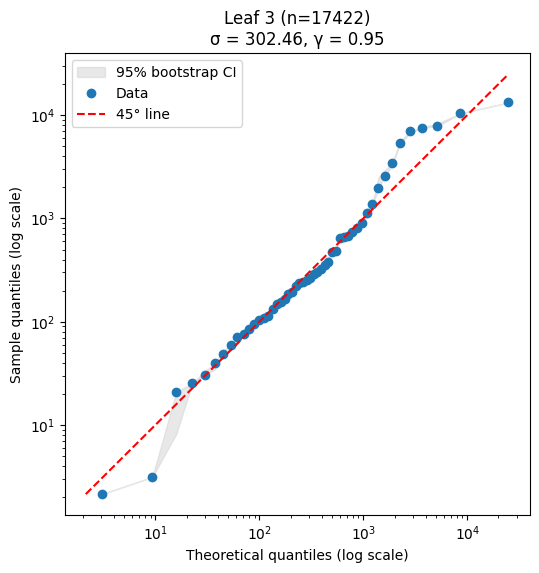

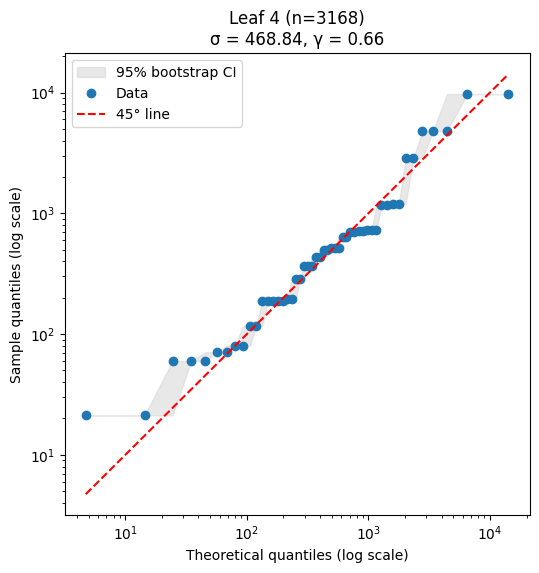

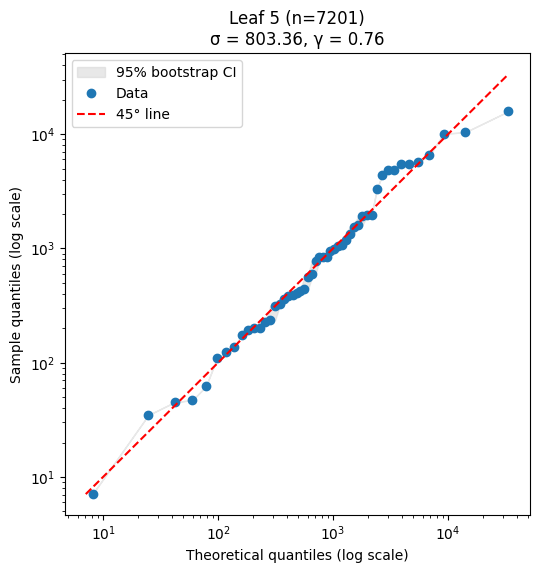

In [ ]:
plot_gp_tree_qq(merged_gpd, X_tail, y_tail)


In [ ]:
import pickle

# --- __main__ 블록 마지막에 추가 ---
save_path = '/content/drive/MyDrive/Operational_risk/'
# 1) 저장할 객체들 모으기
output = {
    # Bulk 트리
    'l1_bulk_tree' : l1_bulk_tree,
    'l2_bulk_tree' : l2_bulk_tree,
    # Tail 트리
    'gpd_raw_tree' : gpd_tail_tree_raw,
    'gpd_pruned_tree' : gpd_tail_tree_pruned,
    'merged_gpd ' : merged_gpd,
    # 데이터
    'X_bulk'       : X_bulk,
    'y_bulk'       : y_bulk,
    'X_tail'       : X_tail,
    'y_tail'       : y_tail,
    'X_all_data'   : X_all_data,
    'y_all_data'   : y_all_data,
    'df_model_ready':df_model_ready,
    # (선택) 피처 이름
    'feature_names': feature_names_list,
    # (선택) 임계값
    'u_threshold'  : u_threshold
}

# 2) 피클 파일로 저장
with open(save_path + 'risk_1985_2021_non_epu.pkl', 'wb') as f:
    pickle.dump(output, f)

logging.info("Models and data have been saved to 'risk_1985_2021_non_epu.pkl'")


#Simulation

In [ ]:
class NodeBase:
    """Base class for all nodes in the trees."""
    __slots__ = ("is_leaf", "split_var", "split_thr", "gain", "left", "right", "depth", "n_samples")

    def __init__(self):
        self.is_leaf: bool = True
        self.split_var: Optional[int] = None
        self.split_thr: Optional[float] = None
        self.gain: float = 0.0
        self.left: Optional['NodeBase'] = None
        self.right: Optional['NodeBase'] = None
        self.depth: int = 0
        self.n_samples: int = 0 # Keep track of samples in the node

class NodeL1(NodeBase):
    """Node for L1 CART (median-based)."""
    __slots__ = ("median_val", "lognorm_mu", "lognorm_sigma")

    def __init__(self):
        super().__init__()
        self.median_val: Optional[float] = None
        self.lognorm_mu: Optional[float] = None
        self.lognorm_sigma: Optional[float] = None

class NodeL2(NodeBase):
    """Node for L2 CART (mean-based)."""
    __slots__ = ("mean_val", "lognorm_mu", "lognorm_sigma")

    def __init__(self):
        super().__init__()
        self.mean_val: Optional[float] = None
        self.lognorm_mu: Optional[float] = None
        self.lognorm_sigma: Optional[float] = None

class NodeGPD(NodeBase):
    """Node for GPD CART."""
    __slots__ = ("gpd_params", "nll", "split_gain") # Inherits others via super().__init__()

    def __init__(self):
        super().__init__() # Initializes is_leaf, split_var, split_thr, left, right, depth, n_samples
        # Note: 'gain' from NodeBase is repurposed as 'split_gain' here for clarity in GPD context
        self.split_gain: float = 0.0 # Gain used for splitting decision (AIC penalized)
        self.gpd_params: Optional[Tuple[float, float]] = None # (sigma, gamma)
        self.nll: Optional[float] = None # Negative Log-Likelihood at this node


In [ ]:
import pickle

with open(save_path +'ev_cart_models_and_data.pkl', 'rb') as f:
    loaded = pickle.load(f)

# 꺼내쓰기

l1_tree = loaded['l1_bulk_tree']
X_bulk  = loaded['X_bulk']
y_bulk  = loaded['y_bulk']
l2_tree = loaded['l2_bulk_tree']
gpd_tree = loaded['gpd_pruned_tree']
X_tail  = loaded['X_tail']
y_tail  = loaded['y_tail']
X_all_data = loaded['X_all_data']
y_all_data = loaded['y_all_data']
df_model_ready = loaded['df_model_ready']
feature_names_list = loaded['feature_names']
u_threshold = loaded['u_threshold']

# … 기타 등등


In [ ]:
import joblib
import pickle
import numpy as np
import pandas as pd
from typing import List
import numpy as np
import pandas as pd
from scipy.stats import norm

def truncated_lognormal_mean(mu: float, sigma: float, u: float) -> float:
    """
    절사된(왼쪽 트렁케이트) log-normal의 조건부 기댓값 E[X | X <= u].
    """
    if sigma <= 0:
        return np.exp(mu)  # degenerate case
    alpha = (np.log(u) - mu) / sigma
    # 전체 무조건부 평균
    full_mean = np.exp(mu + 0.5*sigma**2)
    # 절사 보정 계수
    phi = norm.pdf
    Phi = norm.cdf
    # 보정된 기댓값
    return full_mean * (Phi(alpha - sigma) / Phi(alpha))


def compute_expected_severity(leaf, u: float) -> float:
    # 로그정규 노드
    if hasattr(leaf, 'lognorm_mu') and hasattr(leaf, 'lognorm_sigma'):
        mu, sigma = leaf.lognorm_mu, leaf.lognorm_sigma
        if mu is None or sigma is None:
            return np.nan
        return truncated_lognormal_mean(mu, sigma, u)
    # GPD 노드 (기존대로)
    elif hasattr(leaf, 'gpd_params'):
        sigma_t, gamma = leaf.gpd_params
        if gamma is None or sigma_t is None or gamma >= 1.0:
            return np.nan
        return u + sigma_t/(1-gamma)
    else:
        raise ValueError(f"Unknown leaf type: {type(leaf)}")




# 2) 변수 재할당 (여기서 bulk_tree, tail_tree 정의)
bulk_tree    = data['l1_bulk_tree']        # L1 CART 트리 루트
tail_tree    = data['gpd_pruned_tree']     # GPD CART 트리 루트
X_bulk, y_bulk = data['X_bulk'], data['y_bulk']
X_tail, y_tail = data['X_tail'], data['y_tail']
u_threshold  = data['u_threshold']

# (get_all_leaves, find_leaf, compute_expected_severity, summarize_segment 함수는
#  이전에 제공한 그대로 사용)

# 3) summarize_segment 호출 시 bulk_tree, tail_tree 사용
df_bulk = summarize_segment(bulk_tree, X_bulk, y_bulk, u_threshold, 'bulk')
df_tail = summarize_segment(tail_tree, X_tail, y_tail, u_threshold, 'tail')

# 4) 결과 합치고 출력
df_all = pd.concat([df_bulk, df_tail], ignore_index=True)
summary = (
    df_all
    .groupby(['segment','leaf_idx'])
    .agg(
        n_samples         = ('actual_sev',   'size'),
        mean_actual_sev   = ('actual_sev',   'mean'),
        mean_expected_sev = ('expected_sev', 'mean')
    )
    .reset_index()
)
summary['bias_ratio'] = (
    (summary['mean_expected_sev'] - summary['mean_actual_sev'])
    / summary['mean_actual_sev']
)
print(summary)


   segment  leaf_idx  n_samples  mean_actual_sev  mean_expected_sev  \
0     bulk         0     127581       267.097546         472.421416   
1     bulk         1       6048       104.072585         412.337042   
2     bulk         2        432       816.172490         886.009624   
3     bulk         3       1728       253.607573         516.820215   
4     bulk         4       8496       113.258008         422.102457   
5     bulk         5        720       197.523080         509.867965   
6     bulk         6        143        11.765022          11.765022   
7     bulk         7        289       283.016756         285.781486   
8     tail         0        811      4889.842384        6200.881786   
9     tail         1         24      1211.010849        3355.064558   
10    tail         2         16     10332.419563       10810.349636   
11    tail         3         27      4928.326748        6878.012729   
12    tail         4         29       521.777373        2704.239437   
13    

In [ ]:
bulk_tree, tail_tree = data['l1_bulk_tree'], data['gpd_pruned_tree']
X_bulk, y_bulk       = data['X_bulk'], data['y_bulk']
X_tail, y_tail       = data['X_tail'], data['y_tail']
u_threshold          = data['u_threshold']

# ───────────────────────────────────────────────
# 2) 트리 유틸리티
# ───────────────────────────────────────────────
def get_all_leaves(node):
    if node.is_leaf: return [node]
    out = []
    if node.left:  out += get_all_leaves(node.left)
    if node.right: out += get_all_leaves(node.right)
    return out

def find_leaf(node, x):
    while not node.is_leaf:
        if x[node.split_var] <= node.split_thr:
            node = node.left
        else:
            node = node.right
    return node

# ───────────────────────────────────────────────
# 3) Truncated-Lognormal MLE & Mean
# ───────────────────────────────────────────────
def fit_truncated_lognormal(y_vals, u):
    """
    y_vals: np.array of actual severities, all <= u
    u: threshold
    return: (mu_hat, sigma_hat)
    """
    logs = np.log(y_vals)
    u0   = np.log(u)
    # 음의 로그우도 (truncated normal on logs <= u0)
    def nll(params):
        mu, log_s = params
        σ = np.exp(log_s)
        α = (u0 - mu) / σ
        # Normal 부분
        ll_norm = -0.5*np.sum(((logs - mu)/σ)**2) - len(logs)*np.log(σ) - 0.5*len(logs)*np.log(2*np.pi)
        # truncation 보정
        ll_trunc = - len(logs)*np.log(norm.cdf(α))
        return -(ll_norm - ll_trunc)  # maximize ll_norm - ll_trunc

    # 초기값: log-평균, log-표준편차
    init = [np.mean(logs), np.log(np.std(logs))]
    res  = minimize(nll, init, method='L-BFGS-B')
    mu_hat, sigma_hat = res.x[0], np.exp(res.x[1])
    return mu_hat, sigma_hat

def truncated_lognormal_mean(mu, sigma, u):
    """
    E[X | X <= u] for X~LogNormal(mu,sigma^2)
    = exp(mu+0.5*sigma^2) * Phi((ln u - mu - sigma)/sigma) / Phi((ln u - mu)/sigma)
    """
    if sigma <= 0:
        return np.exp(mu)
    ln_u = np.log(u)
    α    = (ln_u - mu) / sigma
    full = np.exp(mu + 0.5*sigma**2)
    return full * ( norm.cdf(α - 1*sigma) / norm.cdf(α) )

# ───────────────────────────────────────────────
# 4) segment 별 요약 (bulk에만 리핏 적용)
# ───────────────────────────────────────────────
def summarize_segment(tree, X, y, u, segment):
    leaves   = get_all_leaves(tree)
    leaf_map = { id(leaf): i for i, leaf in enumerate(leaves) }
    recs = []

    # 우선 sample→leaf mapping
    leaf_ids = [ id(find_leaf(tree, x_)) for x_ in X ]
    leaf_idxs= [ leaf_map[lid] for lid in leaf_ids ]

    # bulk 인 경우, 각 leaf 별로 MLE
    if segment == 'bulk':
        # leaf → data 집합
        leaf_data = { i: [] for i in range(len(leaves)) }
        for idx, yv in zip(leaf_idxs, y):
            leaf_data[idx].append(yv)

        # leaf 별 파라미터 refit
        leaf_params = {}
        for i, vals in leaf_data.items():
            arr = np.array(vals)
            if len(arr) < 30:  # 너무 샘플 수 적으면 skip
                leaf_params[i] = None
            else:
                mu_, σ_ = fit_truncated_lognormal(arr, u)
                leaf_params[i] = (mu_, σ_)

    # 각 샘플 별 레코드 작성
    for idx_leaf, yv in zip(leaf_idxs, y):
        leaf = leaves[idx_leaf]
        if segment == 'bulk':
            params = leaf_params[idx_leaf]
            if params is None:
                expv = np.nan
            else:
                expv = truncated_lognormal_mean(params[0], params[1], u)
        else:
            # tail: 기존 GPD 방식
            σ_t, γ = leaf.gpd_params
            expv    = u + σ_t / (1 - γ) if γ<1 else np.nan

        recs.append({
            'segment': segment,
            'leaf_idx': idx_leaf,
            'actual_sev': yv,
            'expected_sev': expv
        })

    return pd.DataFrame(recs)

# ───────────────────────────────────────────────
# 5) bulk/tail 합치고 집계
# ───────────────────────────────────────────────
df_bulk = summarize_segment(bulk_tree, X_bulk, y_bulk, u_threshold, 'bulk')
df_tail = summarize_segment(tail_tree, X_tail, y_tail, u_threshold, 'tail')
df_all  = pd.concat([df_bulk, df_tail], ignore_index=True)

summary = (
    df_all
    .groupby(['segment','leaf_idx'])
    .agg(
        n_samples         = ('actual_sev',   'size'),
        mean_actual_sev   = ('actual_sev',   'mean'),
        mean_expected_sev = ('expected_sev', 'mean')
    )
    .reset_index()
)
summary['bias_ratio'] = (
    (summary['mean_expected_sev'] - summary['mean_actual_sev'])
    / summary['mean_actual_sev']
)

pd.set_option('display.float_format', '{:.4f}'.format)
print(summary)

   segment  leaf_idx  n_samples  mean_actual_sev  mean_expected_sev  \
0     bulk         0     127581         267.0975           219.6751   
1     bulk         1       6048         104.0726           115.3116   
2     bulk         2        432         816.1725           654.1377   
3     bulk         3       1728         253.6076           242.2920   
4     bulk         4       8496         113.2580           107.6107   
5     bulk         5        720         197.5231           179.3463   
6     bulk         6        143          11.7650            11.7650   
7     bulk         7        289         283.0168           285.7815   
8     tail         0        811        4889.8424          6200.8818   
9     tail         1         24        1211.0108          3355.0646   
10    tail         2         16       10332.4196         10810.3496   
11    tail         3         27        4928.3267          6878.0127   
12    tail         4         29         521.7774          2704.2394   
13    

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import genpareto

def sample_mixture_losses(bulk_leaves, tail_leaves, u, draws, seed=None):
    """
    Simulate losses Y from a bulk-tail mixture:
      - Bulk: LogNormal(mu, sigma) with weights proportional to sample counts
      - Tail: GPD above threshold u with parameters (scale, shape)
    """
    if seed is not None:
        np.random.seed(seed)
    # weights and parameters
    bulk_counts = np.array([leaf["N"] for leaf in bulk_leaves], dtype=float)
    bulk_weights = bulk_counts / bulk_counts.sum()
    bulk_mus     = np.array([leaf["mu"] for leaf in bulk_leaves])
    bulk_sigmas  = np.array([leaf["sigma"] for leaf in bulk_leaves])
    tail_counts  = np.array([leaf["N"] for leaf in tail_leaves], dtype=float)
    tail_weights = tail_counts / tail_counts.sum()
    tail_scales  = np.array([leaf["sigma"] for leaf in tail_leaves])
    tail_shapes  = np.array([leaf["gamma"] for leaf in tail_leaves])
    # mixture probabilities
    p_tail = tail_counts.sum() / (bulk_counts.sum() + tail_counts.sum())
    p_bulk = 1 - p_tail

    # decide which component each draw comes from
    is_bulk = np.random.rand(draws) < p_bulk
    Y = np.empty(draws)

    # bulk draws
    n_bulk = is_bulk.sum()
    if n_bulk:
        idx_b = np.random.choice(len(bulk_leaves), size=n_bulk, p=bulk_weights)
        Y[is_bulk] = np.random.lognormal(mean=bulk_mus[idx_b], sigma=bulk_sigmas[idx_b])

    # tail draws
    n_tail = draws - n_bulk
    if n_tail:
        idx_t = np.random.choice(len(tail_leaves), size=n_tail, p=tail_weights)
        U = np.random.rand(n_tail)
        shapes = tail_shapes[idx_t]
        scales = tail_scales[idx_t]
        # GPD quantile: scale * ((1-u)^(-shape) - 1)/shape
        # here U ~ Uniform(0,1), so quantile = scale * (U**(-shape) - 1)/shape if shape!=0
        with np.errstate(divide='ignore', invalid='ignore'):
            q_exc = np.where(
                np.abs(shapes) > 1e-8,
                scales * (U**(-shapes) - 1) / shapes,
                -scales * np.log(1 - U)  # limit shape->0
            )
        Y[~is_bulk] = u + q_exc

    return Y

def compute_pure_premium(bulk_leaves, tail_leaves, u, p_freq, draws, exposures, seed=42):
    """
    Calculate pure premium per exposure and total over periods via simulation.
    """
    # simulate loss severity
    Y = sample_mixture_losses(bulk_leaves, tail_leaves, u, draws, seed)
    # apply severity-to-cost transformation: L = exp(9.59 + 0.57 * ln(Y))
    L = np.exp(9.59) * (Y ** 0.57)
    E_L = L.mean()

    # frequency model: expected claims per exposure
    # If claim occurrence ~ Bernoulli(p_freq), E[N]=p_freq
    E_N = p_freq

    # pure premium per exposure
    pi0 = E_N * E_L
    total_premium = pi0 * exposures

    return {
        "E[N]": E_N,
        "E[L]": E_L,
        "Pure Premium per Exposure": pi0,
        "Total Premium over Periods": total_premium
    }

# Example usage:
if __name__ == "__main__":
    # parameters (from original script)
    bulk_leaves = [
        {"N":127581, "mu":7.45, "sigma":3.30},
        {"N":  6048, "mu":7.24, "sigma":3.73},
        {"N":   432, "mu":7.62, "sigma":1.51},
        {"N":  1728, "mu":7.43, "sigma":2.95},
        {"N":  8496, "mu":7.22, "sigma":3.61},
        {"N":   720, "mu":7.32, "sigma":2.93},
        {"N":   143, "mu":2.47, "sigma":0.00},
        {"N":   289, "mu":5.61, "sigma":0.29},
    ]
    tail_leaves = [
        {"N":  811, "sigma":4400.850,  "gamma":-0.100},
        {"N":   24, "sigma":1386.077,  "gamma":-0.200},
        {"N":   16, "sigma":10332.420, "gamma":-0.200},
        {"N":   27, "sigma":5613.615,  "gamma":-0.200},
        {"N":   29, "sigma":605.087,   "gamma":-0.200},
        {"N": 5754, "sigma":2211.495,  "gamma": 0.433},
        {"N":  576, "sigma":697.971,   "gamma": 0.424},
        {"N":  432, "sigma":935.744,   "gamma": 0.950},
        {"N":  576, "sigma":4536.007,  "gamma":-0.380},
        {"N":   47, "sigma":7128.256,  "gamma":-0.395},
        {"N":   25, "sigma":5613.615,  "gamma":-0.200},
        {"N":  179, "sigma":16324.733, "gamma":-0.500},
    ]
    u = 2200.0
    p_freq = 0.10
    draws = 200000
    exposures = 20

    results = compute_pure_premium(bulk_leaves, tail_leaves, u, p_freq, draws, exposures, seed=123)
    df = pd.DataFrame({
        "Metric": list(results.keys()),
        "Value": list(results.values())
    })
    print(df)


                       Metric         Value
0                        E[N]        0.1000
1                        E[L]  5925811.0215
2   Pure Premium per Exposure   592581.1022
3  Total Premium over Periods 11851622.0430


#Graphs_pickle

In [ ]:
import numpy as np
import pandas as pd
import logging
from scipy.optimize import minimize
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
from scipy import stats
import copy
from typing import Tuple, List, Optional, Dict, Any, Union
import math

# ---------------------------------------------------------------------#
# Logging Setup
# ---------------------------------------------------------------------#
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# ---------------------------------------------------------------------#
# Constants
# ---------------------------------------------------------------------#
# SEED = 42
# np.random.seed(SEED)
# MIN_FLOAT = 1e-9 # Small number to avoid division by zero etc.
# LARGE_FLOAT = 1e15 # Large number for infinite costs/NLL

FLT_INFO = np.finfo(float)

SEED        = 42
rng         = np.random.default_rng(SEED)     # 전역 RandomGenerator
MIN_FLOAT   = FLT_INFO.eps                    # ≈2.22e‑16
LARGE_FLOAT = 1e30

# ---------------------------------------------------------------------#
# 0. Utility Functions
# ---------------------------------------------------------------------#
def mse_loss(y: np.ndarray, mu: float) -> float:
    """Calculate Mean Squared Error."""
    if len(y) == 0:
        return 0.0
    return np.sum((y - mu) ** 2)

def mae_loss(y: np.ndarray, md: float) -> float:
    """Calculate Mean Absolute Error."""
    if len(y) == 0:
        return 0.0
    return np.sum(np.abs(y - md))

# ---------------------------------------------------------------------#
# Base Node Class and Specific Nodes
# ---------------------------------------------------------------------#
class NodeBase:
    """Base class for all nodes in the trees."""
    __slots__ = ("is_leaf", "split_var", "split_thr", "gain", "left", "right", "depth", "n_samples")

    def __init__(self):
        self.is_leaf: bool = True
        self.split_var: Optional[int] = None
        self.split_thr: Optional[float] = None
        self.gain: float = 0.0
        self.left: Optional['NodeBase'] = None
        self.right: Optional['NodeBase'] = None
        self.depth: int = 0
        self.n_samples: int = 0 # Keep track of samples in the node

class NodeL1(NodeBase):
    """Node for L1 CART (median-based)."""
    __slots__ = ("median_val", "lognorm_mu", "lognorm_sigma")

    def __init__(self):
        super().__init__()
        self.median_val: Optional[float] = None
        self.lognorm_mu: Optional[float] = None
        self.lognorm_sigma: Optional[float] = None

class NodeL2(NodeBase):
    """Node for L2 CART (mean-based)."""
    __slots__ = ("mean_val", "lognorm_mu", "lognorm_sigma")

    def __init__(self):
        super().__init__()
        self.mean_val: Optional[float] = None
        self.lognorm_mu: Optional[float] = None
        self.lognorm_sigma: Optional[float] = None

class NodeGPD(NodeBase):
    """Node for GPD CART."""
    __slots__ = ("gpd_params", "nll", "split_gain") # Inherits others via super().__init__()

    def __init__(self):
        super().__init__() # Initializes is_leaf, split_var, split_thr, left, right, depth, n_samples
        # Note: 'gain' from NodeBase is repurposed as 'split_gain' here for clarity in GPD context
        self.split_gain: float = 0.0 # Gain used for splitting decision (AIC penalized)
        self.gpd_params: Optional[Tuple[float, float]] = None # (sigma, gamma)
        self.nll: Optional[float] = None # Negative Log-Likelihood at this node
def merge_small_leaves_gpd(root: NodeGPD,
                           X: np.ndarray,
                           y: np.ndarray,
                           merge_threshold: int = 100) -> NodeGPD:
    """
    Bottom-up 방식으로 작은 리프를 부모 노드로 병합합니다.
      - root: prune_gpd_with_cv 등으로 미리 pruning 된 트리
      - X, y: Tail (초과치) 데이터
      - merge_threshold: 최소 샘플 수 기준
    """
    n = len(y)

    # 1) 모든 샘플을 현재 리프에 할당
    leaves = _get_all_leaves(root)  # 기존 함수 활용
    leaf_of = np.empty(n, dtype=int)
    for i in range(n):
        leaf = find_leaf(root, X[i])  # find_leaf_gpd 대신 범용 find_leaf 사용
        leaf_of[i] = leaves.index(leaf)
    leaf_idx_map = {i: np.where(leaf_of == i)[0] for i in range(len(leaves))}

    # 2) internal nodes (leaf가 아닌 노드만)
    internal_nodes = []
    def collect_internals(node):
        if not node.is_leaf:
            internal_nodes.append(node)
            if node.left:  collect_internals(node.left)
            if node.right: collect_internals(node.right)
    collect_internals(root)

    # 3) bottom-up 병합
    merged = True
    while merged:
        merged = False
        for node in internal_nodes:
            # Left/Right 가 둘 다 존재하고, 둘 다 leaf 여야 병합 가능
            if node.left is None or node.right is None:
                continue
            if not (node.left.is_leaf and node.right.is_leaf):
                continue

            # 각 자식 leaf_id
            left_id  = leaves.index(node.left)
            right_id = leaves.index(node.right)
            idx_l = leaf_idx_map.get(left_id, [])
            idx_r = leaf_idx_map.get(right_id, [])

            # 병합 기준 미만이면 병합
            if min(len(idx_l), len(idx_r)) < merge_threshold:
                combined_idx = np.concatenate([idx_l, idx_r])
                # 파라미터 재적합
                theta = fit_gpd_mle(y[combined_idx])
                nll   = neg_loglik_gpd((theta[0], theta[1]), y[combined_idx])

                # 부모 노드를 leaf로 전환
                node.is_leaf    = True
                node.split_var  = None
                node.split_thr  = None
                node.left       = None
                node.right      = None
                node.gpd_params = theta
                node.nll        = nll

                # leaf 리스트/맵 갱신
                # 기존 child leaf entries 삭제
                leaf_idx_map.pop(left_id, None)
                leaf_idx_map.pop(right_id, None)
                # 새로운 leaf id 추가
                new_id = max(leaf_idx_map.keys(), default=-1) + 1
                leaves.append(node)
                leaf_idx_map[new_id] = combined_idx

                merged = True
                break

    return root


##epu

In [ ]:
import pickle
save_path = '/content/drive/MyDrive/Operational_risk/'
with open(save_path +'risk_1985_2021.pkl', 'rb') as f:
    loaded = pickle.load(f)

# 꺼내쓰기
l1_tree = loaded['l1_bulk_tree']
l2_tree = loaded['l2_bulk_tree']
gpd_raw_tree = loaded['gpd_raw_tree']
gpd_pruned_tree = loaded['gpd_pruned_tree']
merged_gpd = loaded['merged_gpd ']
df_model_ready = loaded['df_model_ready']

X_tail  = loaded['X_tail']
y_tail  = loaded['y_tail']
X_bulk  = loaded['X_bulk']
y_bulk  = loaded['y_bulk']
X_all_data= loaded['X_all_data']
y_all_data= loaded['y_all_data']
feature_names_list= loaded['feature_names']
u_threshold= loaded['u_threshold']



In [ ]:
gp_tree_lrt(gpd_pruned_tree, X_tail, y_tail)



GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -574903.62
  단일 GP 로그우도: -634390.19
  LRT statistic = 118973.13 (df = 26)
  p‑value = 0.000e+00 -> reject single GP model
  AIC (GP 트리) = 1149863.25, AIC (단일 GP) = 1268784.38


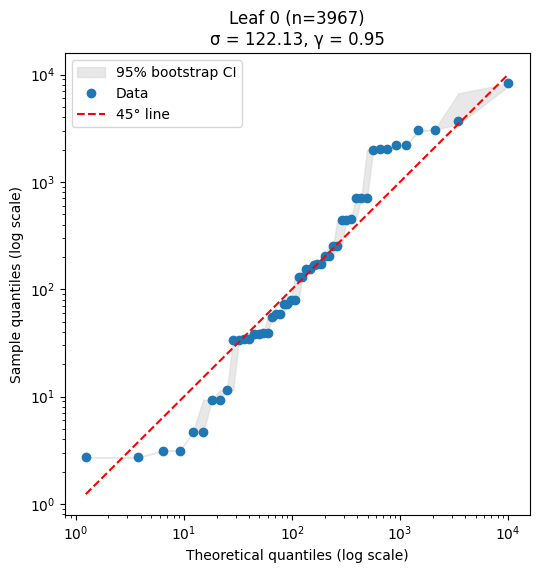

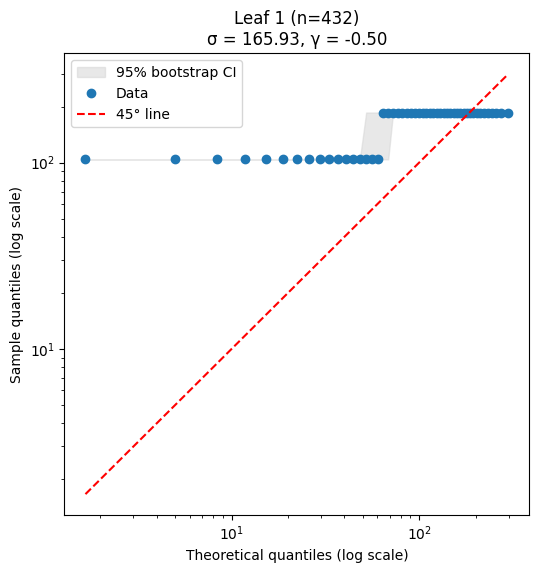

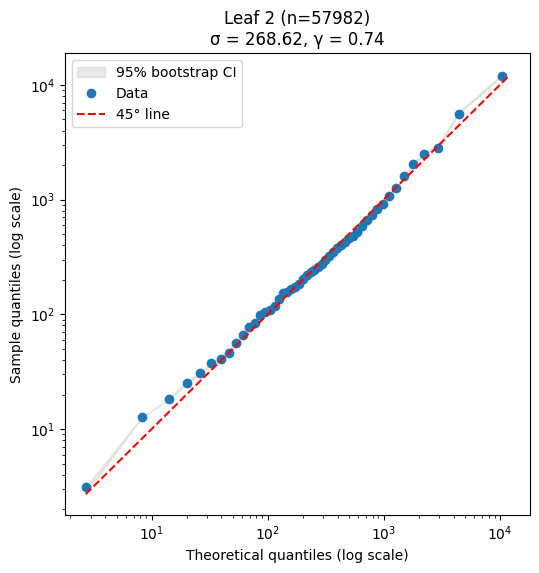

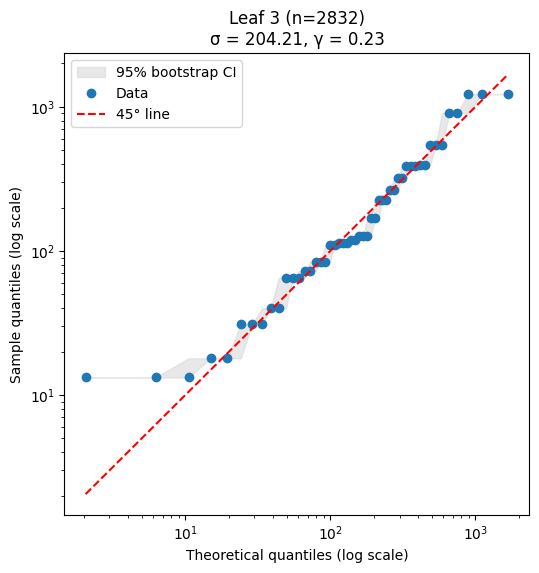

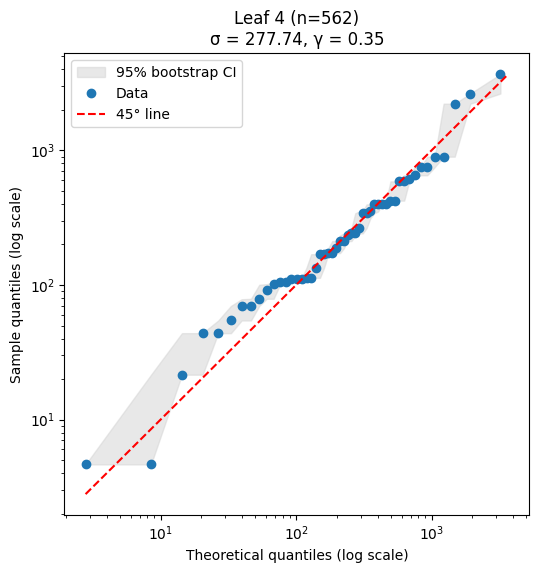

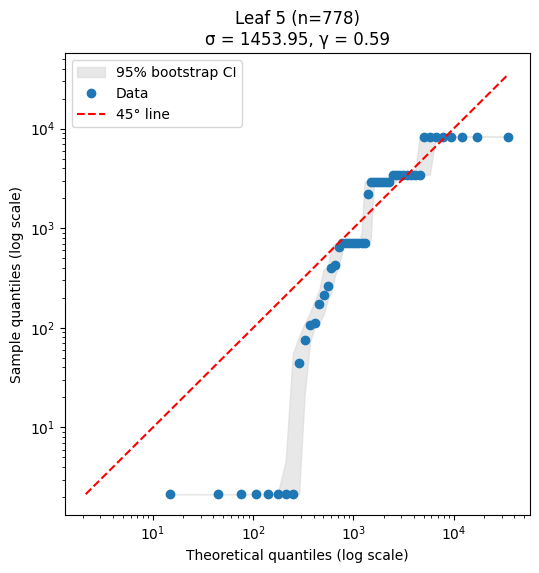

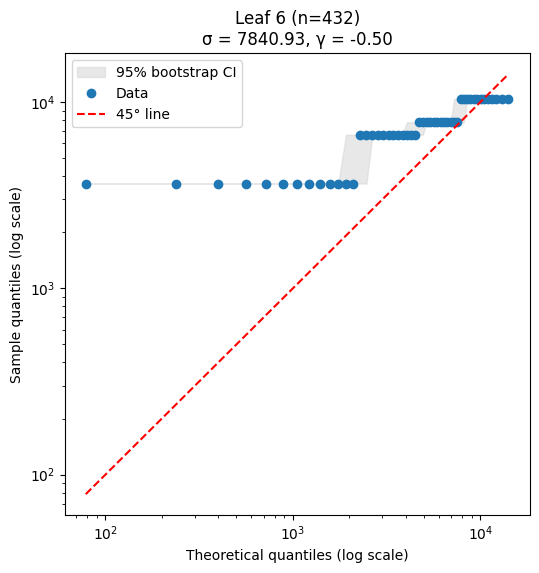

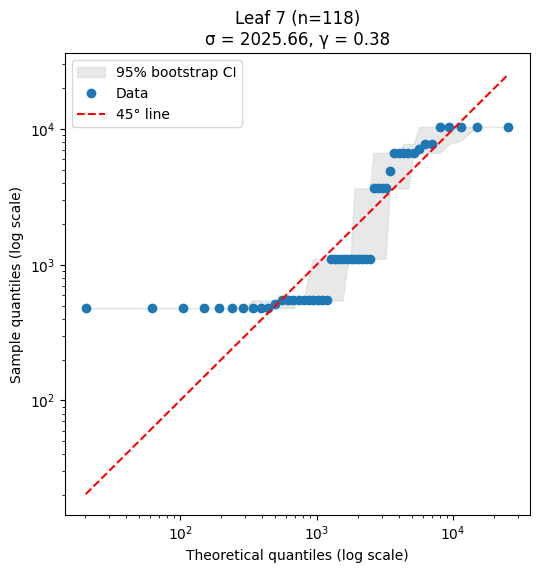

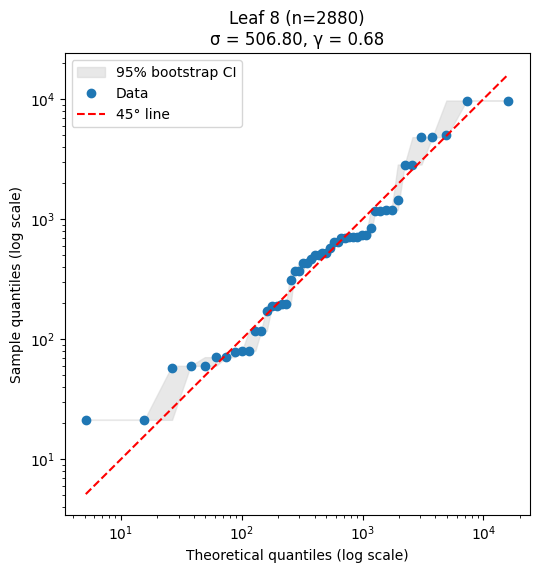

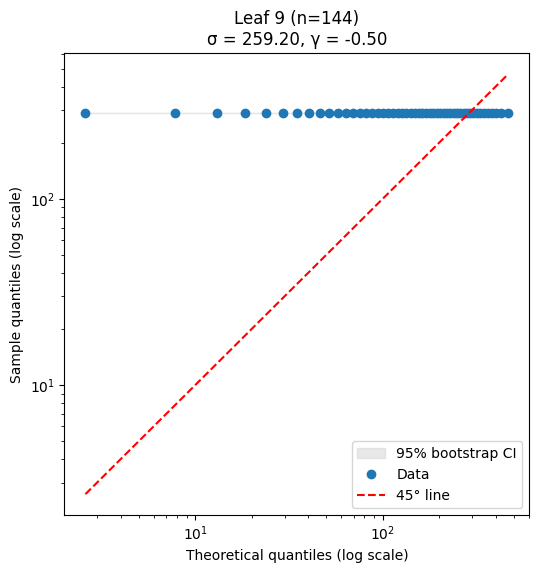

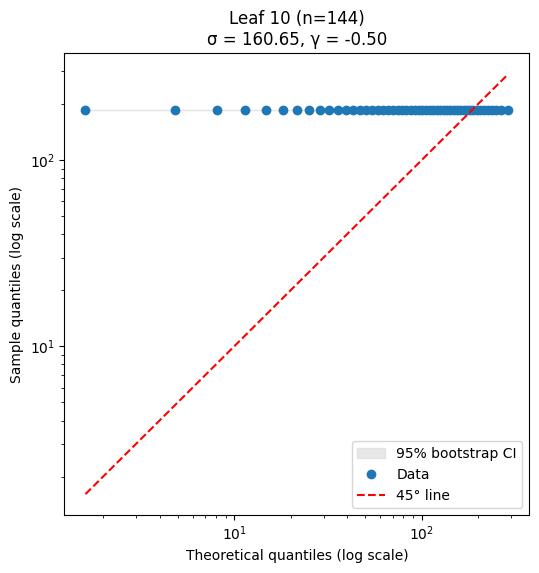

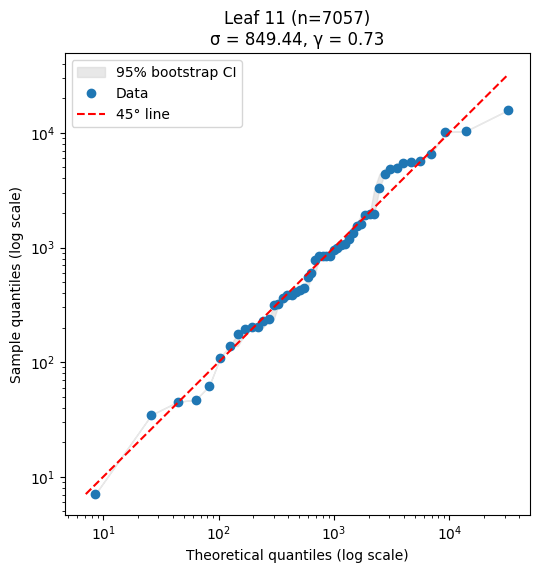

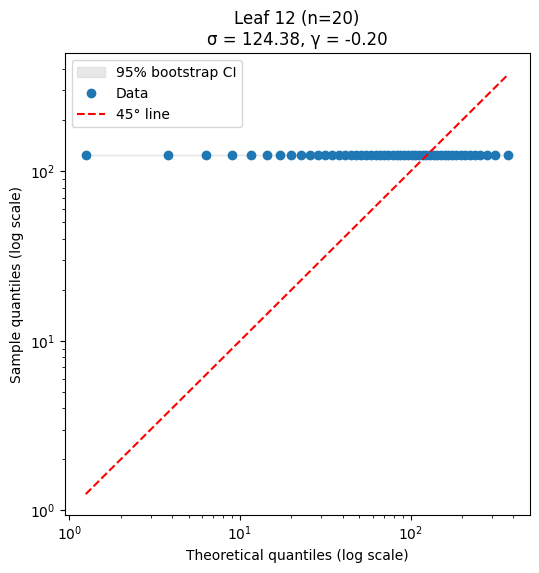

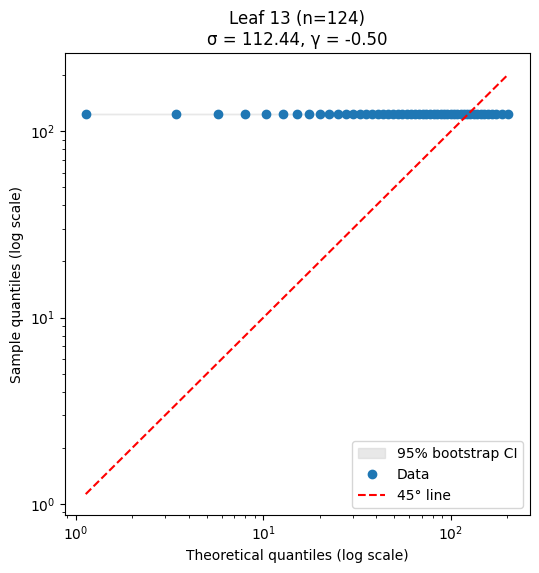

In [ ]:
plot_gp_tree_qq(gpd_pruned_tree, X_tail, y_tail)

In [ ]:
gp_tree_lrt(merged_gpd, X_tail, y_tail)


GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -576859.72
  단일 GP 로그우도: -634390.19
  LRT statistic = 115060.94 (df = 8)
  p‑value = 0.000e+00 -> reject single GP model
  AIC (GP 트리) = 1153739.43, AIC (단일 GP) = 1268784.38


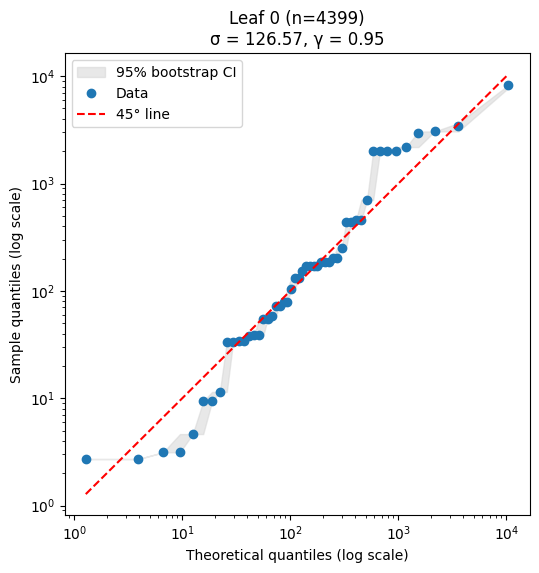

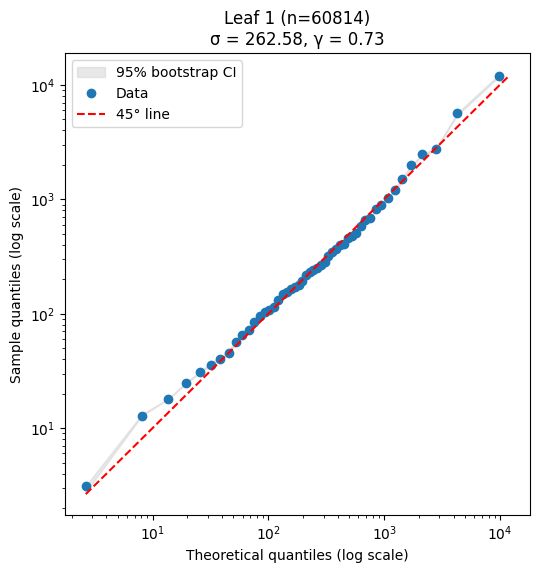

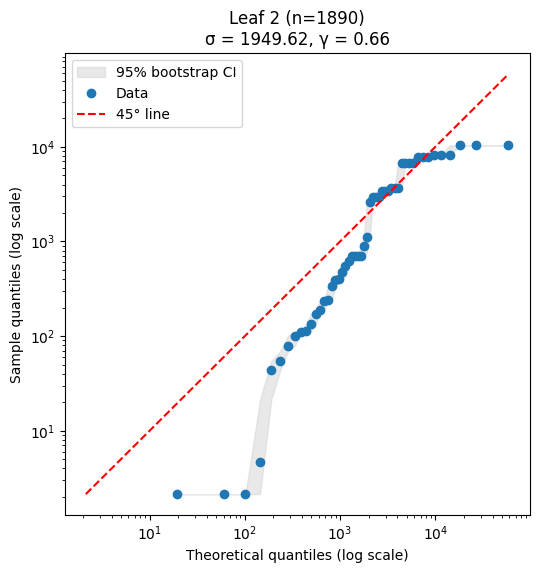

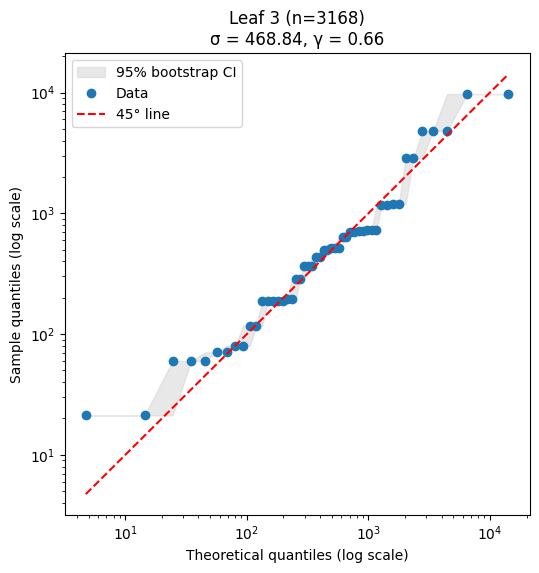

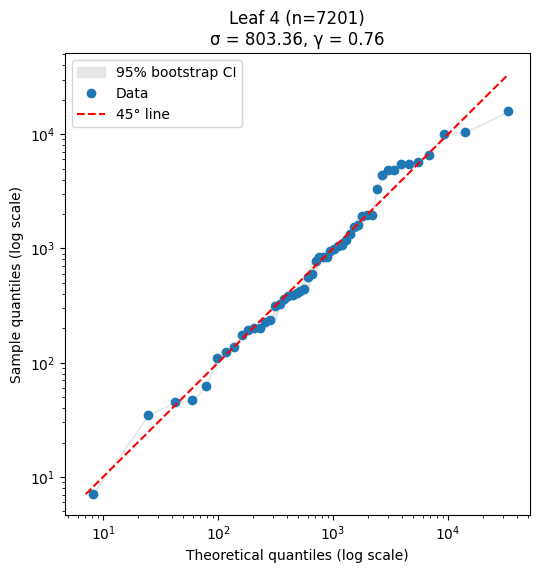

In [ ]:
plot_gp_tree_qq(merged_gpd, X_tail, y_tail)


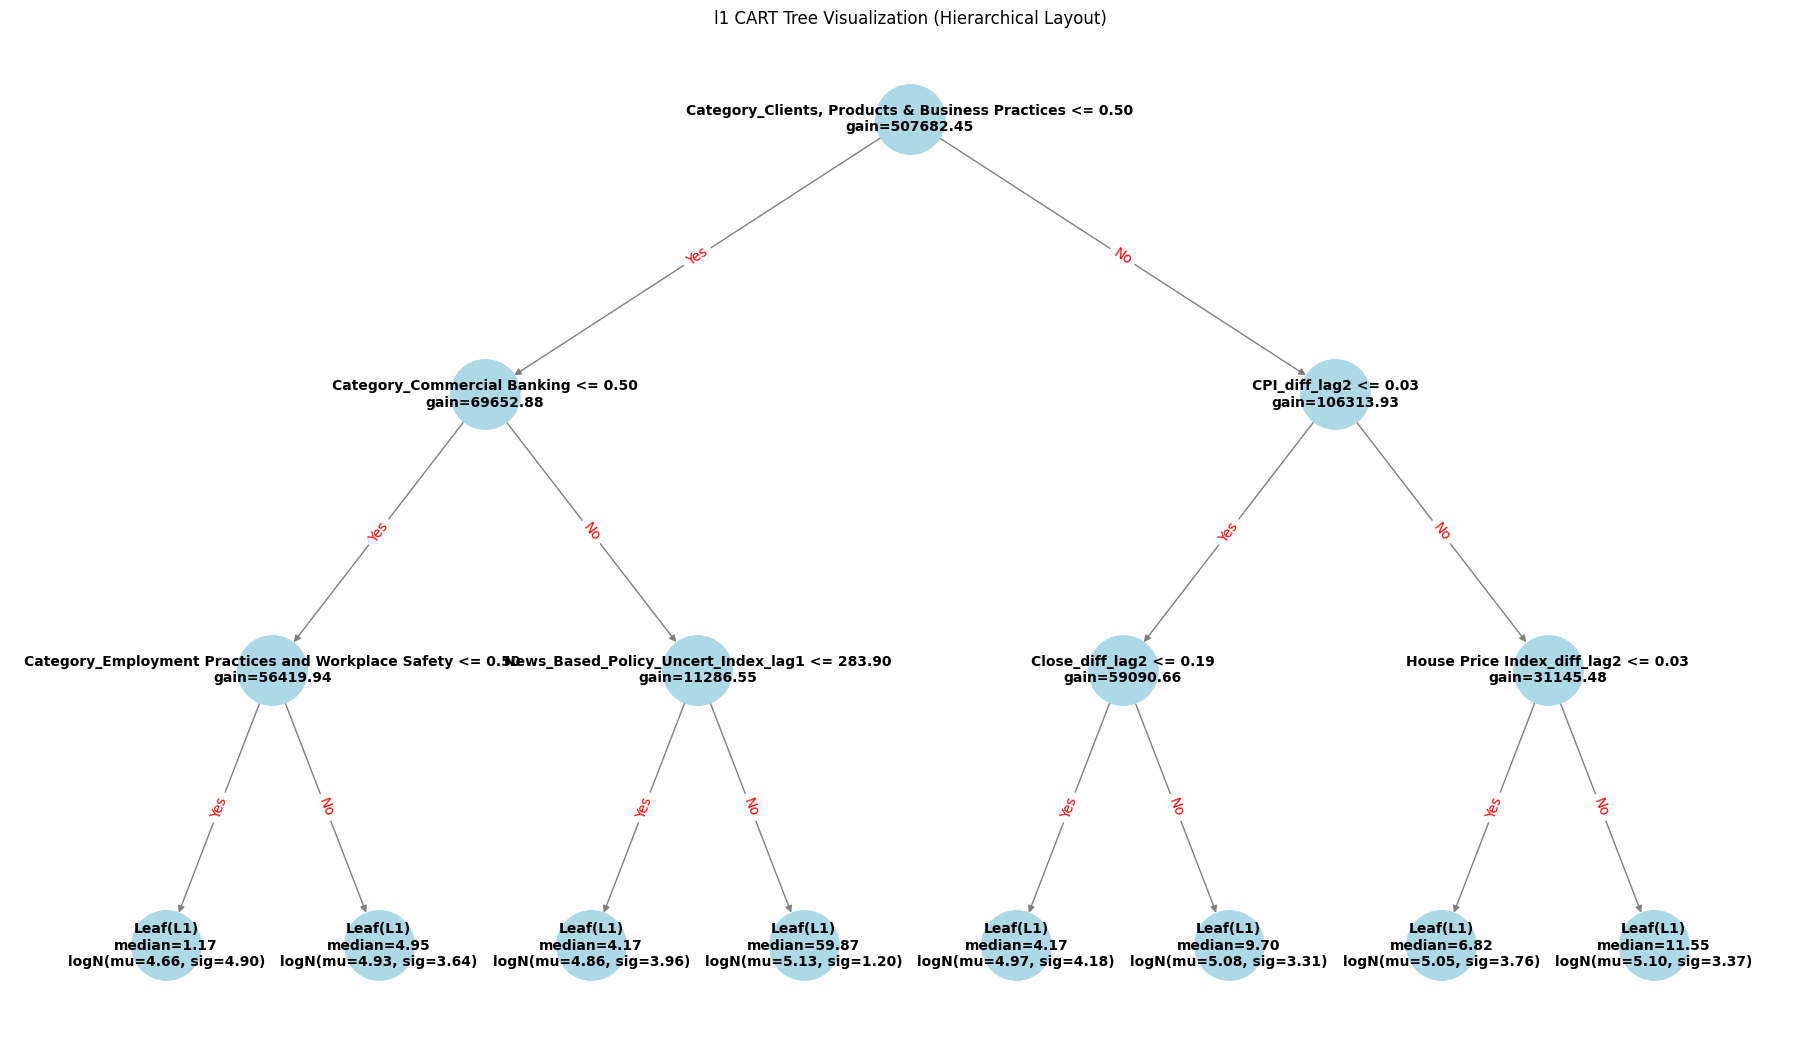

In [ ]:
draw_l1_tree_graph_hier(l1_tree,feature_names_list)

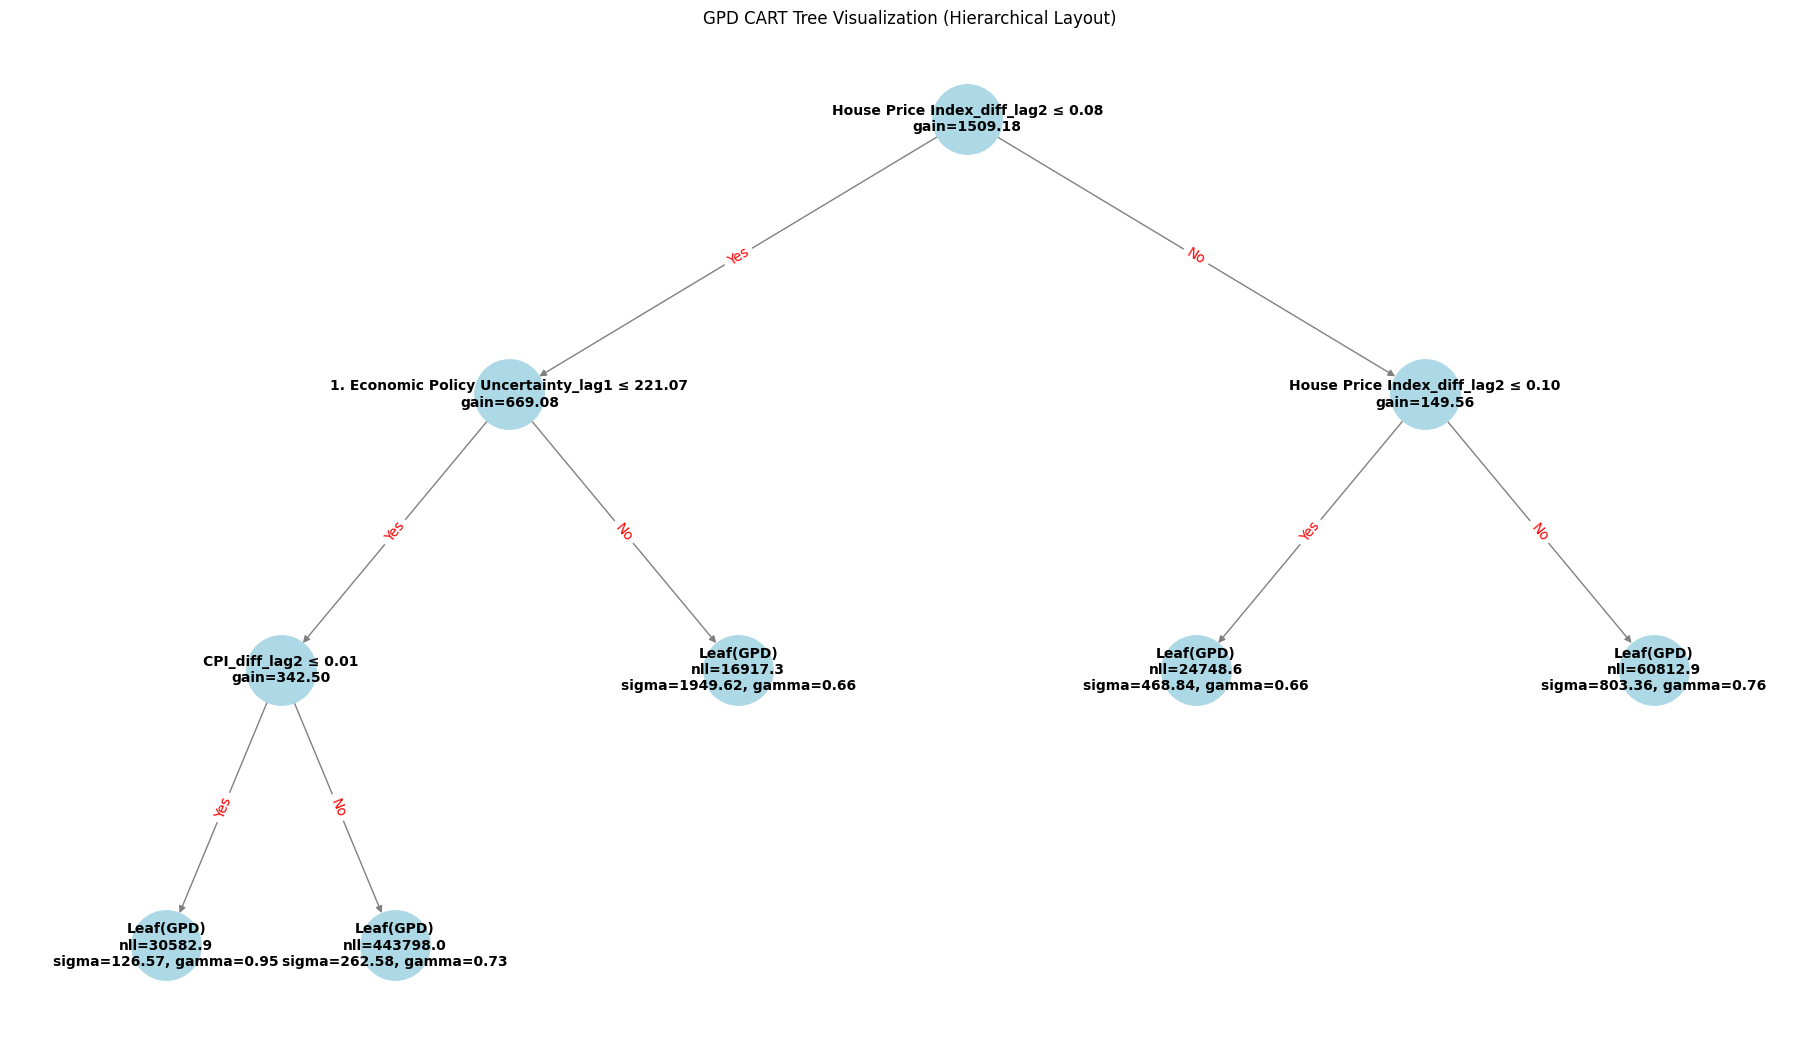

In [ ]:
draw_gpd_tree_graph_hier(merged_gpd,feature_names_list)

##non_epu

In [ ]:
import pickle

with open(save_path +'risk_1985_2021_non_epu.pkl', 'rb') as f:
    loaded_non = pickle.load(f)

# 꺼내쓰기
l1_tree_non = loaded_non['l1_bulk_tree']
l2_tree_non = loaded_non['l2_bulk_tree']
gpd_raw_tree_non = loaded_non['gpd_raw_tree']
gpd_pruned_tree_non = loaded_non['gpd_pruned_tree']
merged_gpd_non = loaded_non['merged_gpd ']
df_model_ready_non = loaded_non['df_model_ready']

X_tail_non  = loaded_non['X_tail']
y_tail_non  = loaded_non['y_tail']
X_bulk_non  = loaded_non['X_bulk']
y_bulk_non  = loaded_non['y_bulk']
X_all_data_non= loaded_non['X_all_data']
y_all_data_non= loaded_non['y_all_data']
feature_names_list_non= loaded_non['feature_names']
u_threshold_non= loaded_non['u_threshold']


In [ ]:
gp_tree_lrt(gpd_pruned_tree_non, X_tail_non, y_tail_non)



GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -575209.17
  단일 GP 로그우도: -634390.19
  LRT statistic = 118362.03 (df = 24)
  p‑value = 0.000e+00 -> reject single GP model
  AIC (GP 트리) = 1150470.35, AIC (단일 GP) = 1268784.38


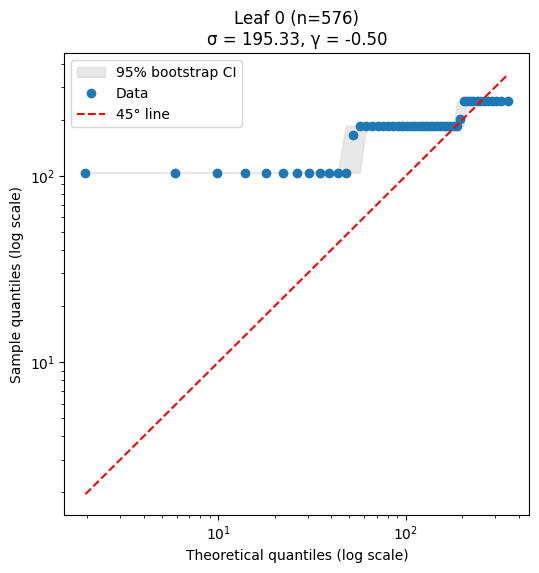

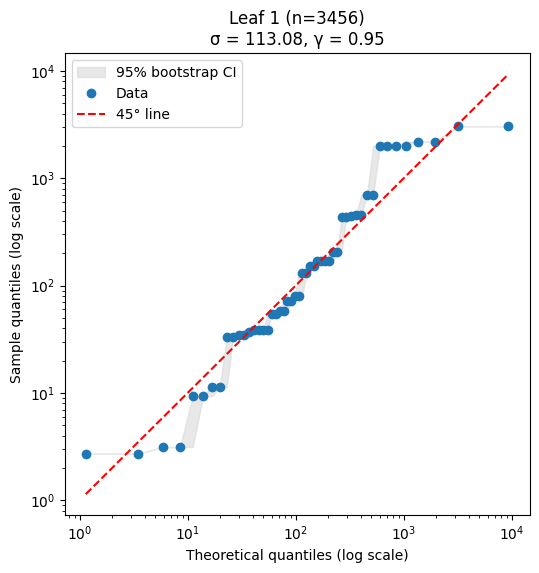

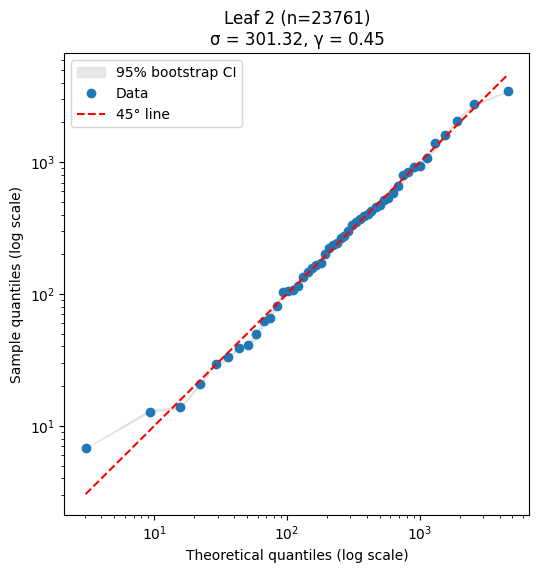

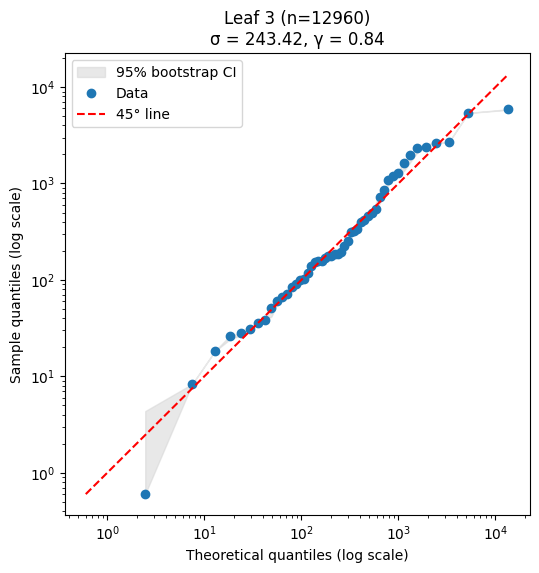

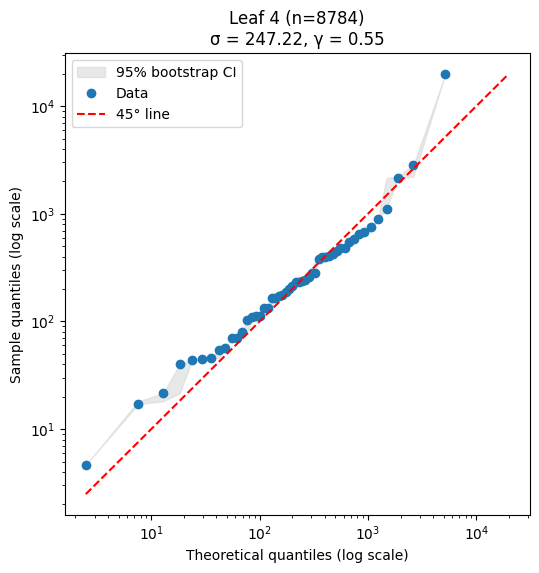

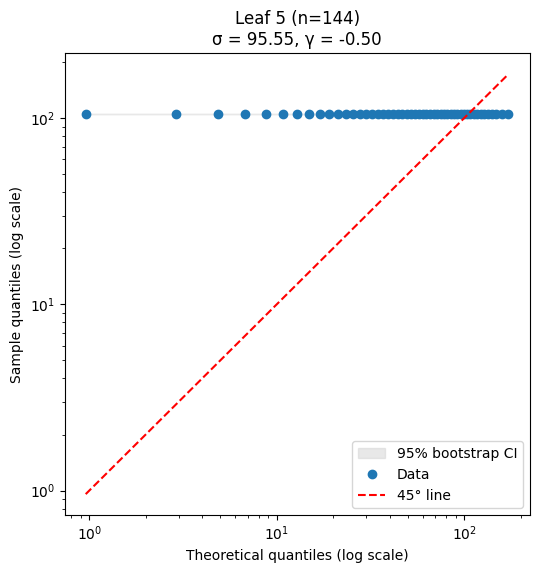

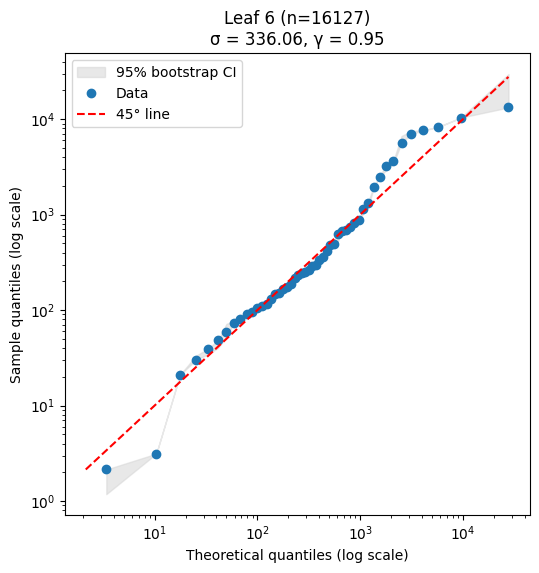

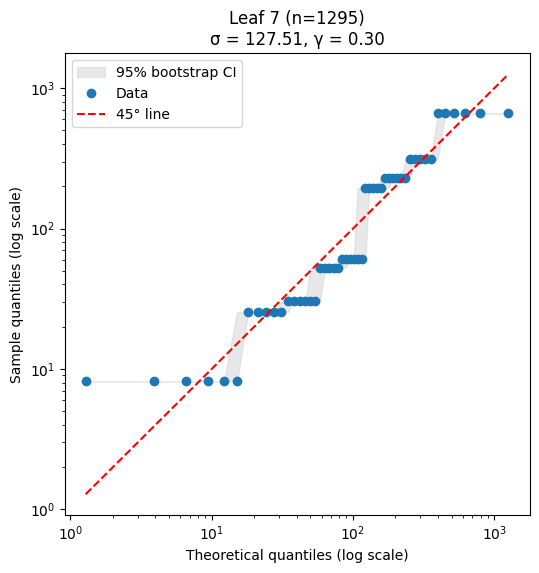

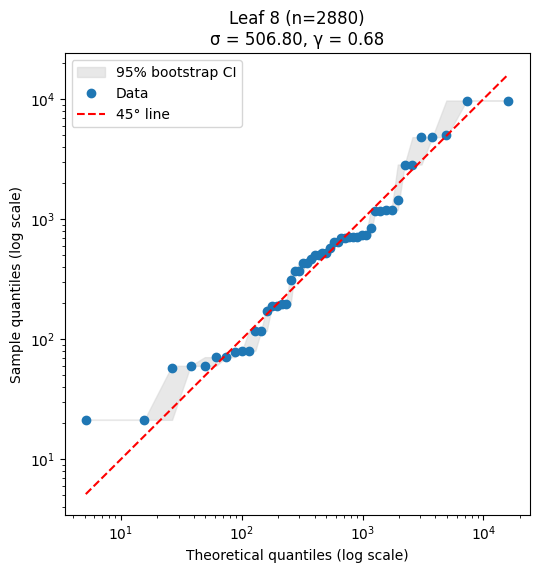

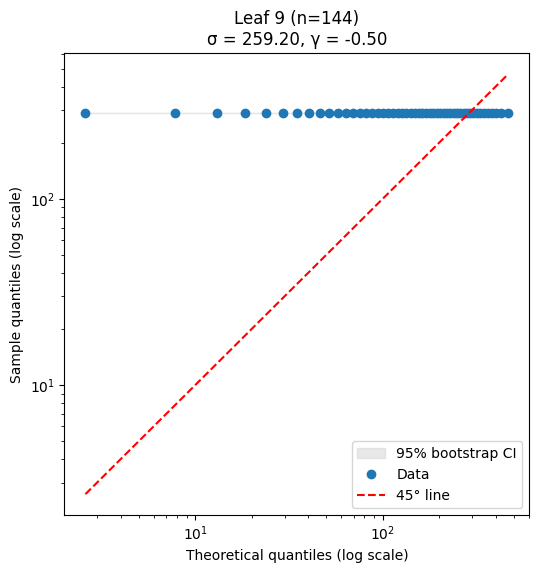

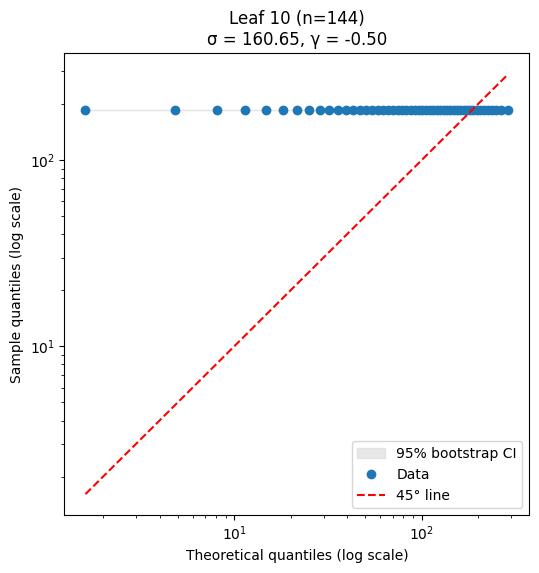

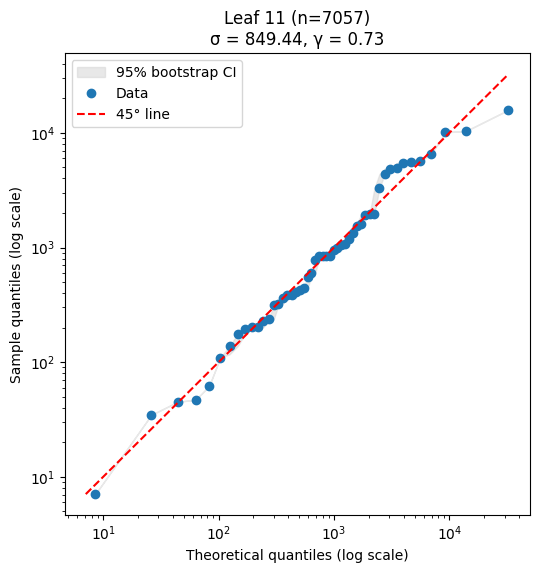

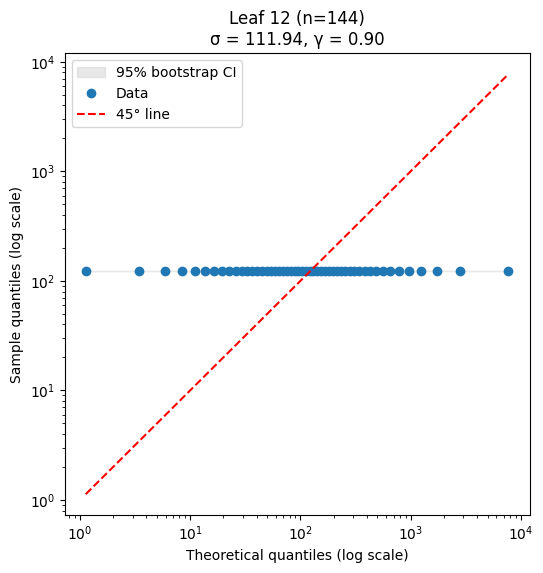

In [ ]:
plot_gp_tree_qq(gpd_pruned_tree_non, X_tail_non, y_tail_non)

In [ ]:
gp_tree_lrt(merged_gpd_non, X_tail_non, y_tail_non)



GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -577003.41
  단일 GP 로그우도: -634390.19
  LRT statistic = 114773.55 (df = 10)
  p‑value = 0.000e+00 -> reject single GP model
  AIC (GP 트리) = 1154030.83, AIC (단일 GP) = 1268784.38


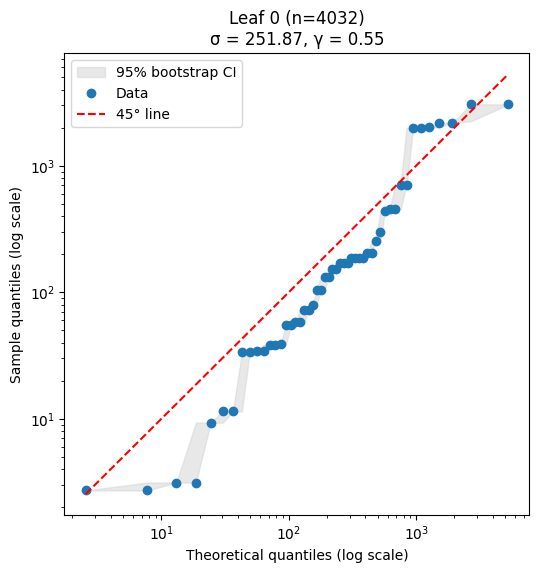

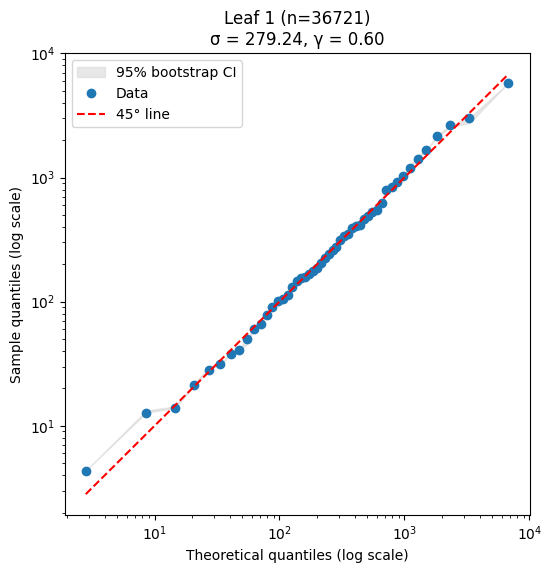

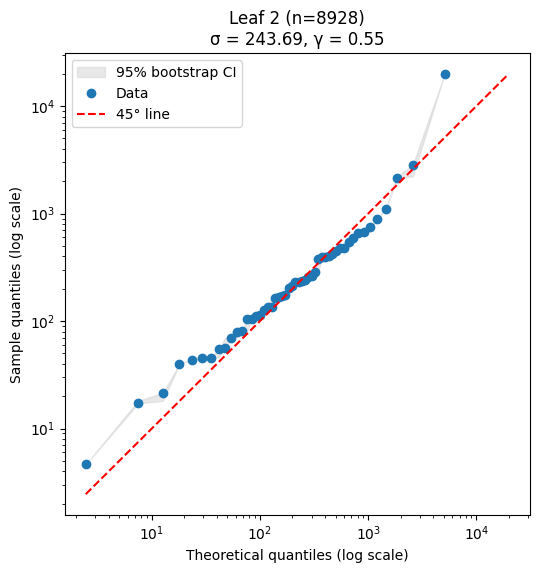

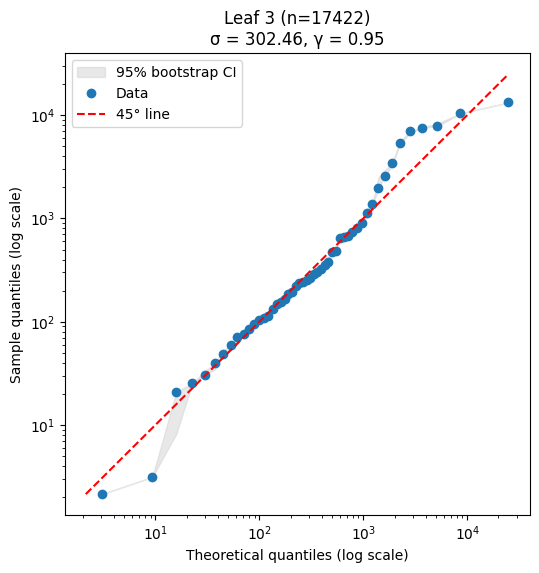

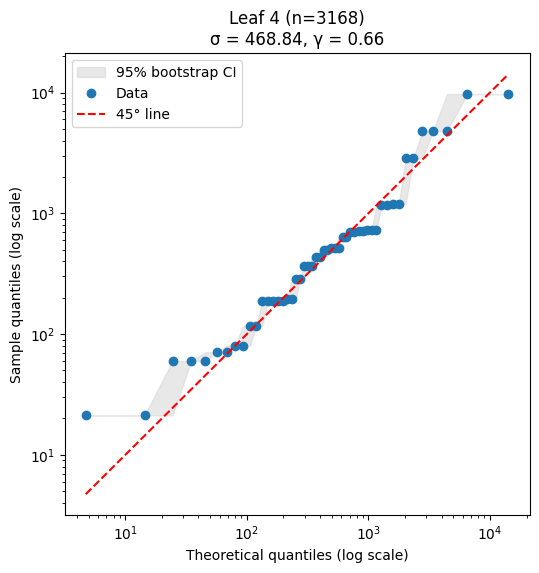

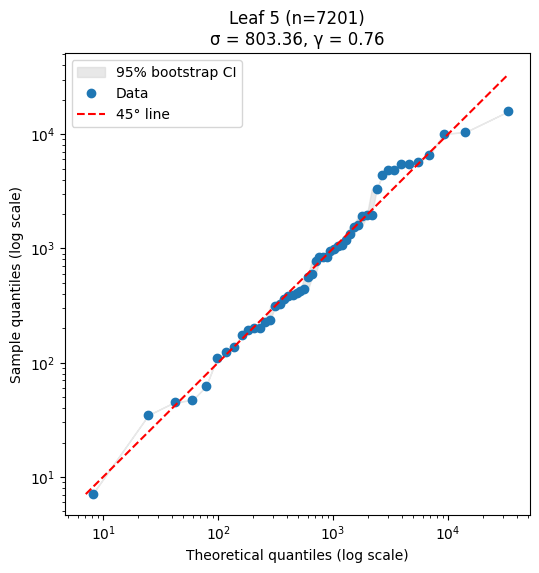

In [ ]:
plot_gp_tree_qq(merged_gpd_non, X_tail_non, y_tail_non)

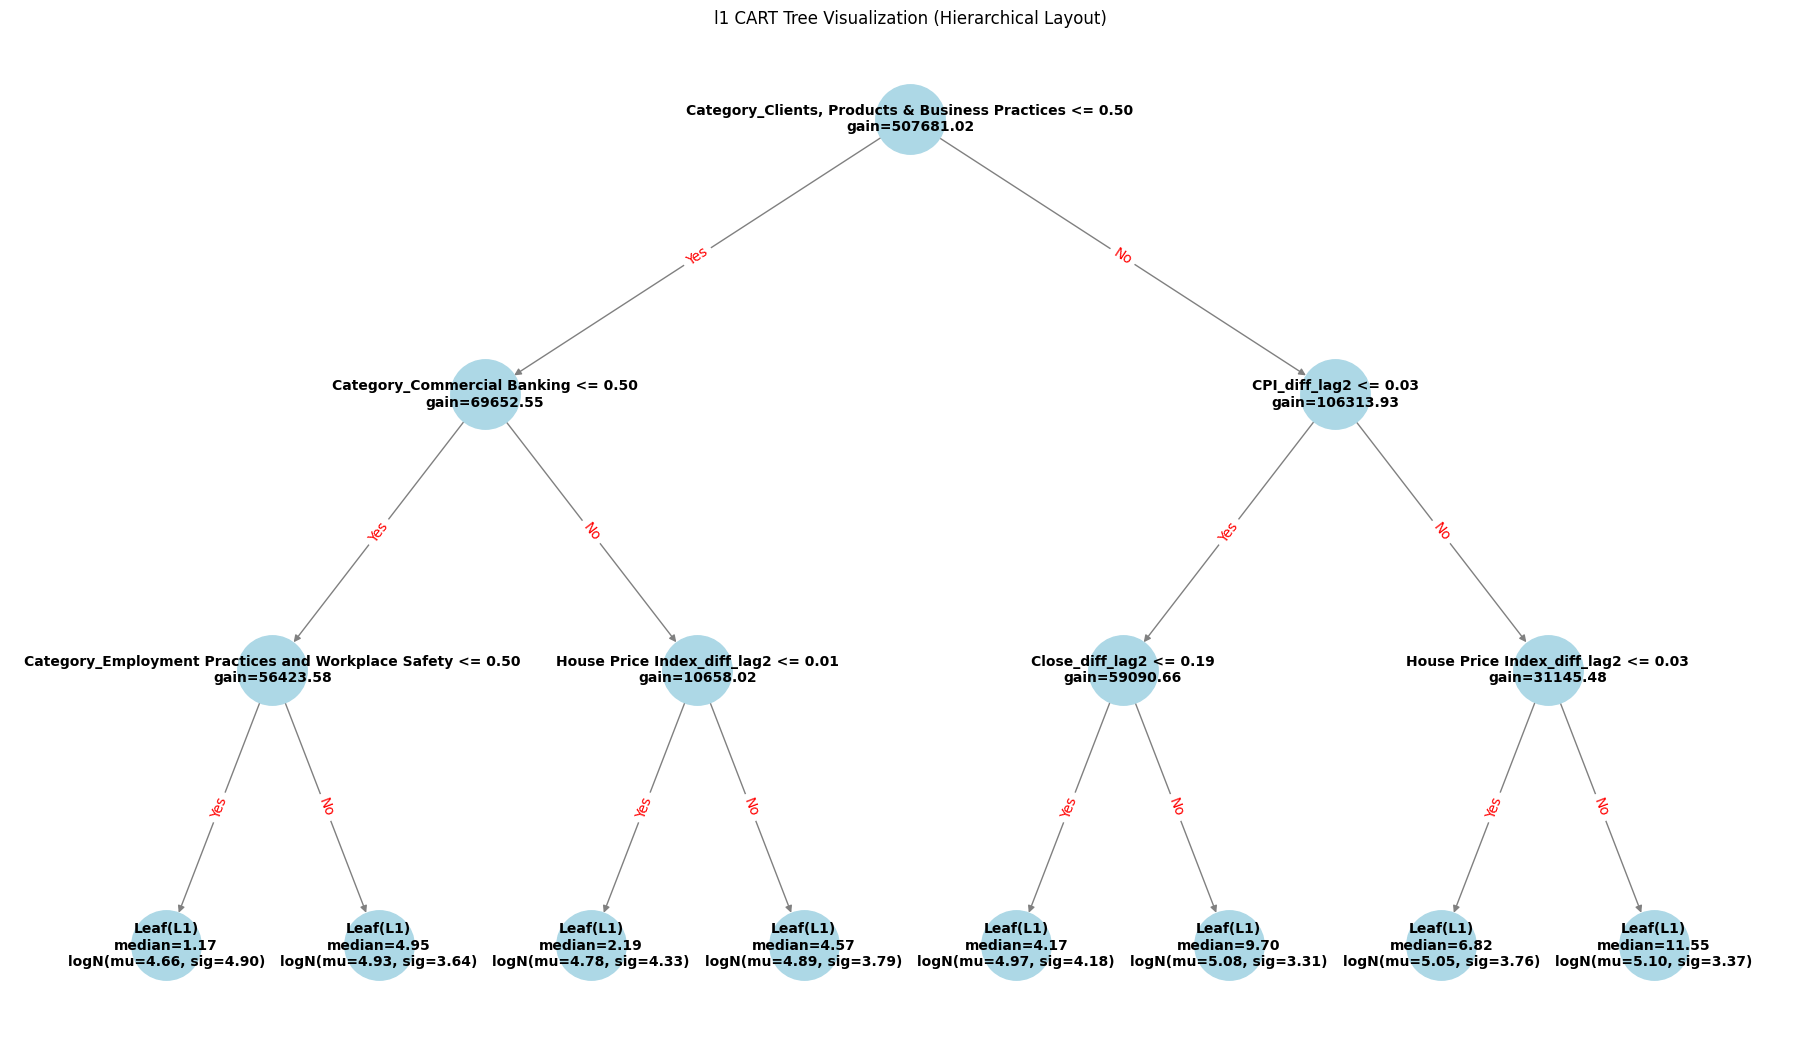

In [ ]:
draw_l1_tree_graph_hier(l1_tree_non,feature_names_list_non)

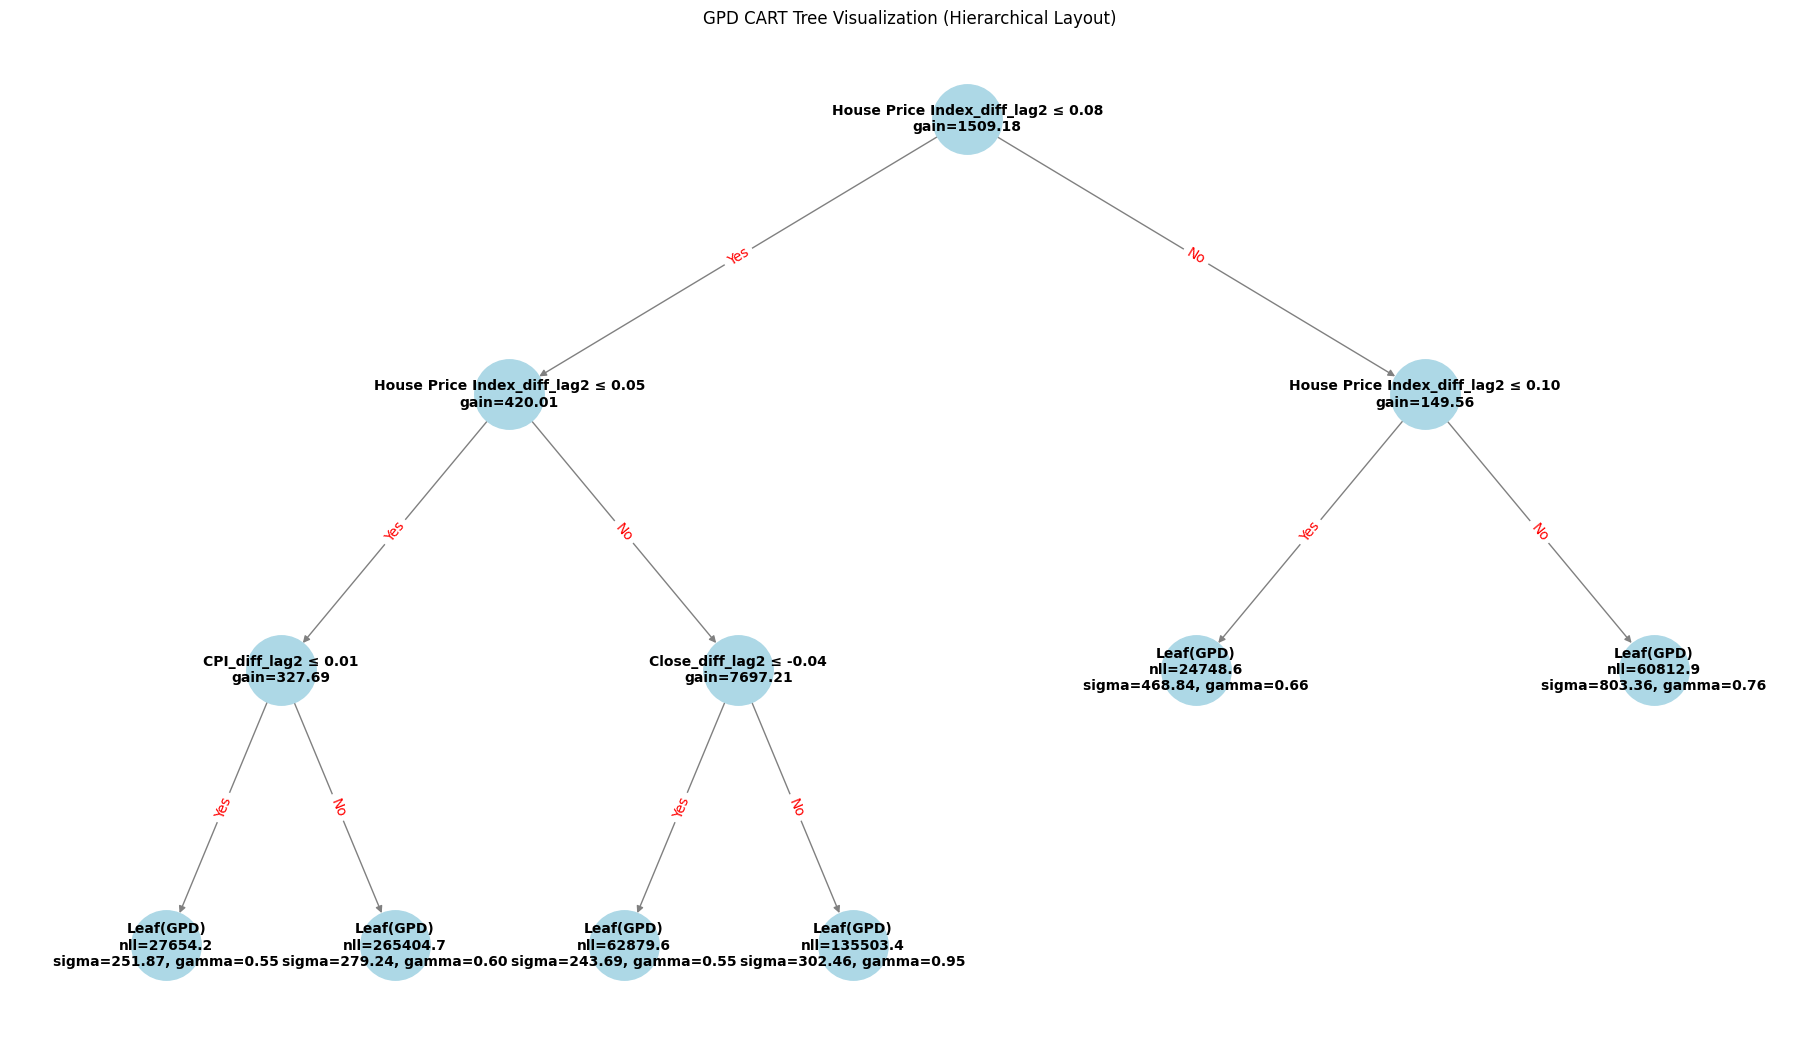

In [ ]:
draw_gpd_tree_graph_hier(merged_gpd_non,feature_names_list_non)